In [1]:
NUM_ATOMS = 9
NUM_ACTIONS = NUM_ATOMS * NUM_ATOMS * 3
NUM_GPU = 1
# torch imports
import torch

# local imports
from utils.helpers import  Database, store_safely
from model import ActionPredictionModel
from mcts import  MCTS
import numpy as np
import os
import time
import sys
from environment.environment import  Env
from environment.molecule_state import MolState
from environment.chemprop_IR.smiles_predict import Forward_IR
from environment.RPNMR import predictor_new as P
from rdkit import Chem
from collections import OrderedDict
# import wandb
import ipdb
import pickle
from copy import deepcopy
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
from queue import Queue
import random
from IPython.display import display

PRETRAINING_SIZE = 3000

BATCH_SIZE = 32
import ray
os.system('ray stop; ray start --head --num-cpus=10 --num-gpus=1 --object-store-memory 50000000000')
ray.init(address='auto', _redis_password='5241590000000000')


nmr_list = None

Using backend: pytorch
2022-04-11 18:44:32,564	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.16.0.144:6379


In [2]:
@ray.remote(num_gpus=1)
class EpisodeActor(object):
    def __init__(self, idx):
        self.idx = idx
        self.experiences = []
        self.clearFlag = False
        self.max_size = 50000
        self.size = 0
        self.insert_index = 0
        self.reward = []
        self.trainreward = []
        self.in_queue = False
        self.model_dict = []
        self.lock = False
        self.ir_forward = Forward_IR("~/DeepSPInN/models/IR_Forward" , True)
        #self.nmr_forward = P.NMRPredictor("~/DeepSPInN/models/RPNMR/best_model.meta","~/DeepSPInN/models/RPNMR/best_model.00000000.state",True)
        self.cached_ir_size = 0
        self.cached_ir_forward = dict()
        self.cached_reward_size = 0
        self.cached_reward = dict()
    
    def add_experience(self, experience):
        self.store(experience)

    def reset_reward(self):
        self.cached_reward_size = 0
        self.cached_reward.clear()
        return True
    
    def get_cache_reward(self, smiles):
        smiles = Chem.CanonSmiles(smiles)
        if smiles in self.cached_reward:
            return self.cached_reward[smiles]
        else:
            return None
    
    def set_cache_reward(self, smiles, reward):
        if self.cached_reward_size > 10000:
            self.reset_reward()
        smiles = Chem.CanonSmiles(smiles)
        self.cached_reward[smiles] = reward
        self.cached_reward_size += 1

    def get_NMR_spectrum(self,smiles):
        return self.nmr_forward.predict(smiles)
    
    def get_IR_spectrum(self, smiles):
        if smiles in self.cached_ir_forward:
            return self.cached_ir_forward[smiles]
        else:
            self.cached_ir_forward[smiles] = self.ir_forward.predict_smiles(smiles)
            if self.cached_ir_size < 500: # don't add spectra to cache after these many spectra
                self.cached_ir_size += 1
            else:
                self.cached_ir_size = 1
                self.cached_ir_forward.clear()
                self.cached_ir_forward[smiles] = self.ir_forward.predict_smiles(smiles)

            return self.cached_ir_forward[smiles]
        return self.ir_forward.predict_smiles(smiles)

    def store(self,experience):
        if self.size < self.max_size:
            self.experiences.append(experience)
            self.size +=1
        else:
            self.experiences[self.insert_index] = experience
            self.insert_index += 1
            if self.insert_index >= self.size:
                self.insert_index = 0
    
    def clear_exprience(self):
        self.messages = []

    def get_experience(self):
        experiences = self.experiences
        return experiences

    def get_size(self):
        return self.size

    def increment_size(self):
        self.size += 1

    def set_lock(self,value):
        self.lock = value
        return value

    def get_lock(self):
        return self.lock

    def set_queue(self,value):
        self.in_queue = value
        return value

    def get_queue(self):
        return self.in_queue

    def add_model(self,value):
        self.model_dict.append(value)

    def get_model(self):
        return self.model_dict.pop()

    def get_model_length(self):
        return len(self.model_dict)

    def store_reward(self,value):
        self.reward.append(value)
        return 1

    def empty_reward(self):
        self.reward = []
        return 1

    def get_reward(self):
        return self.reward

    def store_trainreward(self,value):
        self.trainreward.append(value)
        return 1

    def empty_trainreward(self):
        self.trainreward = []
        return 1

    def get_trainreward(self):
        return self.trainreward

(pid=27691) WARNING:root:No normalization for BCUT2D_MWHI
(pid=27691) WARNING:root:No normalization for BCUT2D_MWLOW
(pid=27691) WARNING:root:No normalization for BCUT2D_CHGHI
(pid=27691) WARNING:root:No normalization for BCUT2D_CHGLO
(pid=27691) WARNING:root:No normalization for BCUT2D_LOGPHI
(pid=27691) WARNING:root:No normalization for BCUT2D_LOGPLOW
(pid=27691) WARNING:root:No normalization for BCUT2D_MRHI
(pid=27691) WARNING:root:No normalization for BCUT2D_MRLOW




Executing episode 0 on GPU 0
Trying to find CC(C)N=COC(C)C
(EpisodeActor pid=27691) Loaded all checkpoint models


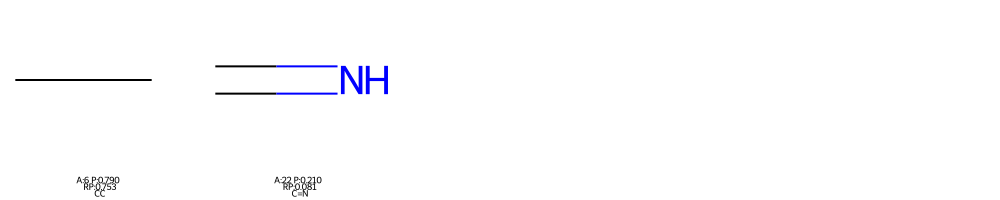

Action Taken: 6
CC - CC(C)N=COC(C)C Reward: 0


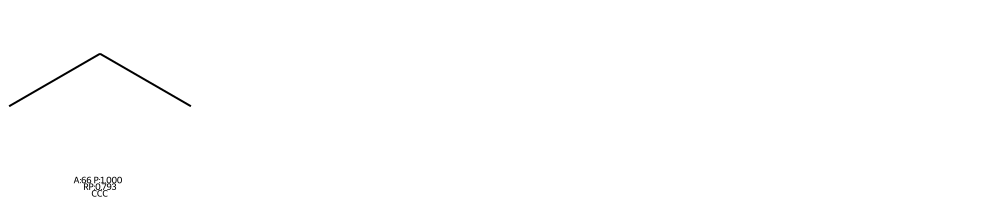

Action Taken: 66
CCC - CC(C)N=COC(C)C Reward: 0


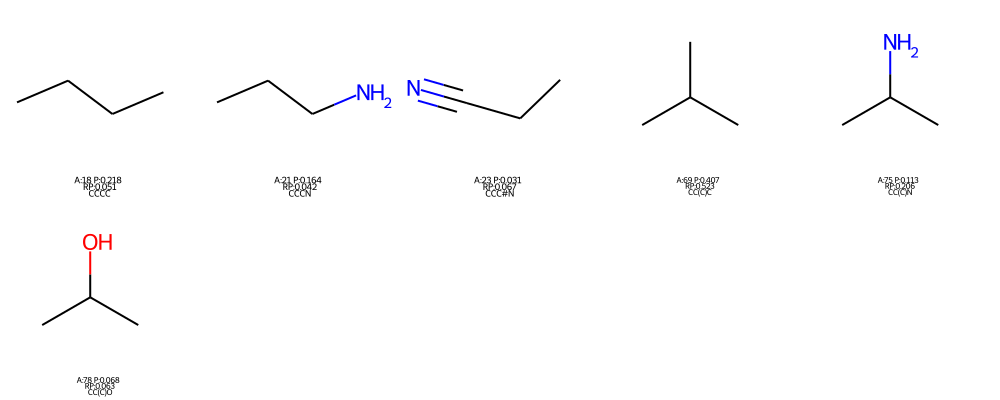

Action Taken: 18
CCCC - CC(C)N=COC(C)C Reward: 0


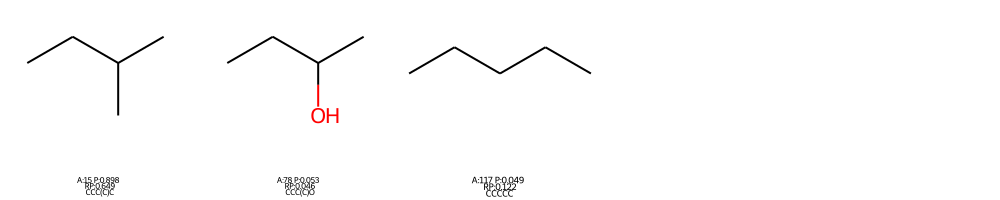

Action Taken: 69
CCC(C)C - CC(C)N=COC(C)C Reward: 0


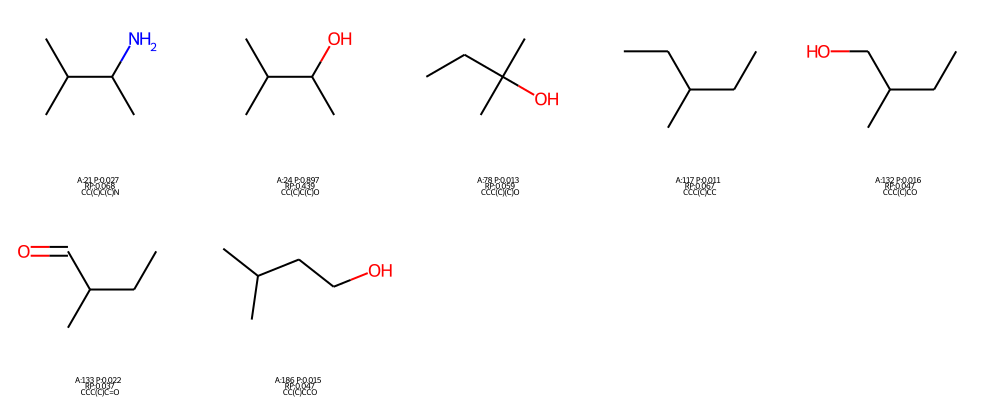

Action Taken: 24
CC(C)C(C)O - CC(C)N=COC(C)C Reward: 0


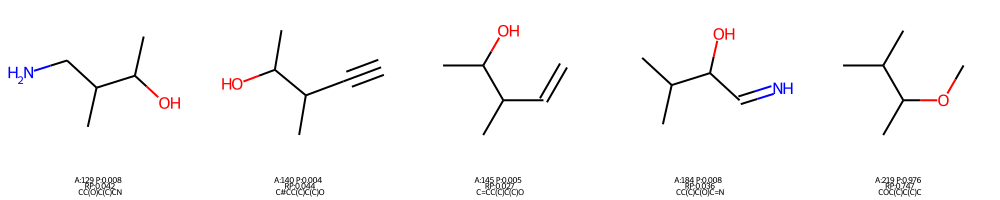

Action Taken: 219
COC(C)C(C)C - CC(C)N=COC(C)C Reward: 0


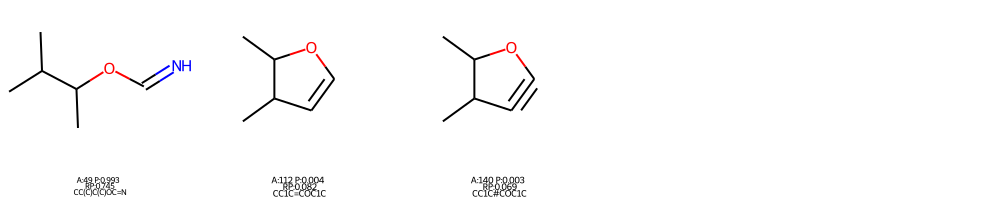

Action Taken: 49
CC(C)C(C)OC=N - CC(C)N=COC(C)C Reward: 0


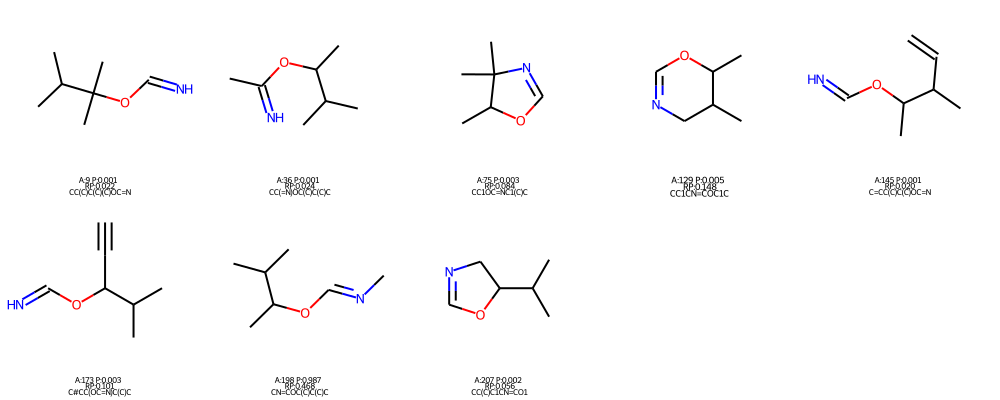

Action Taken: 198
CN=COC(C)C(C)C - CC(C)N=COC(C)C Reward: 0.810444087523115
Finished episode 0, T:CC(C)N=COC(C)C P:CN=COC(C)C(C)C, total return: 0.81, total time: 38.5 sec


In [8]:
def execute_episode(ep, idx, model, valuemodel,nmr_list,episode_actor,ir_train_dat,gpu_id):

    print('\n\nExecuting episode', ep, 'on GPU', gpu_id)

    # episode execution goes here
    # initialize mcts
    np.random.seed()
    env = Env([2,0,0,0], np.zeros(1801), [(5,3), (5,3)]) # dummy values to initialize the env
    episode_rewards = []

    timepoints = []
    a_store = []

    env.reset(ir_train_dat=ir_train_dat, idx=idx) 
    
    start = time.time()
    s = MolState(env.molForm, env.targetNMR)
    mcts = MCTS(root_molstate=s, root=None, model=model, valuemodel=valuemodel,na = 3*NUM_ATOMS*NUM_ATOMS,gamma=1.0)  # the object responsible for MCTS searches
    R = 0 
    n_mcts = 400
    
    max_leaf_r_hist = [0]
    #try:
    while True:
        # MCTS step
        forw_time = time.time()
        max_leaf_r = mcts.search(n_mcts=n_mcts, c=1, env=env, episode_actor=episode_actor)  # perform a forward search

        # Check if a good leaf has been reached, increase n_mcts otherwise
        if max(max_leaf_r_hist) > max_leaf_r:
            n_mcts = 400
            # print('Updated n_mcts to', n_mcts, max_leaf_r_hist, max_leaf_r)
        max_leaf_r_hist.append(max_leaf_r)
        
        state, pi, V,fpib, raw_prior = mcts.return_results(1)

        # bring together similar actions
        non_zero_actions = list()
        smiles_after_actions = list()
        probs_of_actions = list()
        try:
            for idx, prob in enumerate(pi):
                if prob > 0:
                    non_zero_actions.append(int(idx))
                    probs_of_actions.append(prob)
                    new_env = deepcopy(env)
                    s1, r, terminal = new_env.step(episode_actor, int(idx))
                    smiles_after_actions.append(Chem.CanonSmiles(str(new_env.state)))
        except Exception as e:
            print(e)
        
        # bringing together probs of common actions
        combined_actions = dict()
        new_actions = list()
        new_probs = list()
        actions_smiles = dict()
        for action_index, action_smile in enumerate(smiles_after_actions):
            action_prob = probs_of_actions[action_index]
            action_num = non_zero_actions[action_index]

            if action_smile not in actions_smiles:
                new_actions.append(action_num)
                new_probs.append(action_prob)
                actions_smiles[action_smile] = action_num
                combined_actions[action_num] = list()
                combined_actions[action_num].append(action_num)
            else:
                new_action_index = new_actions.index(actions_smiles[action_smile])
                new_probs[new_action_index] += action_prob
                combined_actions[actions_smiles[action_smile]].append(action_num)
        new_probs = np.array(new_probs)/sum(new_probs)
        
        new_raw_priors = list()
        for comb_action in combined_actions:
            tot_prior = 0
            for repeated_action in combined_actions[comb_action]:
                tot_prior += raw_prior[repeated_action]
            new_raw_priors.append(tot_prior)
        new_raw_priors = np.array(new_raw_priors)
                            
        action_mols = list()
        mols_labels = list()
        for idx, prob in enumerate(new_probs):
            new_env = deepcopy(env)
            s1, r, terminal = new_env.step(episode_actor, int(new_actions[idx]))
            action_mols.append(Chem.MolFromSmiles(str(new_env.state)))
            mols_labels.append('A:{} P:{:.3f}\n RP:{:.3f}\n {}'.format(new_actions[idx], prob, new_raw_priors[idx],str(new_env.state)))
            # print(mols_labels)

        img = Chem.Draw.MolsToGridImage(action_mols, legends=mols_labels, molsPerRow=5)
        display(img)
        #print(raw_prior, new_raw_priors, combined_actions)
            
#         inp = input('Choose the action')
#         if len(inp) != 0:
#             a = int(inp)
        # Make the true step
        # a = np.random.choice(len(pi), p=pi)
        a = np.argmax(pi)
        print('Action Taken:', a)
        a_store.append(a)
        #print('Before doing step')
        s1, r, terminal = env.step(episode_actor, int(a))
        # if r != 0:
        print(env.state, "-", env.targetmol, "Reward:", r)#,"model prior argmax:  ",np.argmax(state.priors),"  action taken:  ",a," prior argmax:  ",np.argmax(pi),"   Episode: ",ep)
        
        sys.stdout.flush()

        R = r
        if terminal:
            break
        else:
            mcts.forward(a, s1)
    #except Exception as e:
    #    print(e)
    del mcts

    #print('Trying to print experiences')

    # Finished episode
    episode_rewards.append(R)  # store the total episode return
    sys.stdout.flush()


    print('Finished episode {}, T:{} P:{}, total return: {}, total time: {} sec'.format(ep, env.targetmol, env.state, np.round(R, 2),np.round((time.time() - start), 1)))

    return 1

def run():
    #THES REWARD FILES NOT USED ANYMORE:
    # reward_file = open("./reward.log","w")
    # train_reward_file = open("./trainreward.log","w")
    reward_file, train_reward_file = None, None
    num_episodes = 1
    num_processes = 1

    episode_actors = [EpisodeActor.remote(i) for i in range(NUM_GPU)]

    with open('~/DeepSPInN/data/qm9_clean_ir_nmr.pickle', 'rb') as handle:
        ir_all_datasets = pickle.load(handle)
    ir_train_dat = ir_all_datasets["test"]

    model =  ActionPredictionModel(88, 6, 88, 64)
    model.load_state_dict(torch.load("~/DeepSPInN/train/saved_models/prior21.state",map_location='cpu'))
    model_episode =  ActionPredictionModel(88, 6, 88, 64)
    model_episode.load_state_dict(deepcopy(model.state_dict()))
    del model

    valuemodel =  "valuemodel"
    valuemodel_episode =  "valuemodel"
    ### --------------models------------------ ###


    #for mol_id in range(16,200):
    # tricky_mols = [0, 7, 8, 11, 22, 23]
    tricky_mols = [179]
    for mol_id in tricky_mols:
        # each molecule runs for num_episodes * num_processes times
        for i in range(num_episodes):
            for gpu_id in range(NUM_GPU):
                ready_ids, remaining_ids = ray.wait([episode_actors[gpu_id].set_lock.remote(True)],num_returns=1)
            results = [execute_episode(j,mol_id,model_episode, valuemodel_episode,nmr_list,episode_actors[gpu_id],ir_train_dat,gpu_id) for j in range(num_processes*i,num_processes*(i+1)) for gpu_id in range(NUM_GPU)]
            # print("-----Episode", i, "done----")
            for gpu_id in range(NUM_GPU):
                ray.get(episode_actors[gpu_id].set_lock.remote(False))

run()

In [3]:
import pickle
import pandas as pd
import IPython

with open('~/DeepSPInN/data/qm9_clean_ir_nmr.pickle', 'rb') as handle:
    all_dat = pickle.load(handle)
    
all_dat = all_dat["test"]

0 CCc1nn[nH]c1N


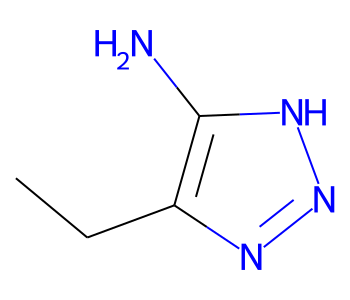

1 OC1C=CC2CCC=C12


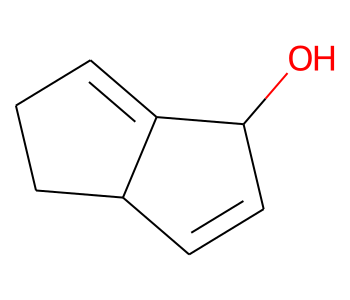

2 CCOC(CO)C(C)C


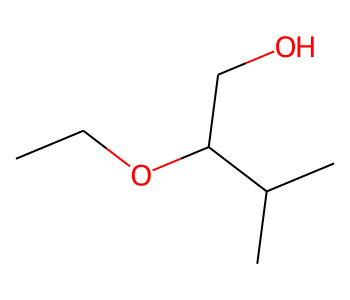

3 C1=CC2OC=NC2C1


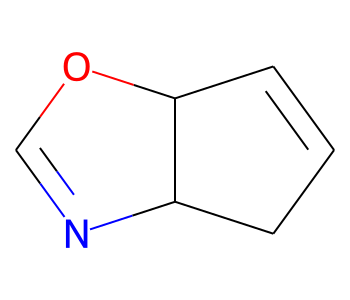

4 CCC1C=C(C)CO1


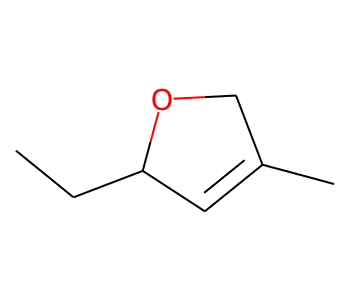

5 C#CC(C)(CC)C(C)C


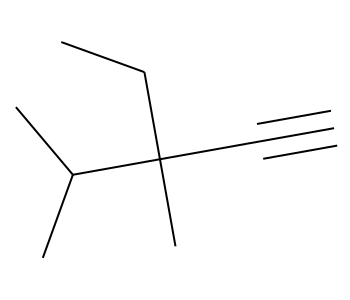

6 O=CC(=O)C1CCCC1


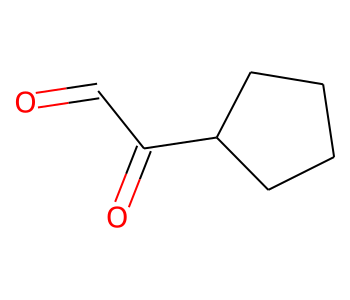

7 CCn1cc(N)cc1O


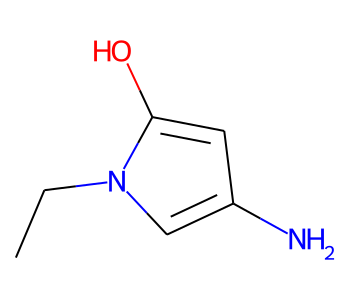

8 c1ccc2nocc2c1


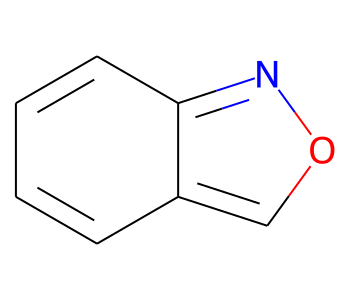

9 Cc1cnn(C(N)=O)n1


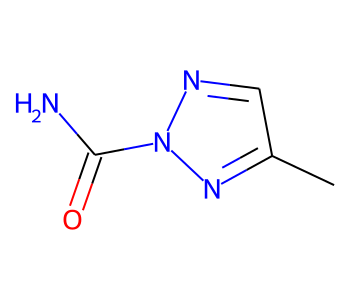

10 COCCC(C)(O)CO


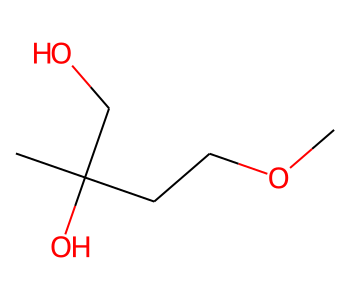

11 Cc1n[nH]c(C=O)c1N


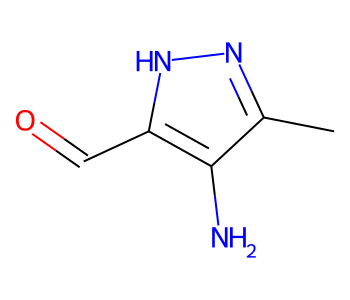

12 CCCCC(O)CCC


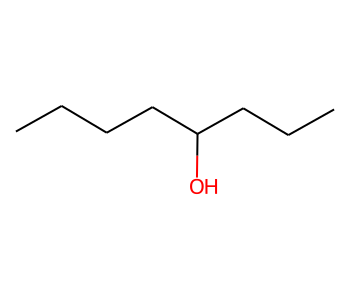

13 CN=C1OCC(C)C1O


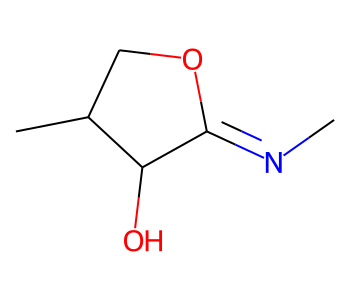

14 Fc1cncc(F)c1


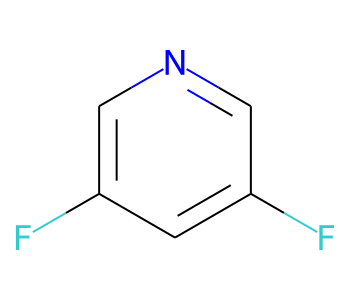

15 O=CNC1CCC(=O)C1


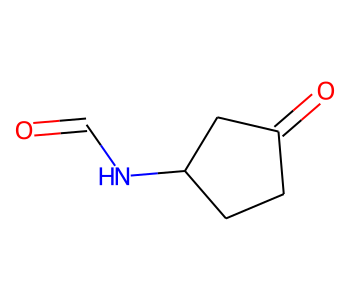

16 CC1C=CC(C)C(C)C1


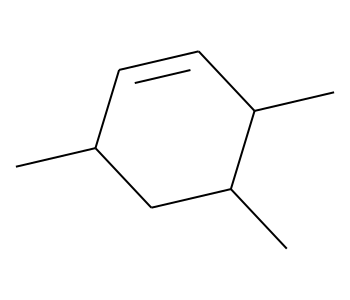

17 OCC1(CO)CCCO1


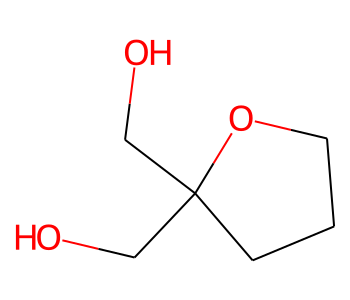

18 CCCOCC#CC#N


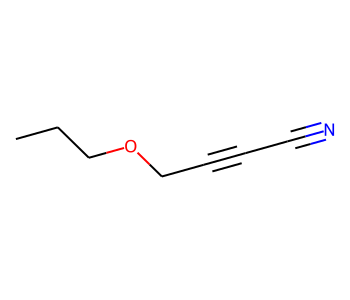

19 CNC(=O)N1CC=CC1


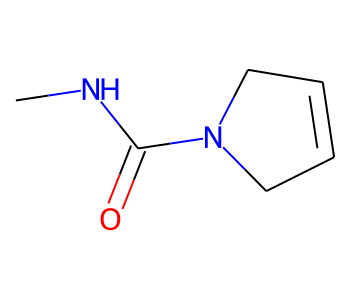

20 CC1CCOC1C=O


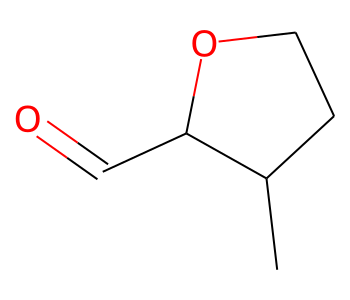

21 C1=CC2CCCC1O2


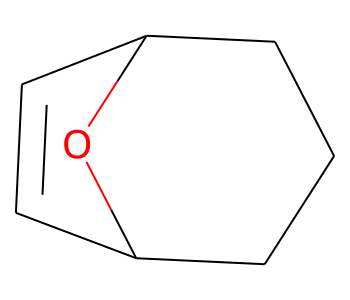

22 Cc1cnc(O)oc1=O


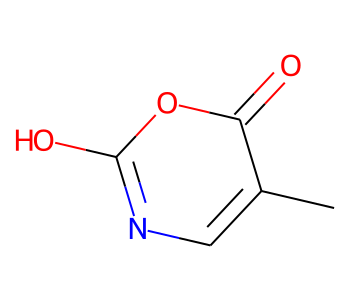

23 N#Cc1ncc(CO)o1


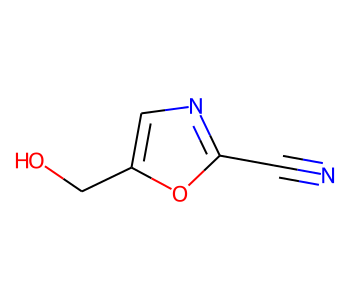

24 Cc1occc1C#N


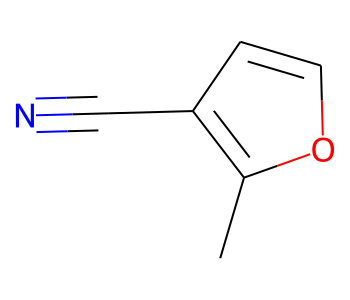

25 CCNc1c[nH]c(C)n1


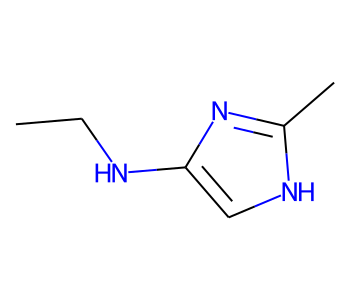

26 CC1(C)C(O)C=CC1O


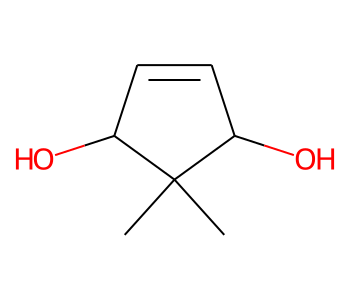

27 C1CC2OCC(CO1)O2


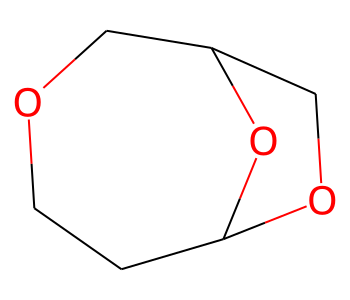

28 O=C1C=CC(=O)C(=O)N1


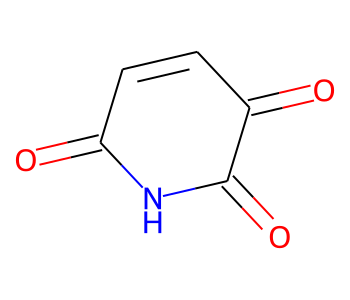

29 CNC1(C#N)CCCC1


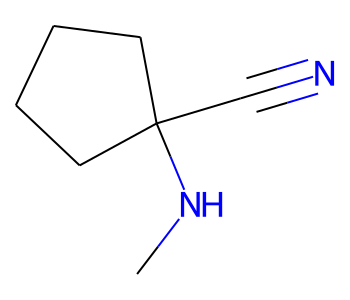

30 CC#Cc1n[nH]c(O)n1


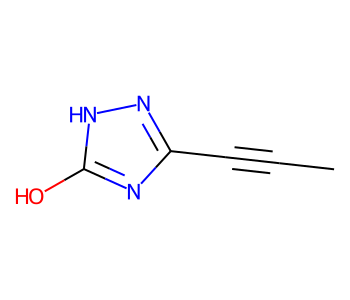

31 CC1CC(=O)CC1=O


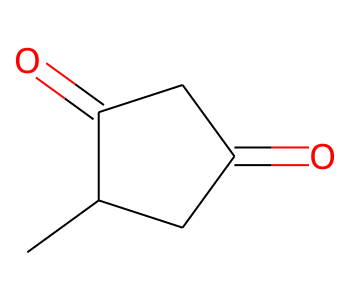

32 CC#Cc1cc(C)co1


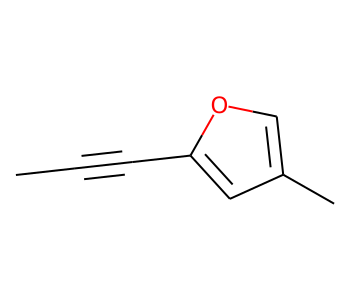

33 N=COCC1=CCOC1


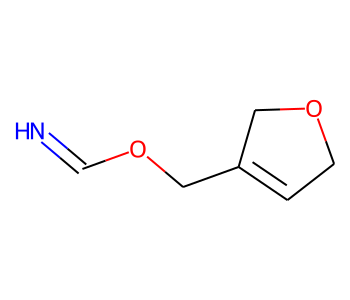

34 O=c1cc[nH]nc1


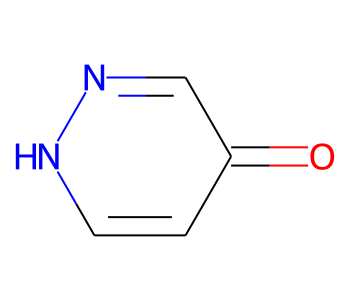

35 N#Cc1cc(N)[nH]n1


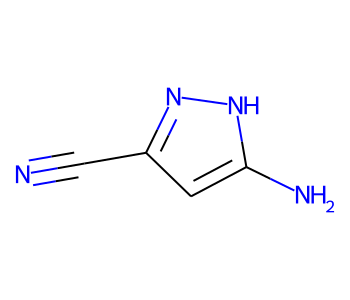

36 N=C1OC2CNC1C2


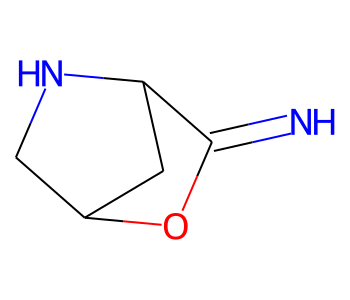

37 CN(C)c1occc1O


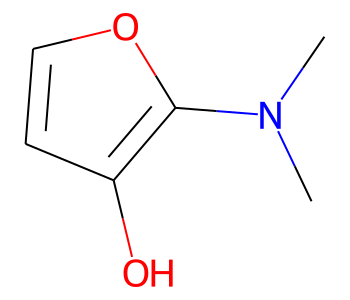

38 CCC#CC(C)C#N


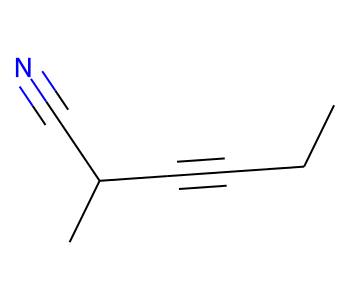

39 CC1=CCn2ccnc21


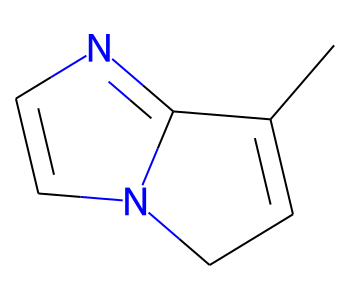

40 O=c1ccoc(F)n1


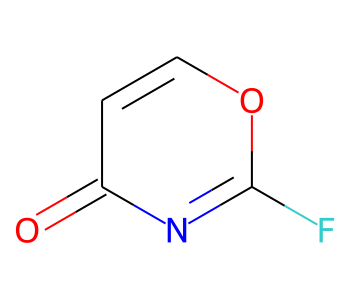

41 CC1C=CC(=O)NC=N1


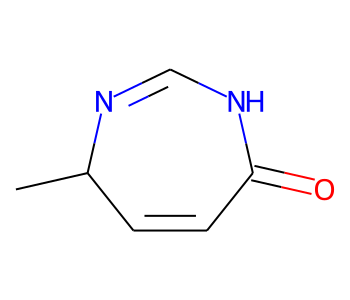

42 C#CC(N)C(=O)NC=O


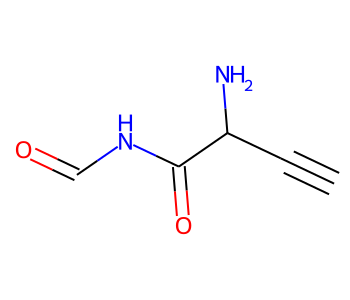

43 CNC(=O)CCCO


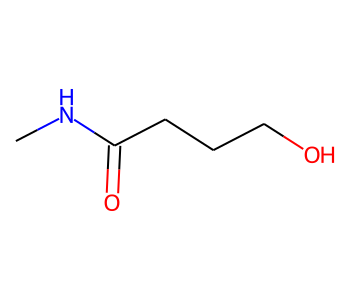

44 CCC(C)(C)O


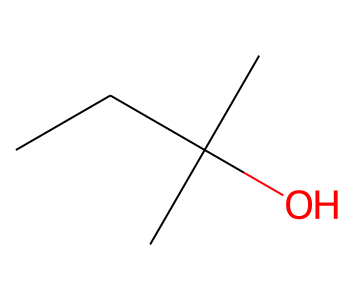

45 CNc1nc(C=O)no1


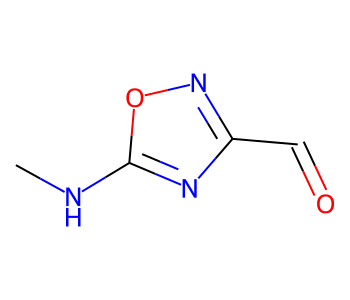

46 CC1=CC(O)COC1=N


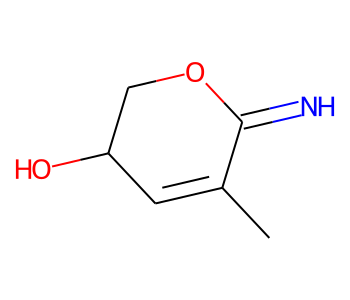

47 COc1cc(C)oc1N


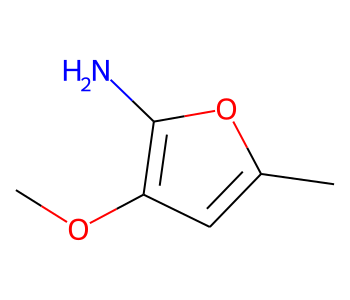

48 CCOC(C=O)CC#N


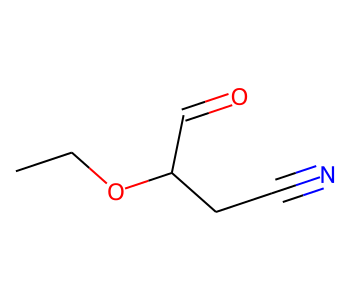

49 O=Cc1cnc(C=O)o1


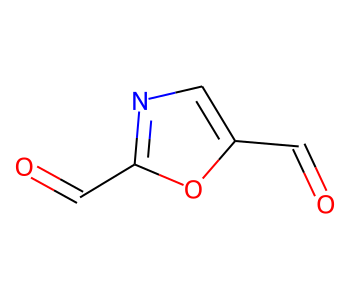

50 Nc1[nH]ncc1NC=O


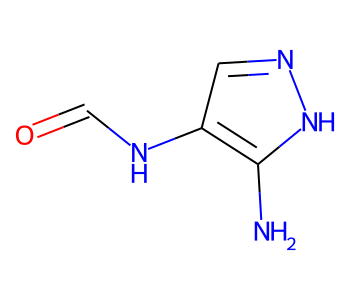

51 O=c1nc(O)nc[nH]1


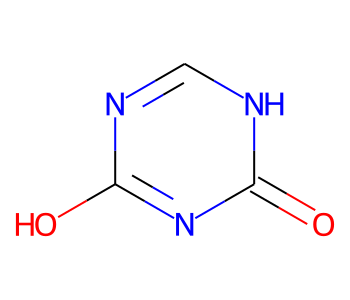

52 C#CCC(CC)=NO


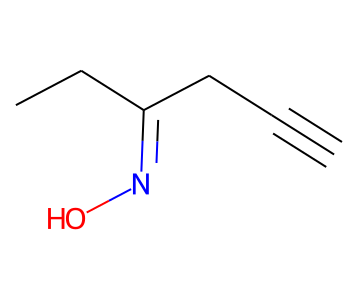

53 Cc1ncc(F)nc1C


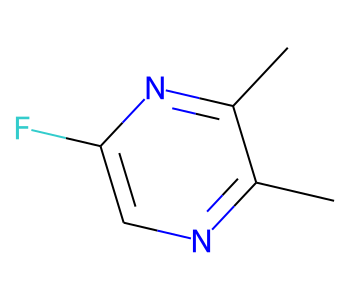

54 N#CCC#CC(N)=O


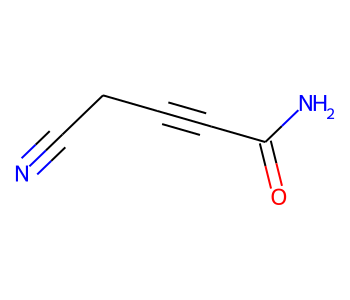

55 CCC#CCCC


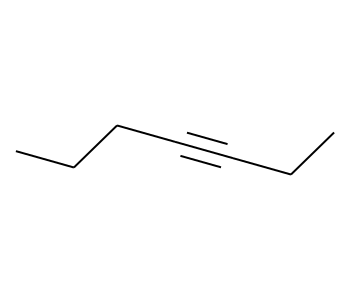

56 CC#CCC(C)(C)CC


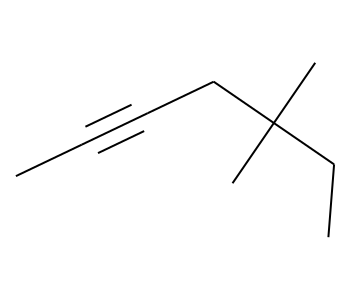

57 CCNc1[nH]nnc1C


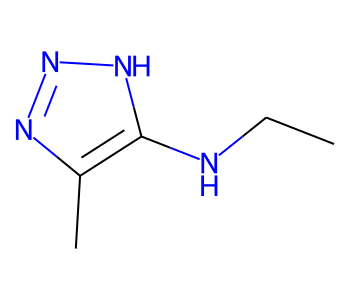

58 OCC1=CCCCC1O


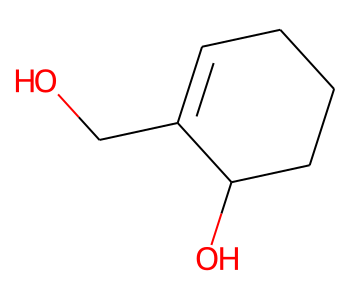

59 C1=NCc2n[nH]cc2O1


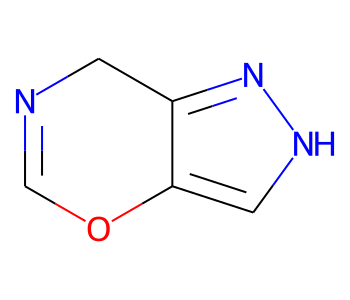

60 CCC1CC(=O)N(C)C1


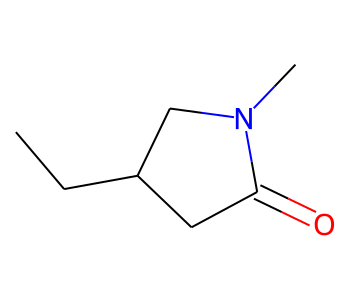

61 c1cc2onnc2[nH]1


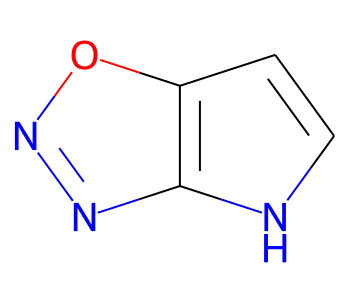

62 CC1(C)C=CC(=O)CC1


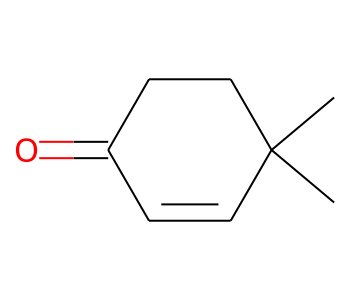

63 C#CCC1CC=CC1


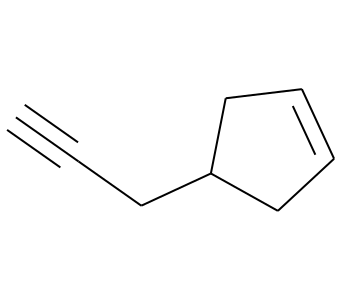

64 CCc1cccc(C)n1


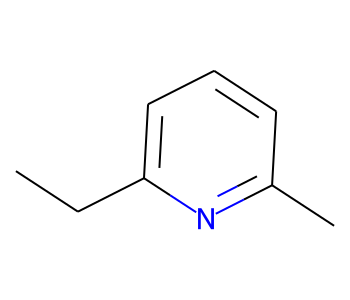

65 O=C1CCCCC(=O)N1


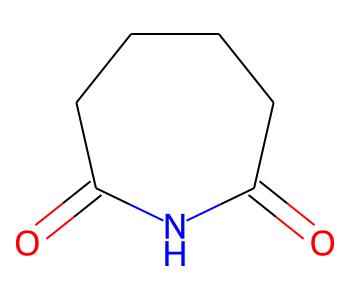

66 N#CC(=N)OC=O


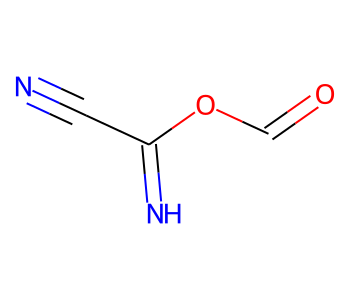

67 Cc1noc2c1CCO2


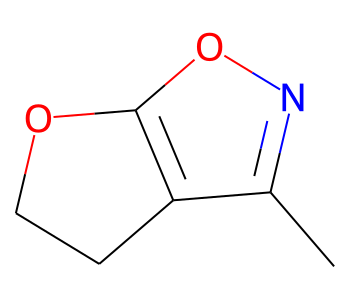

68 C#CCN(CC)CC=O


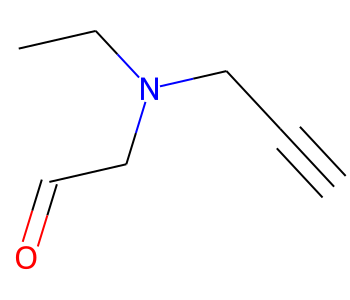

69 CCCNc1cnoc1


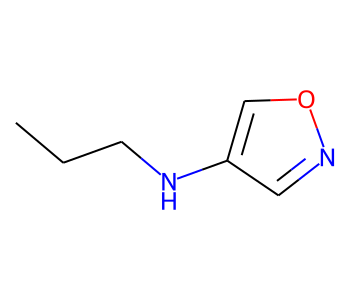

70 Cn1cc(C=O)nc1N


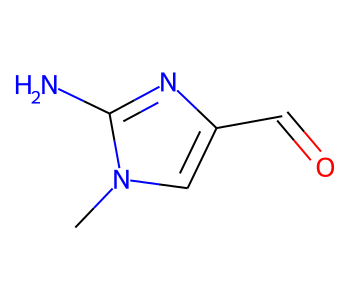

71 CN(C)c1[nH]ncc1O


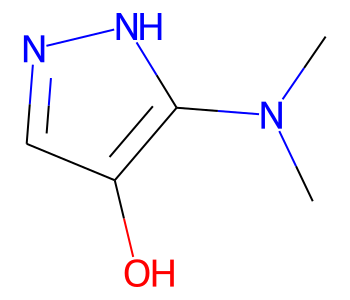

72 CC(C)C(CO)CO


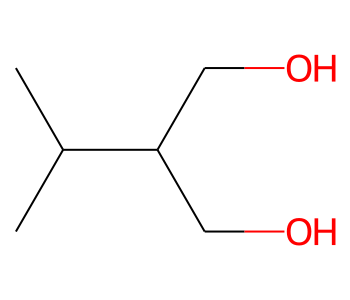

73 C#CCC(=NC)OC=O


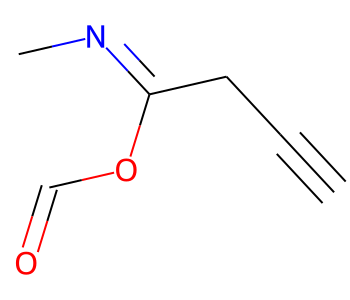

74 C#CC(O)C1CCOC1


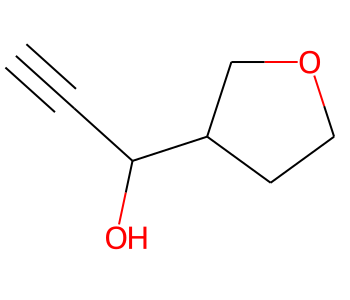

75 N#CC(=O)C1=CCCC1


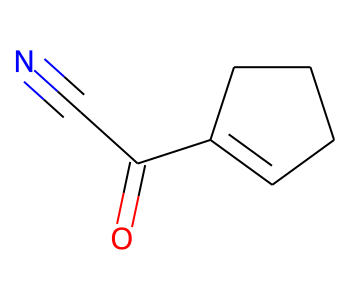

76 CC(=O)N(C=N)C=O


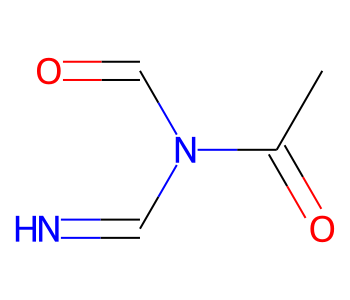

77 CC#CC(C)(C)CC#N


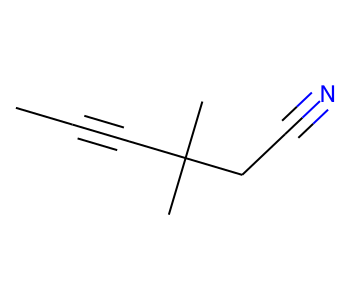

78 CCOC1CC=CCO1


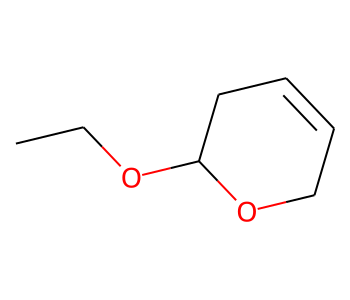

79 CC(=O)CN=C(N)C=O


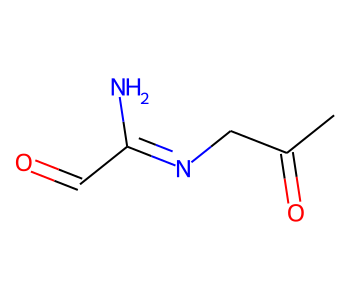

80 OC1CC2C=CCC2C1


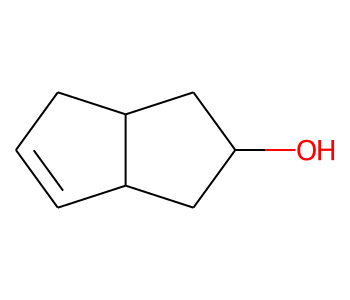

81 CNc1c[nH]nnc1=N


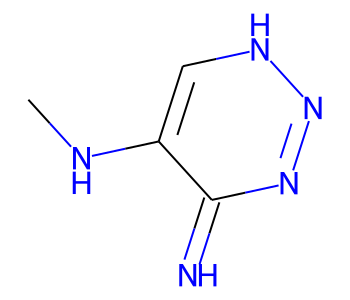

82 N#CC1=CCC(O)C1N


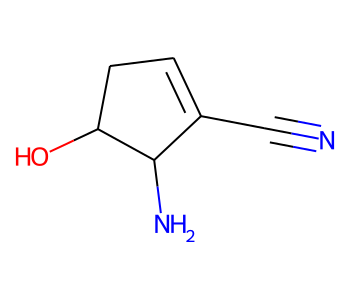

83 CN(C)CC#CC=O


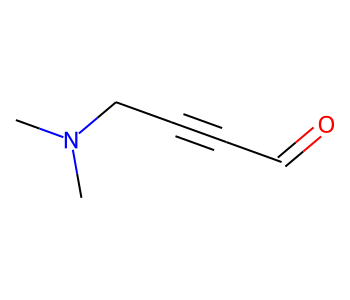

84 C1=NC2CCN=C2N1


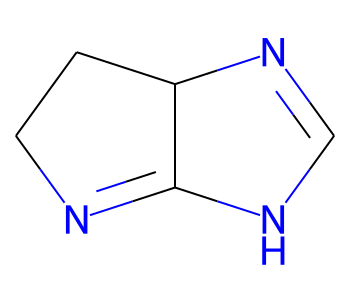

85 CC1NCC(=O)OC1C


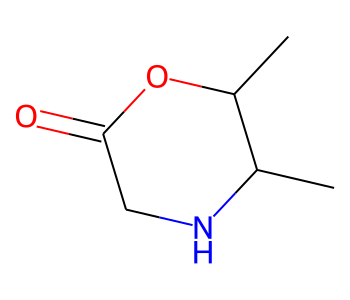

86 OCC#Cc1nnon1


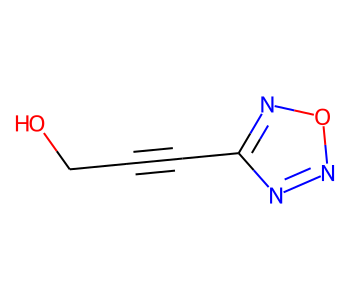

87 OCCc1cc(O)c[nH]1


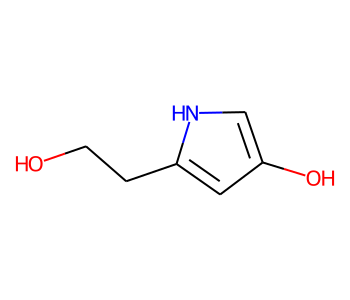

88 Nc1nc(O)no1


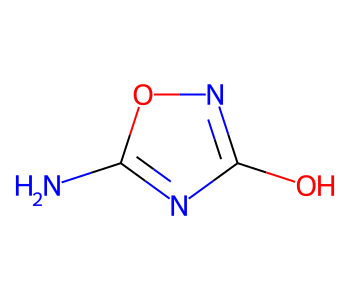

89 CCCCCC(C)(C)O


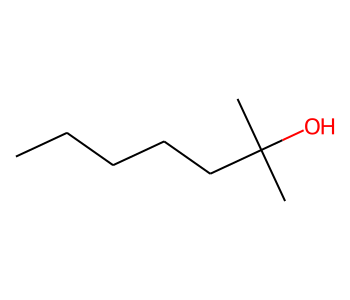

90 O=CNC1=CNC(=O)C1


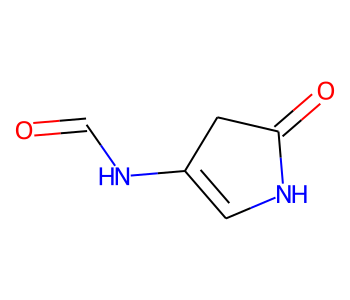

91 COc1c[nH]c(C=O)n1


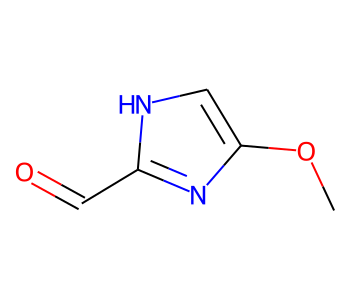

92 O=CCNc1cnn[nH]1


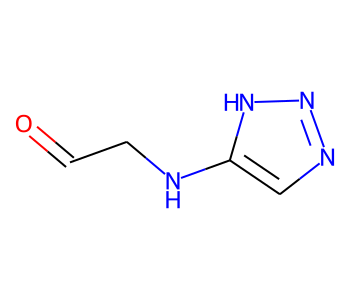

93 Cc1c(F)ccnc1N


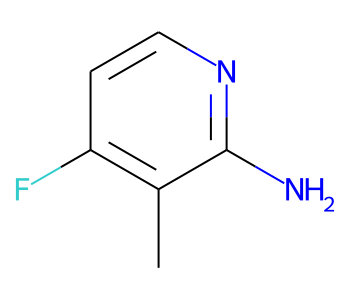

94 Nc1[nH]nnc1CO


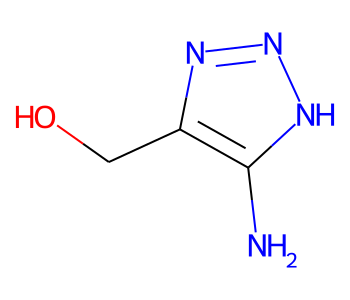

95 CNc1onnc1C=O


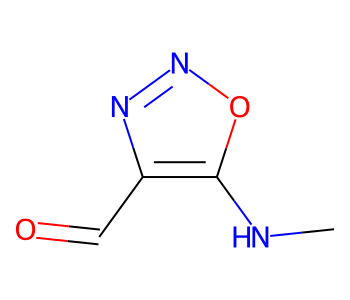

96 CC#CCNC(=N)C=O


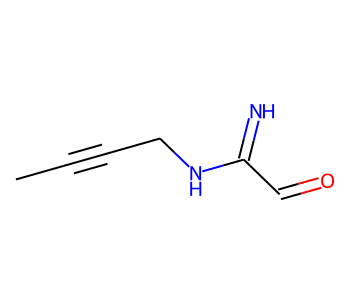

97 C1#CCC=CCCC=C1


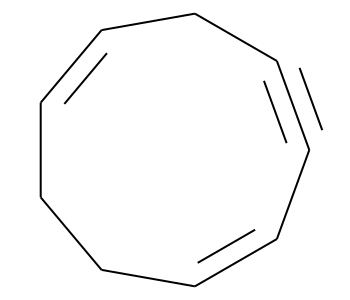

98 Cc1cn(CC#N)nn1


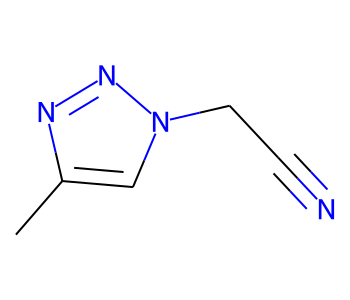

99 CC(C#N)(CO)NC=O


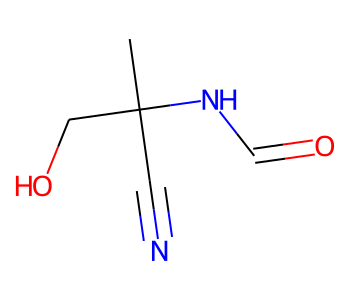

100 CC1=CC2COC1C2C


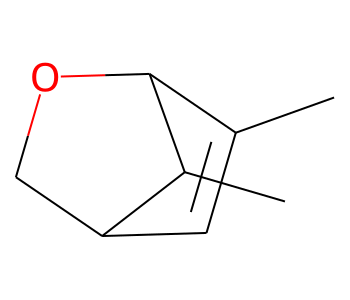

101 C#CC1=C(C#N)COC1


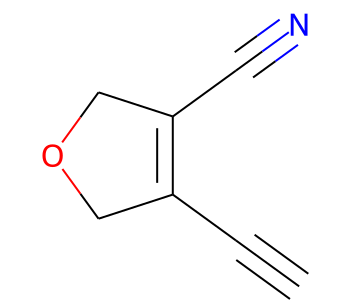

102 C#CC(=O)NCCC#N


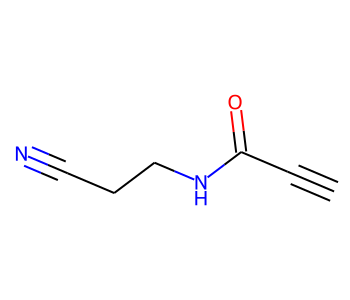

103 COC1C=C(C)C(=N)O1


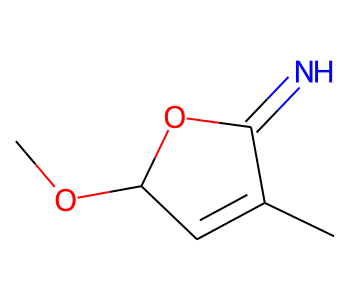

104 N#CCOCCC=O


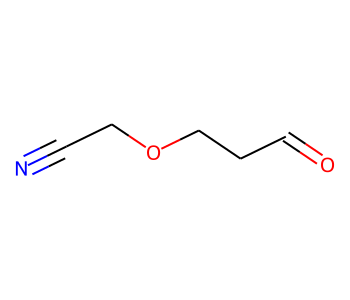

105 N=c1cncc(O)o1


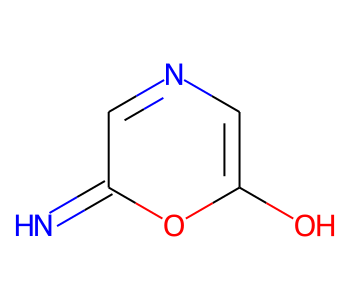

106 OCCn1cnc(O)c1


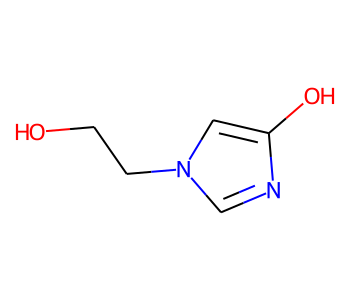

107 O=CNCC1=CCOC1


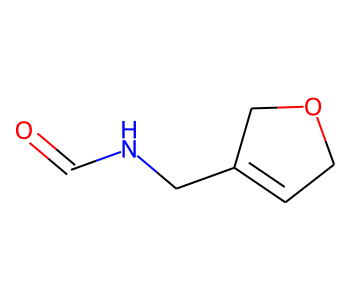

108 Nc1nc(CO)[nH]c1O


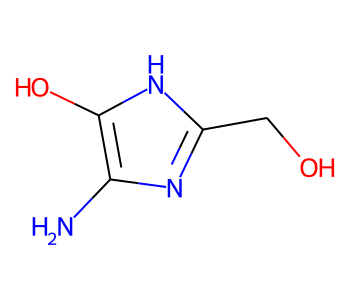

109 CN=c1ncocc1F


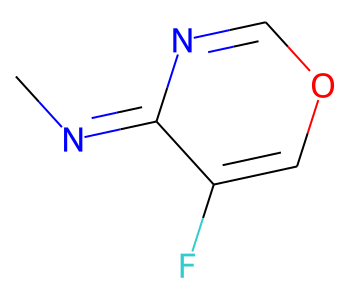

110 CC1=CC(O)CCC=C1


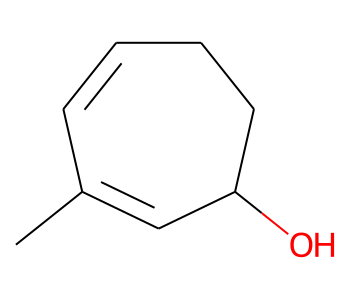

111 COCC1CCC(C)O1


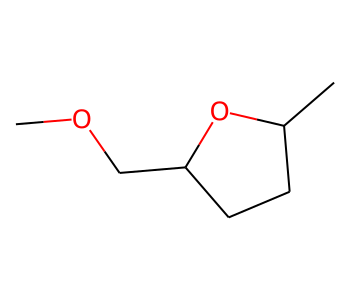

112 CC1=CCC(O)C1C#N


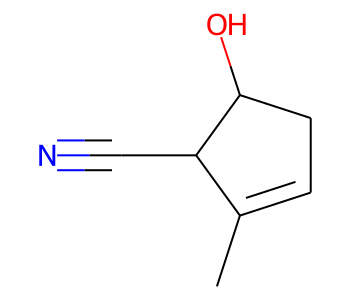

113 C#CC1COCC(N)=N1


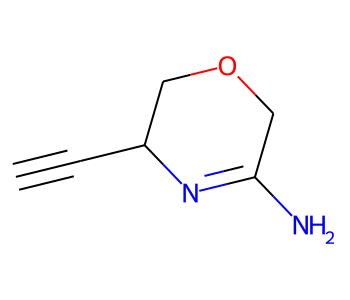

114 N#CC(N)CNCCO


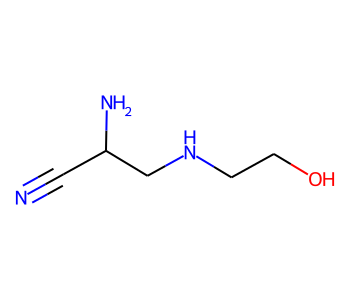

115 N#CC1CCCCO1


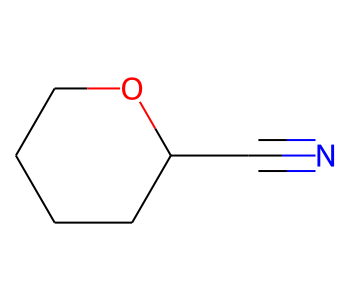

116 C#CC1NC(=O)OC1C


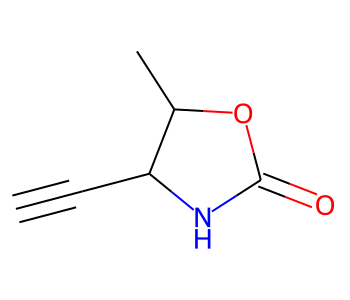

117 CC(CO)n1ccnc1


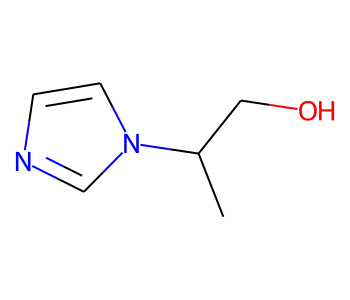

118 OCCc1ccco1


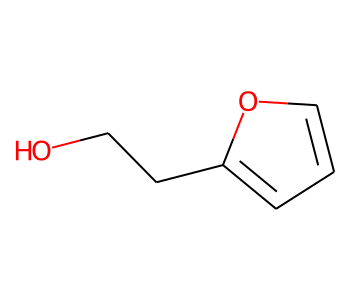

119 C#Cc1oc(N)nc1N


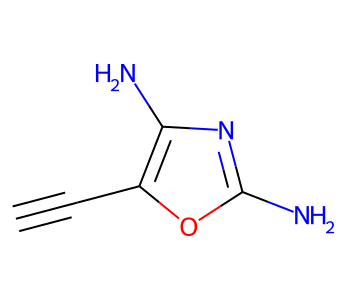

120 CC(O)CC#CCO


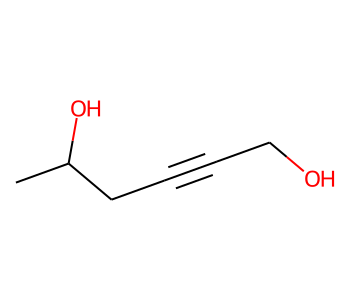

121 C#CCCCC(C)C#N


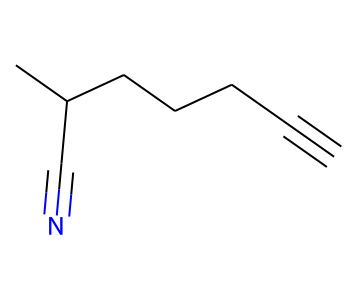

122 CCNc1cnoc1


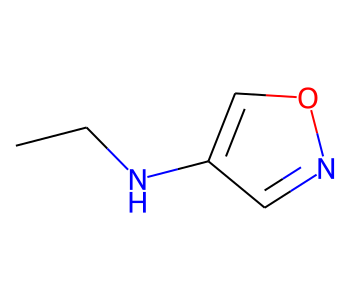

123 Cc1nc(CC#N)c[nH]1


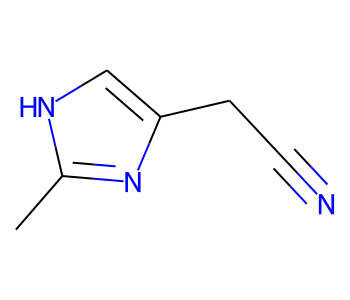

124 CCC(C)(O)CC(N)=O


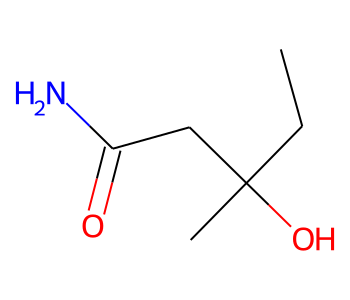

125 CCC(C)(C)OC(C)C


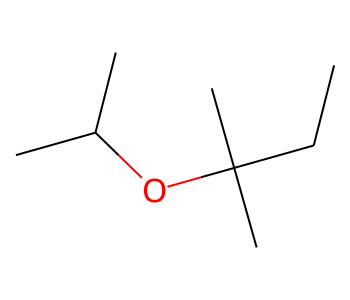

126 Nc1cc(F)ccc1O


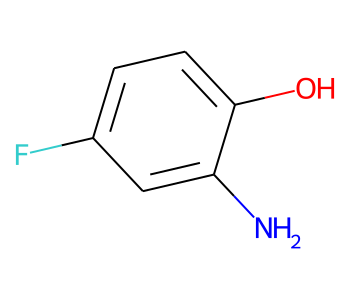

127 CN(C=O)c1cnoc1


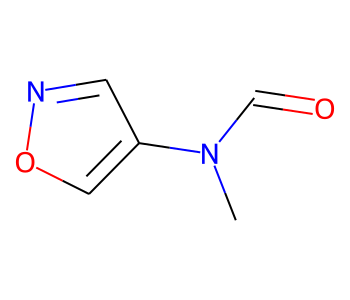

128 CCOC(=N)C(=O)NC


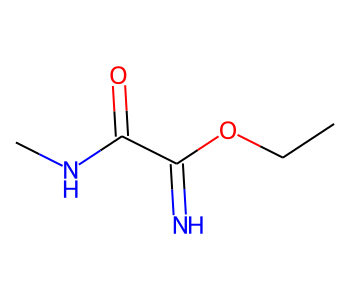

129 CCC(C)C(C)NC=O


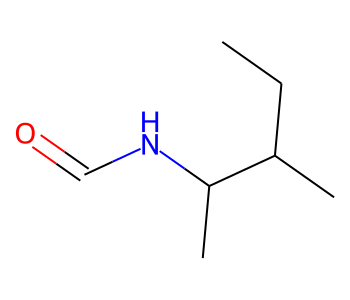

130 Nc1occ(CO)c1N


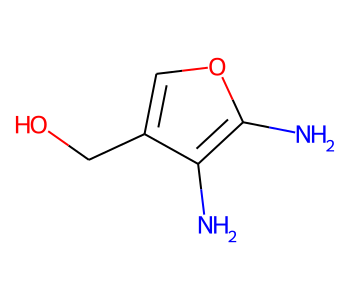

131 CC1=CCNC=CC1=O


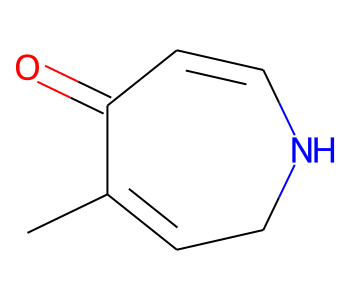

132 O=Cc1noc(C=O)n1


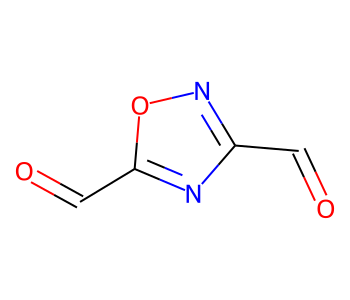

133 CCC(C)C#CC(C)=O


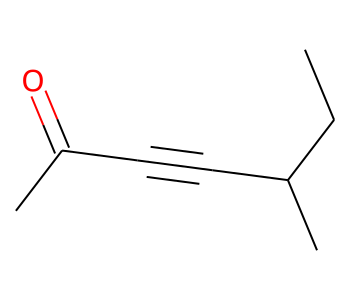

134 CCC1(C)C=CCO1


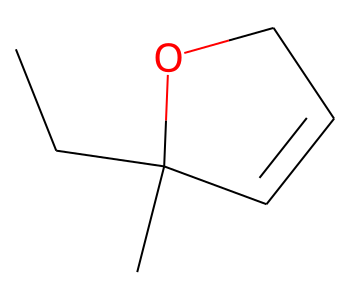

135 CC1OCCC(C=O)O1


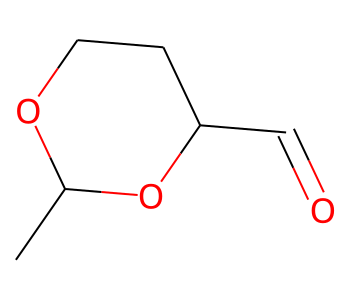

136 C#CC1CC(=O)NC1=N


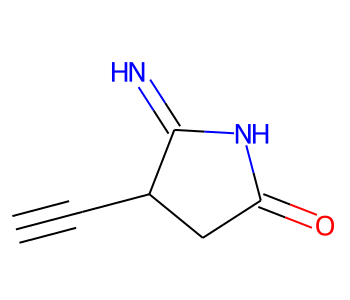

137 CCNC(=NC)C(N)=O


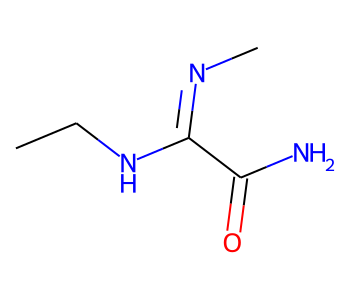

138 CCOc1nc(N)co1


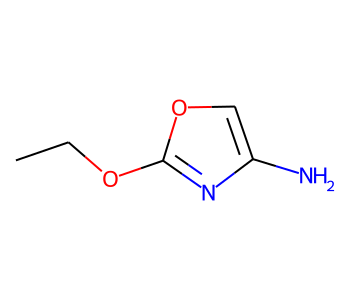

139 C1=CC2C=CC(C1)C2


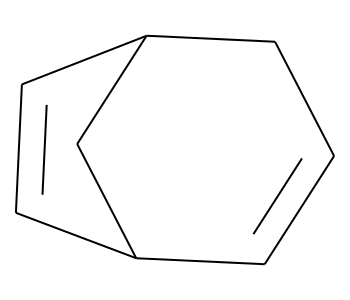

140 CC(O)CCCC=O


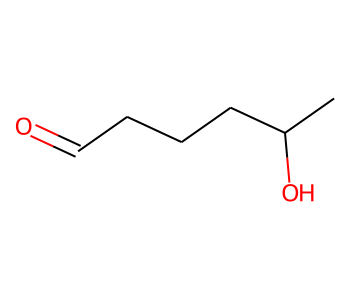

141 COC1C(=O)NCC1C


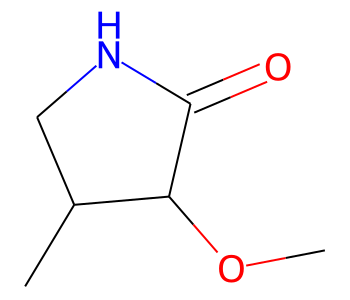

142 CC1OC2(C)CC1CO2


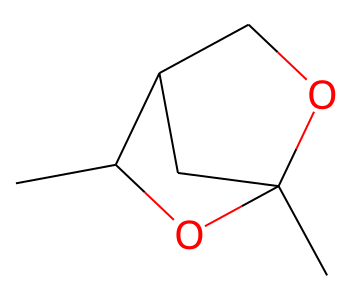

143 O=C1NC2CC(O)C1C2


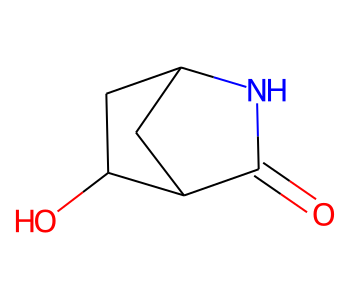

144 C#CC1=C(C)CCCC1


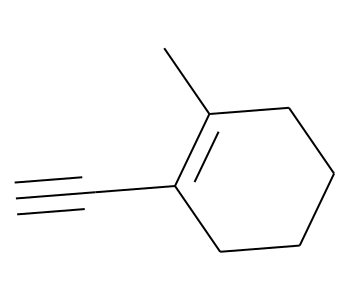

145 Cc1cc2c(o1)CCO2


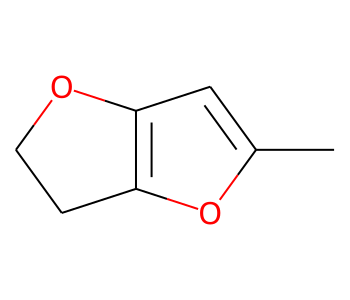

146 CCCn1cnc(C)c1


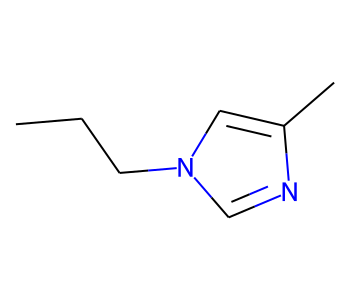

147 OCC1CC(O)C(O)C1


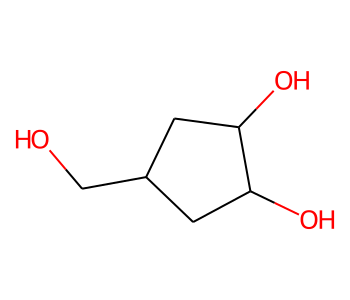

148 N=c1ncocnc1=O


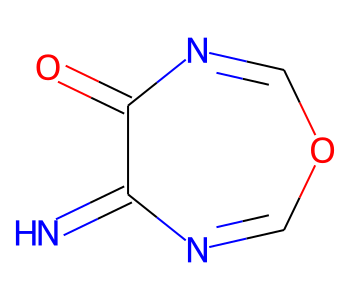

149 COC(CC#N)C(C)=O


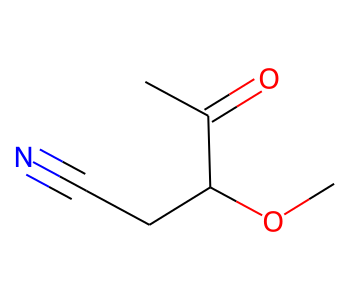

150 Cc1ccccc1O


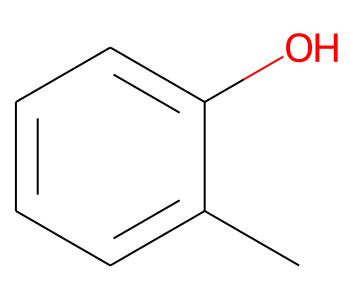

151 c1cn2cnoc2n1


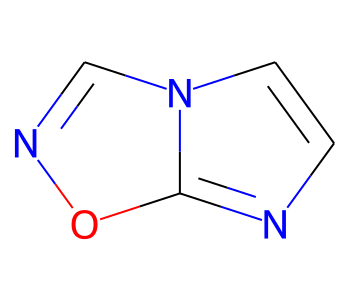

152 c1cnc2n[nH]cc2n1


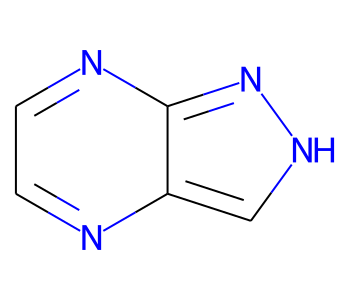

153 CC1C=C(CO)CC1O


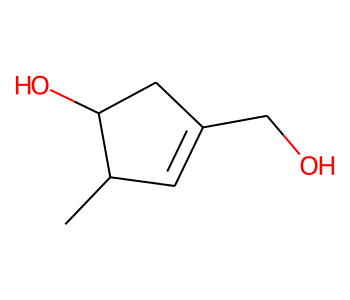

154 CCC1C=CCC1(C)O


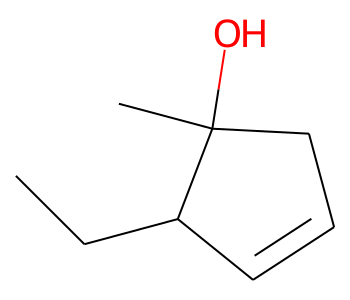

155 CCN1CC(=N)NC1=O


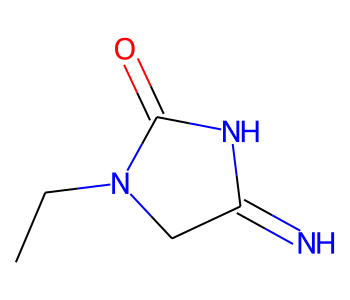

156 Cc1c[nH]c(N)c1C#N


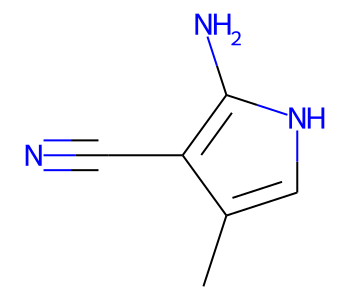

157 Cc1coc(=N)c(=O)o1


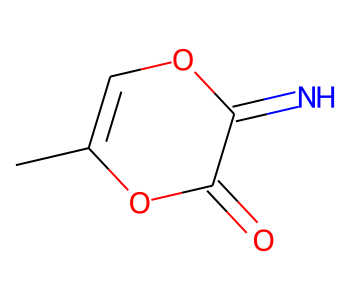

158 N#CC1C(=O)CN=C1N


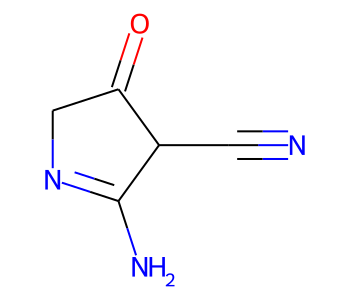

159 CC(C)C(CO)CC#N


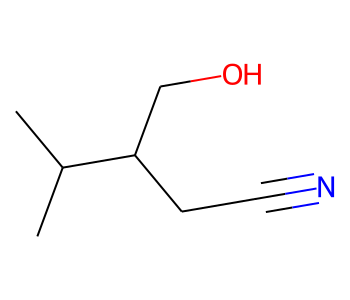

160 O=CCn1cnc(O)n1


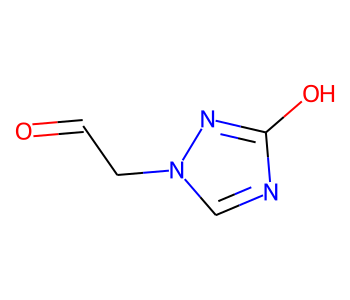

161 CN=c1cccc(C)o1


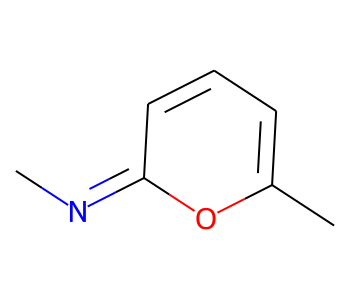

162 C#CC(C)(C#C)OC=N


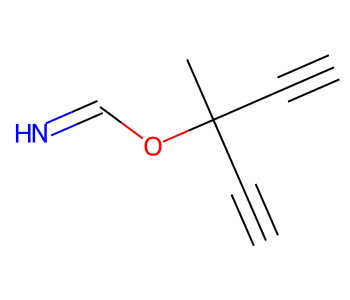

163 CCC1CNCC(=O)C1


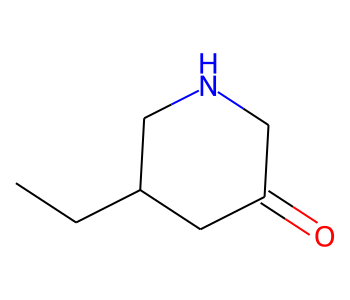

164 CC1CC2(O)COC1C2


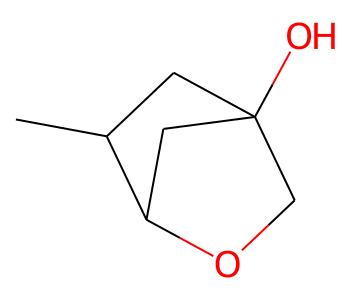

165 CC#CC(C)(C)C(N)=O


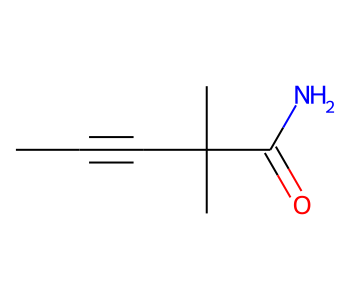

166 CC1=CC(=NO)CCN1


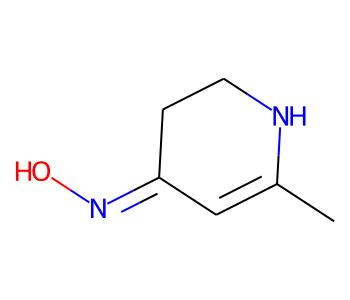

167 CN=CNc1c[nH]nn1


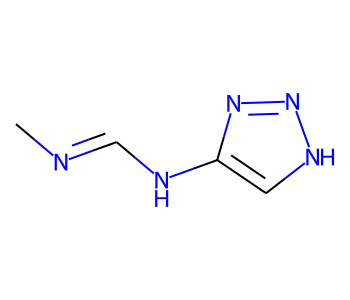

168 C#CC1(C)CCC(C)C1


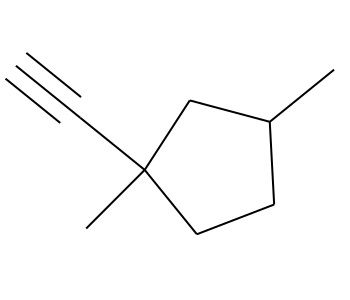

169 Nc1[nH]nc2ncoc12


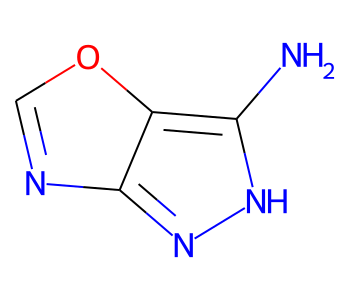

170 CC1(C#N)OCCO1


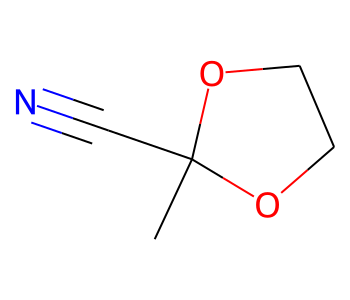

171 CCC(O)CC(=O)NC


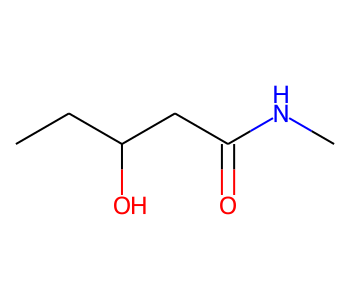

172 CCC1CNC(C=O)=N1


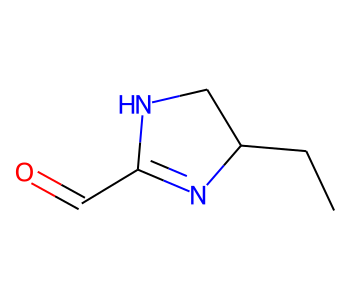

173 CC(C)(C#N)OCCO


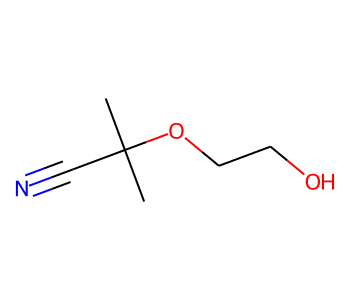

174 CC1=CCC2OCC1O2


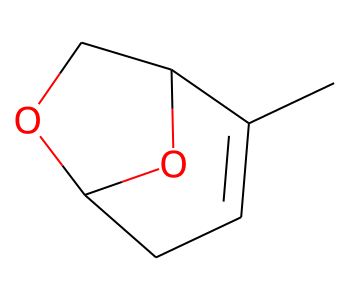

175 NC(=O)c1ncc[nH]1


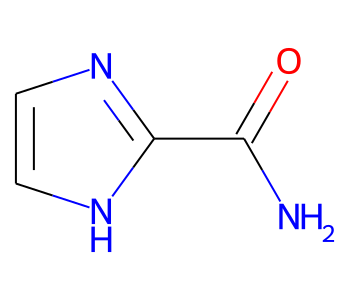

176 CCC1OCC(C)C1O


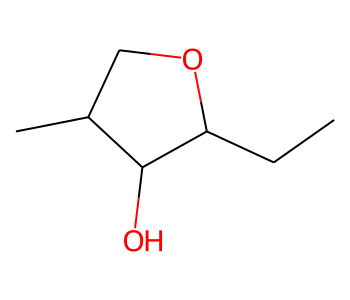

177 Cc1cc(CC#N)n[nH]1


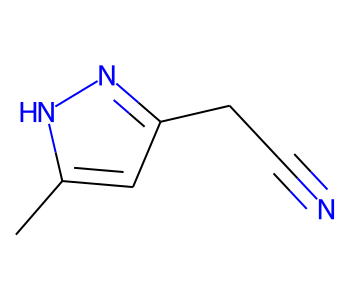

178 CC1CCCOC(C)O1


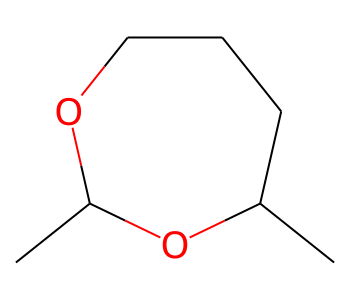

179 CC(C)N=COC(C)C


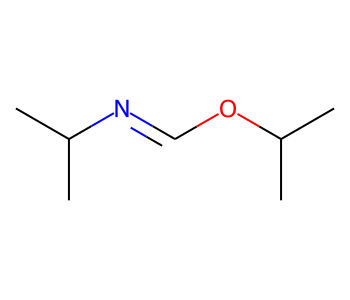

180 CC(O)C(C)OC(N)=O


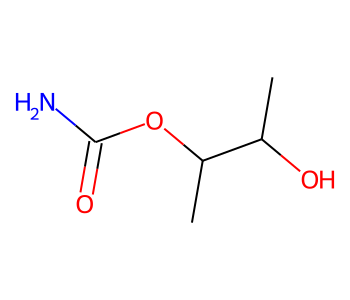

181 C#CC1=CCOC=NC1


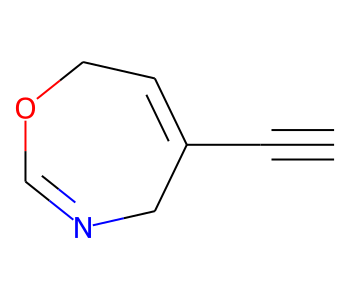

182 C1=CC2C=CC1O2


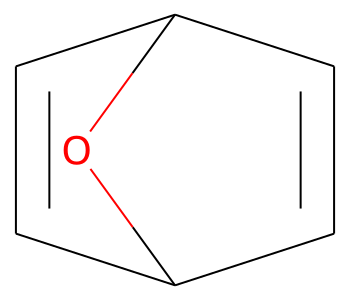

183 N=C1C=C(C=O)C(=N)N1


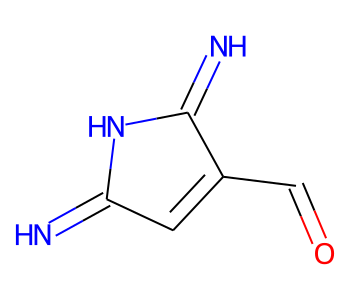

184 O=C(CO)CO


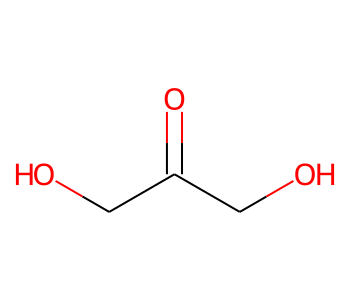

185 O=C1CC2CC1C(=O)N2


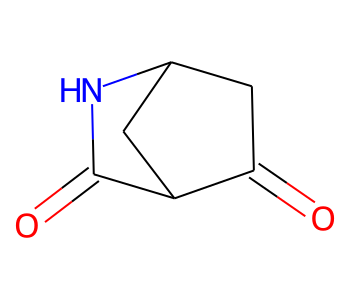

186 CCC1OC(=O)OC1C


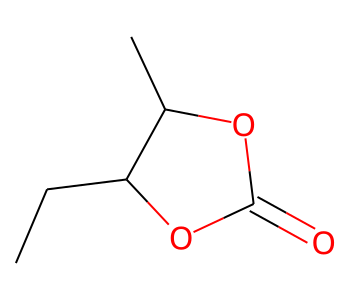

187 Oc1cnc(O)c(O)n1


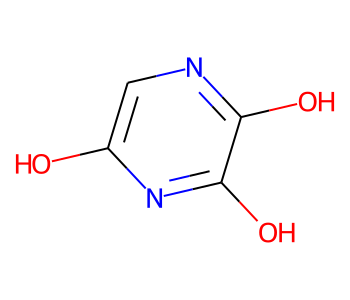

188 c1cn2nccc2cn1


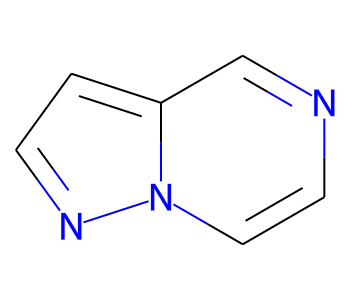

189 CC(C)C(O)CCC#N


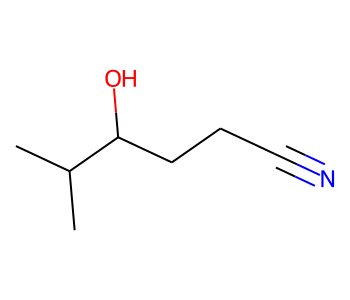

190 CCCC1CC(C)CO1


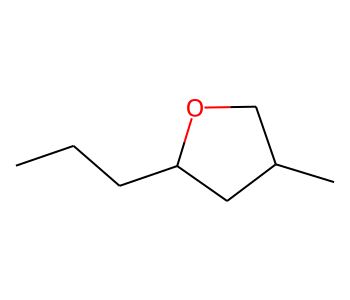

191 CC1=CCC=CC(O)C1


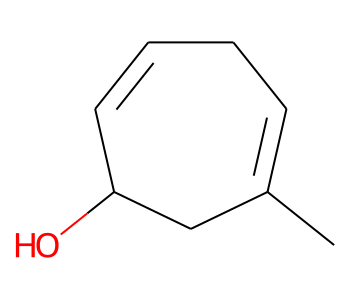

192 Cc1ccncc(=O)n1


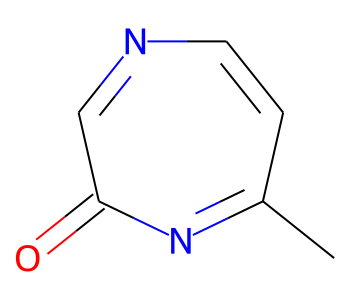

193 Nc1ncc(=O)[nH]n1


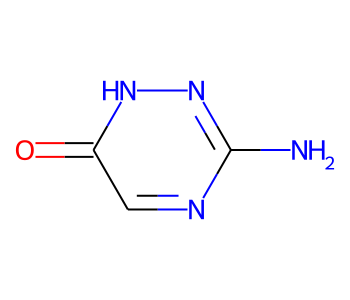

194 N=C1NCCC=CC1=O


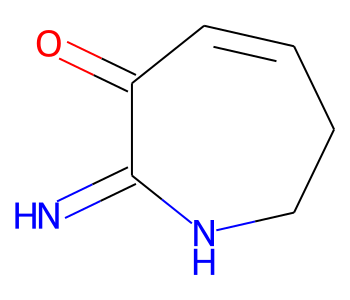

195 OCC1OCC(O)C1O


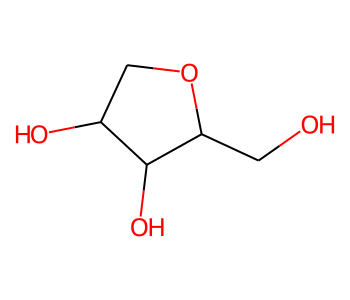

196 C#CCn1nncc1N


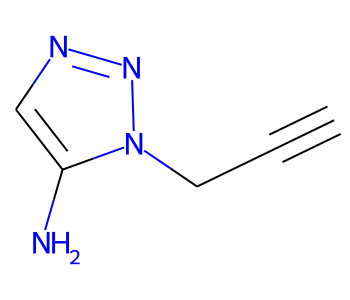

197 N#CC1C(=N)NCC1=O


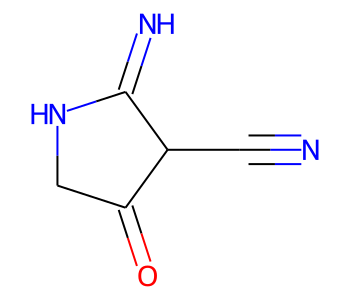

198 C#CC#CC(C)(C)CC


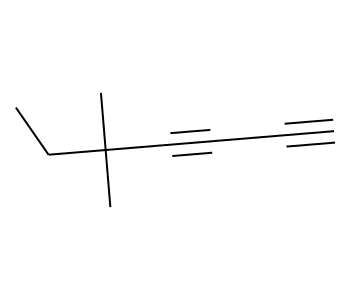

199 N=COCCC#CC=O


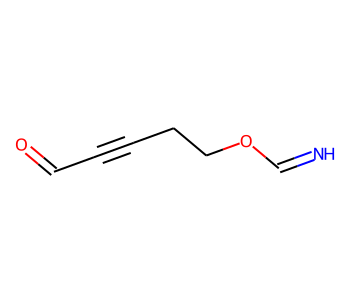

200 CCCC(CO)COC


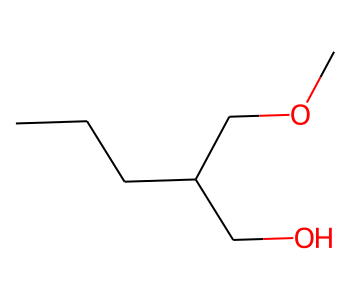

201 CCC(C=O)C(=O)CO


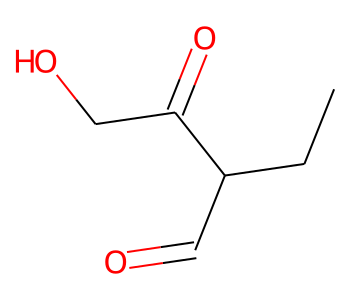

202 OC1CCc2conc21


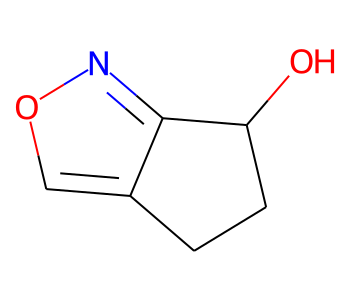

203 CC(C)(O)c1ncon1


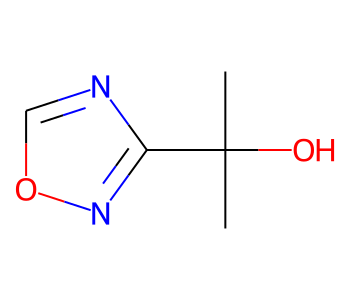

204 COCc1cc[nH]c1N


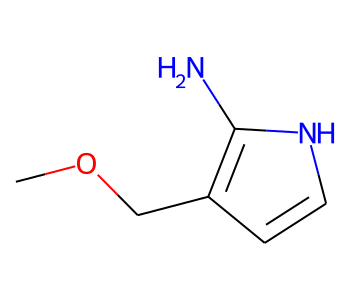

205 Cc1nccn1C


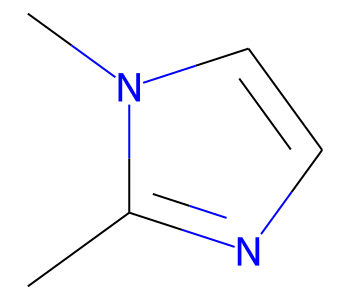

206 CCC1NCC(O)C1=O


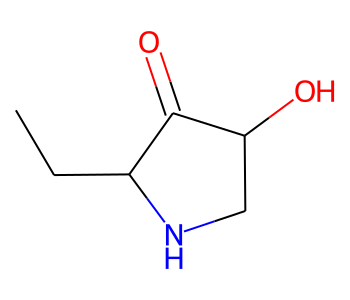

207 Cc1ncc(CO)o1


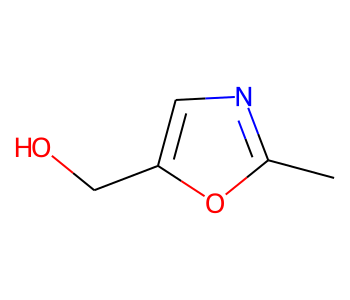

208 CC(=O)C1COC(=O)N1


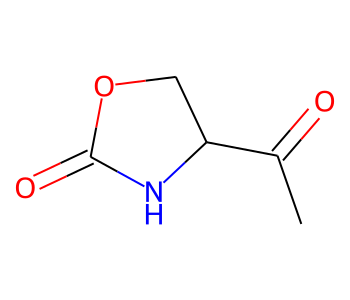

209 Cc1cccc(CO)c1


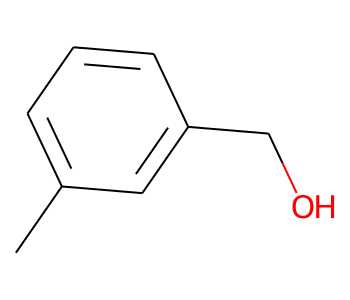

210 CC(C)(C)OCC#N


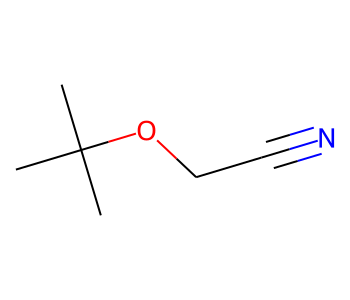

211 CC(C#N)OC(N)=O


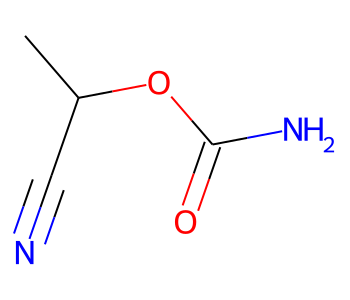

212 Oc1c[nH]c2[nH]nnc12


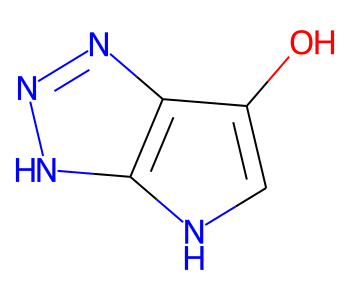

213 Cc1noc(CO)c1N


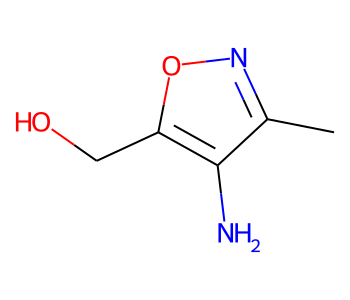

214 N#CC(=O)COC(N)=O


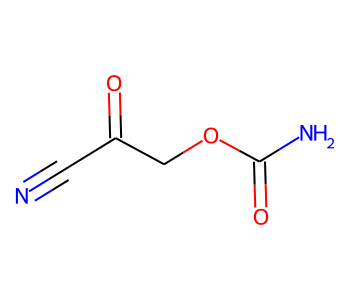

215 CC1C=CC(=NO)CO1


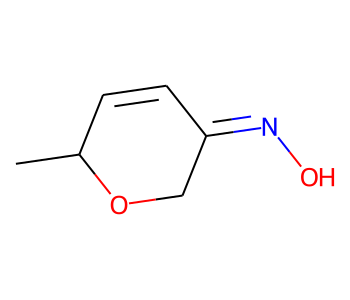

216 N#CC1COCC1=O


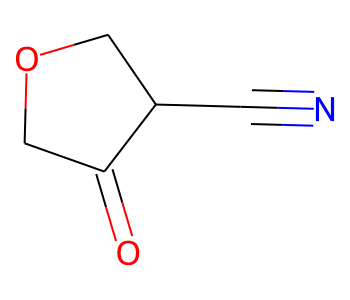

217 C1=CC=CCC=CC=C1


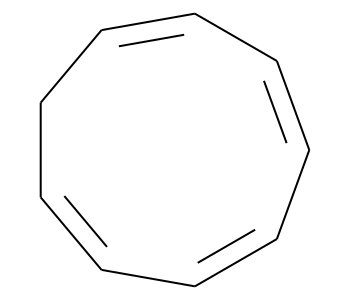

218 N#CCCc1ncno1


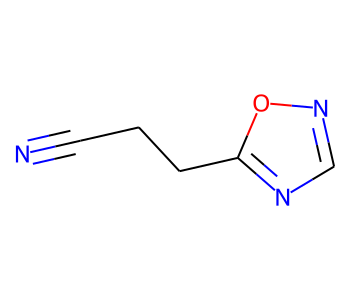

219 O=CC1CC=CC1=O


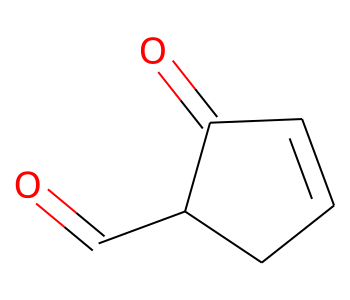

220 CC1=CC(C#N)OC1C


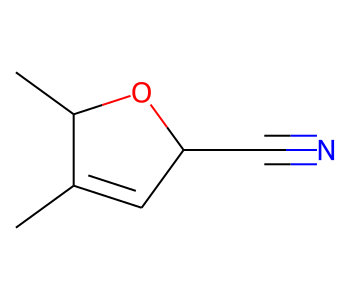

221 N#CC1=CC(=O)C(O)C1


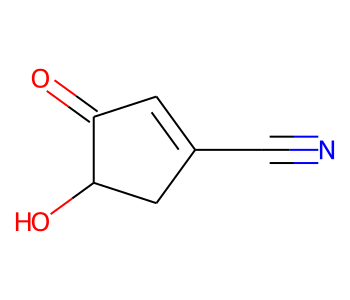

222 C#CC#CC(C)=O


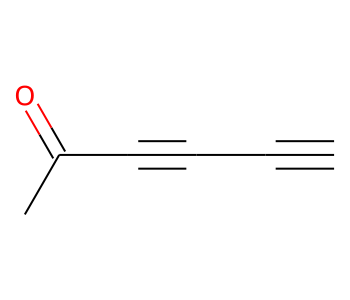

223 Cc1occ(N)c1C


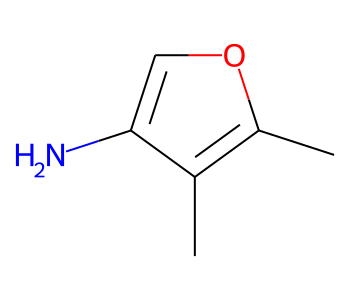

224 O=CC1=CNCC1


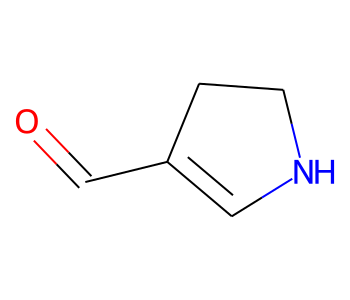

225 CNc1c(O)n[nH]c1C


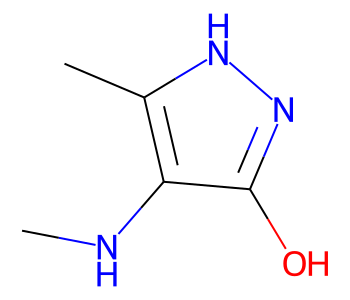

226 COC(C#N)C(C)O


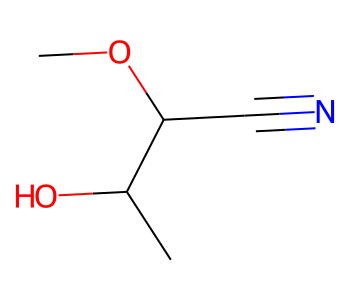

227 COc1cnn(C)c1N


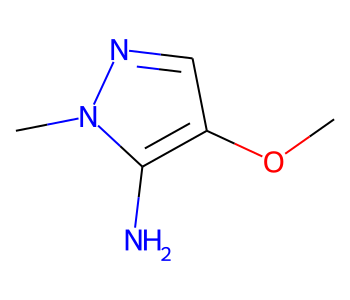

228 N=c1cc(F)nc(N)o1


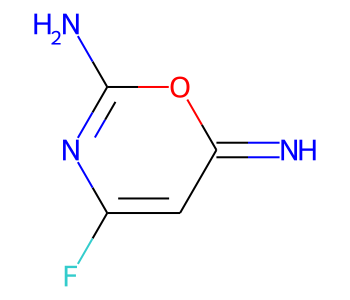

229 O=C1NCC2CN=CN12


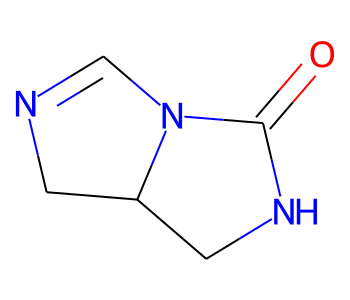

230 CC(=O)Cc1ncc[nH]1


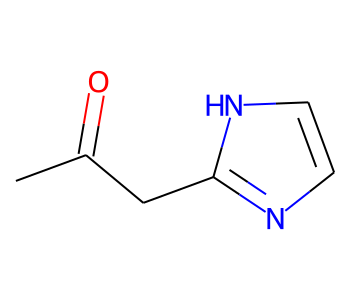

231 CC(=N)OCC(=O)CO


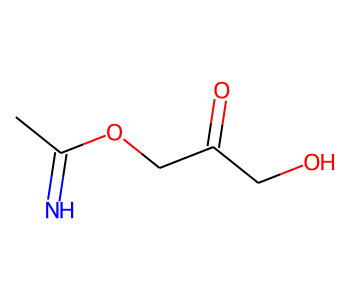

232 N=c1ccoccc1=O


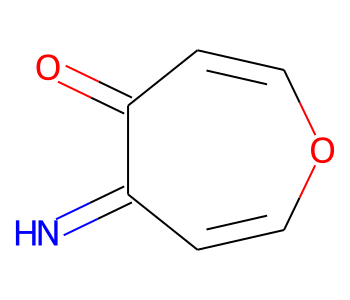

233 N#CCNCCC=O


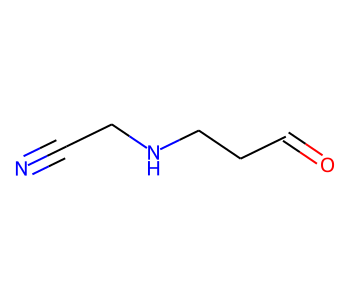

234 C#Cc1n[nH]nc1OC


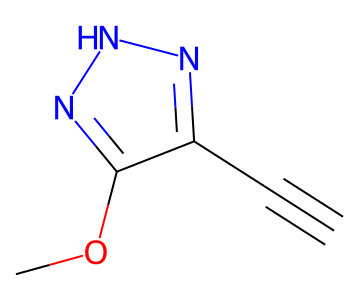

235 CC1C(=NO)C=CN1C


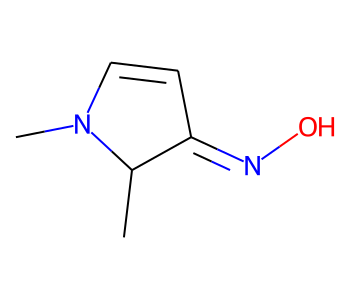

236 Cc1nn(C)nc1N


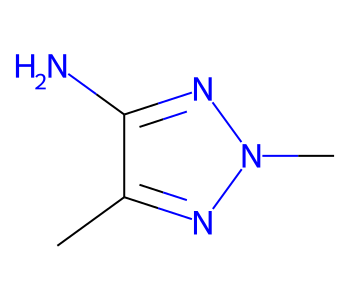

237 CNc1n[nH]cc1C=O


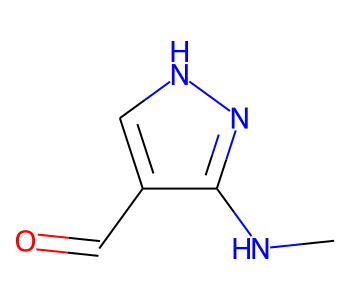

238 CC(C)c1cc(N)on1


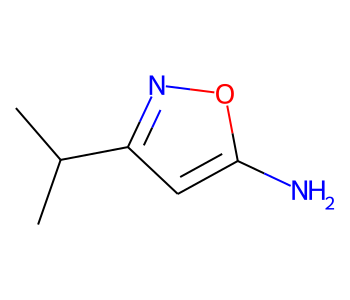

239 CC1Cc2nocc2O1


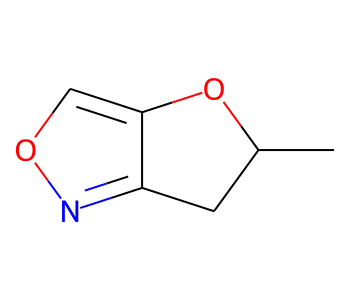

240 N#CC(=O)c1ccco1


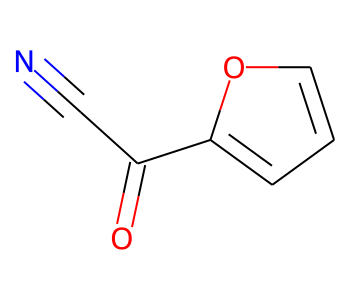

241 CC1=CC(C)(O)C(=O)N1


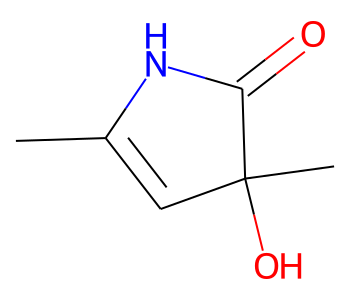

242 CCC(C)C(C)=NO


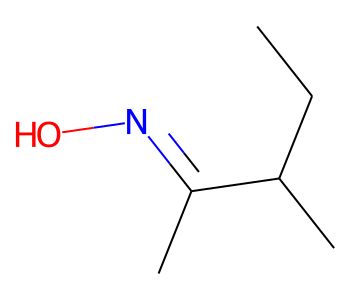

243 C1COC2=NCCC2C1


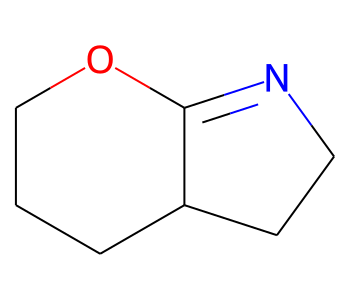

244 Cn1c(C=O)c[nH]c1=O


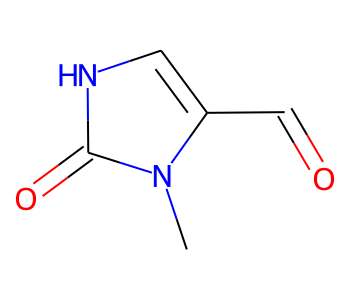

245 CNc1coc(=N)cn1


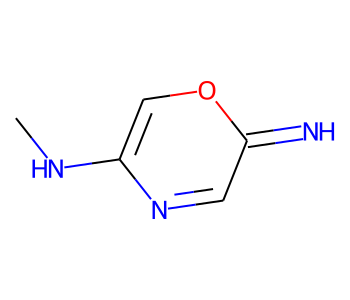

246 CCn1cc(NC)cn1


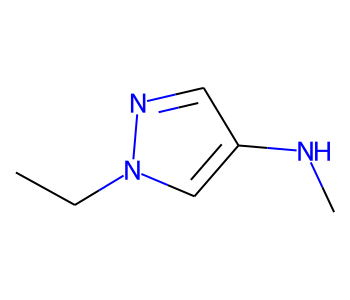

247 N=c1ncc(=N)[nH]nn1


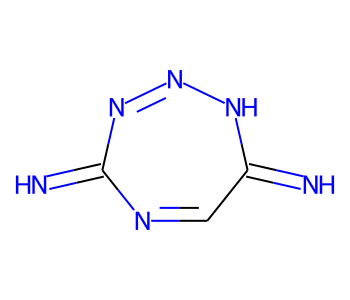

248 C#Cc1cc(NC)co1


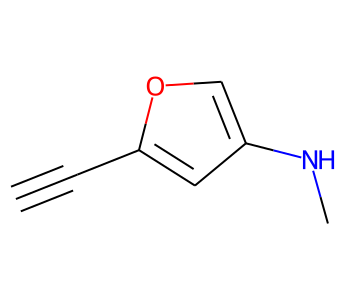

249 CCOCC(O)C(N)=O


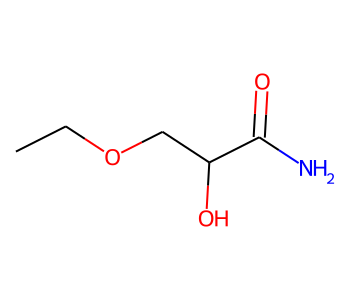

250 Nc1c[nH]c2oncc12


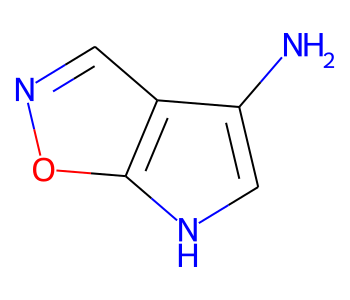

251 CC(C)(C=O)CC(N)=O


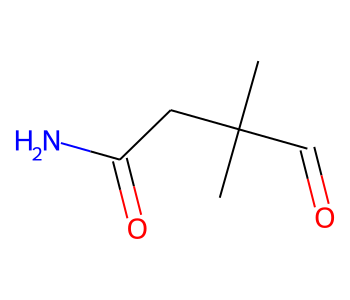

252 O=CCNc1c[nH]cn1


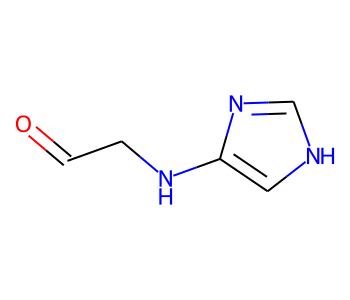

253 C#CC(C)(C)C#C


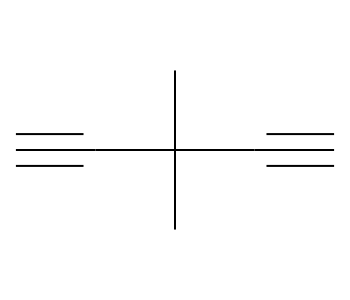

254 CCC12CCC(CC1)C2


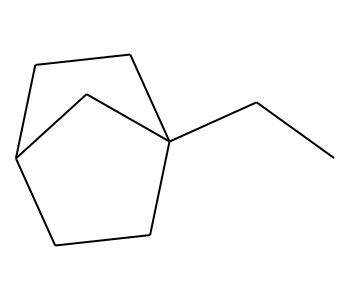

255 CC1CN(C)C(C#N)=N1


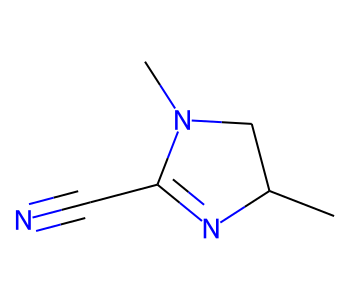

256 CCn1cccc1


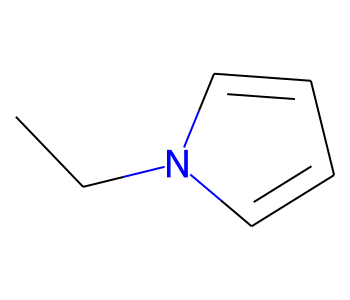

257 O=C1CCC=CC(O)C1


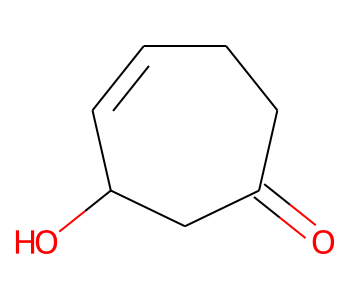

258 CCOC(C)(C)C#N


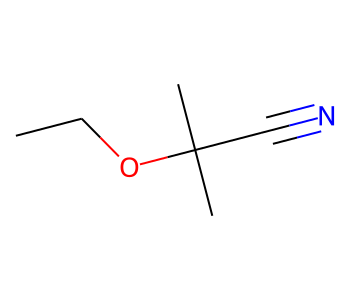

259 COCC(OC)C(C)C


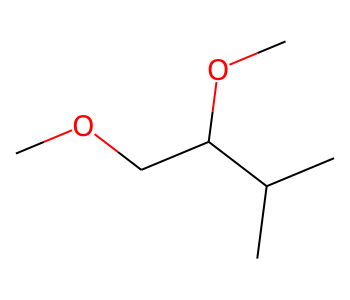

260 CCc1[nH]nnc1O


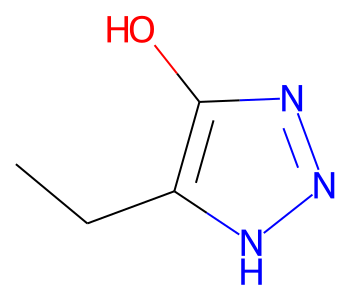

261 CC1=NC(C)C(C=O)O1


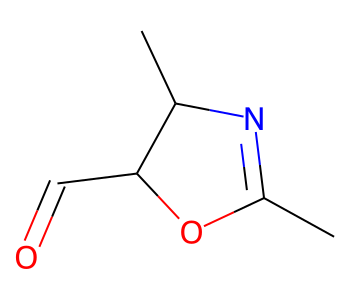

262 N#CC1CC(=O)C(=O)O1


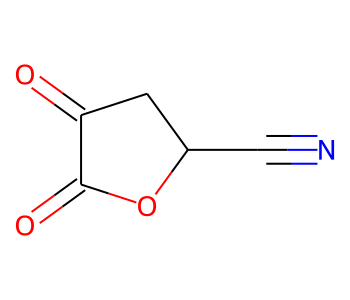

263 O=C1CCc2nc[nH]c21


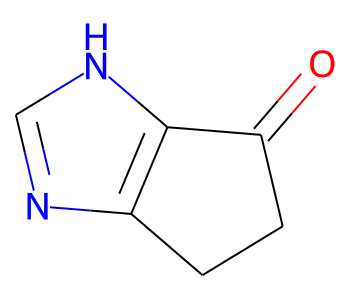

264 CC(=O)CC(C)(C)C


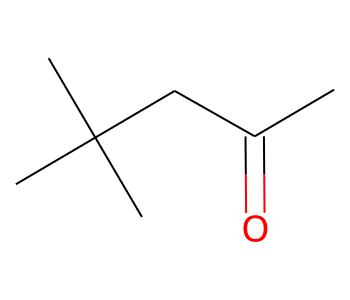

265 C#CCC(=O)OC=NC


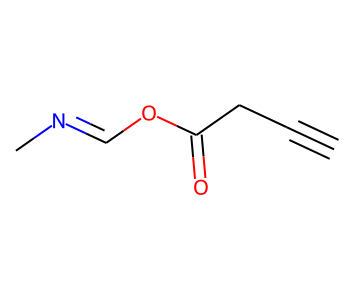

266 Nc1onnc1O


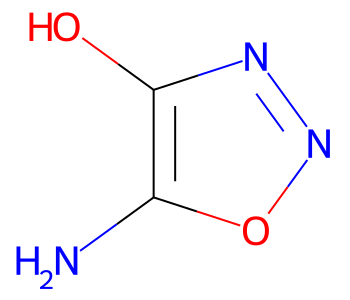

267 CCC1C=CC(O)CC1


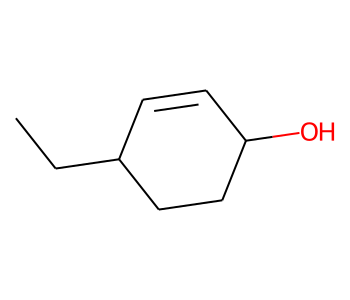

268 N#Cc1c[nH]c(C=O)c1


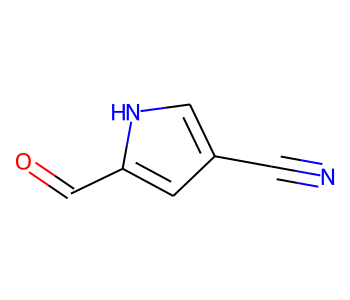

269 CCn1nc(C)c(O)n1


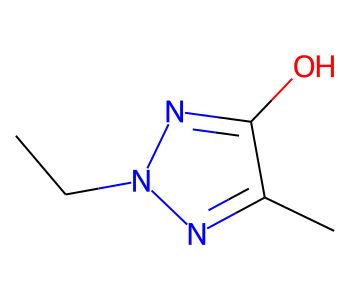

270 Cc1coc(C(C)C)n1


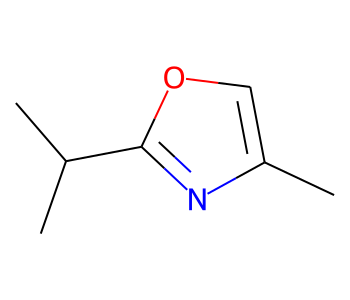

271 CCCCC(=O)C(C)C


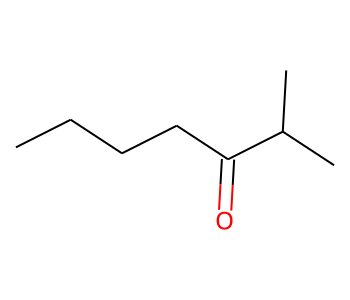

272 N=CNc1c[nH]cc1O


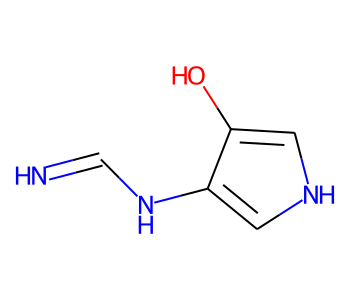

273 Nc1nc(O)cc(O)n1


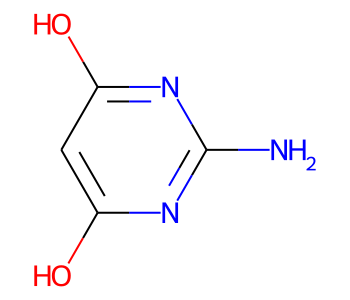

274 CN=COC(=O)N(C)C


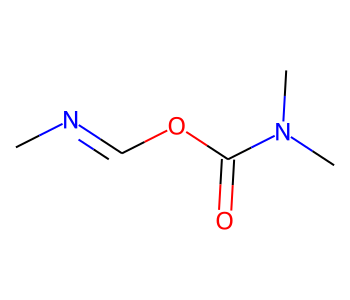

275 CNC=NC(C=O)C=O


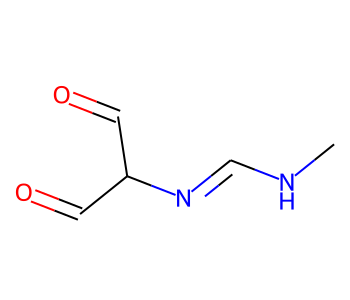

276 NC1CC(O)COC1=O


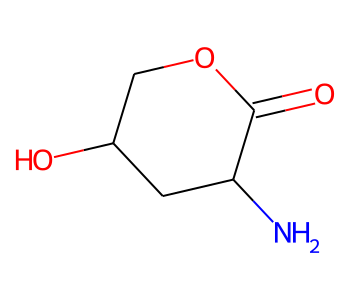

277 CC(C)(C)OC(=O)CN


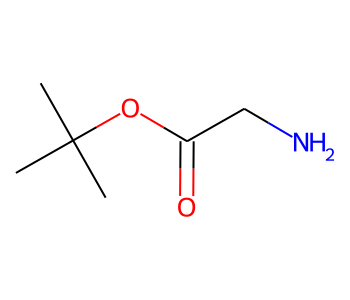

278 CC(=O)C1=NCCCN1


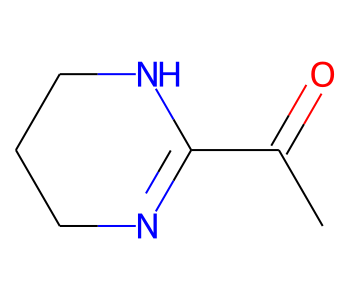

279 N#CC(C=O)CCC=O


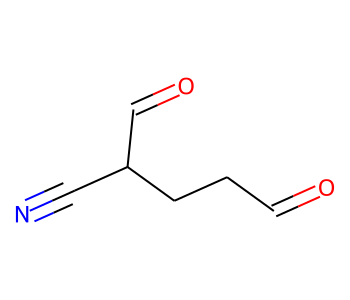

280 CC(C=O)N=COC=O


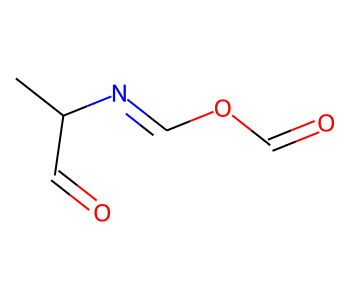

281 c1nc2nconc-2n1


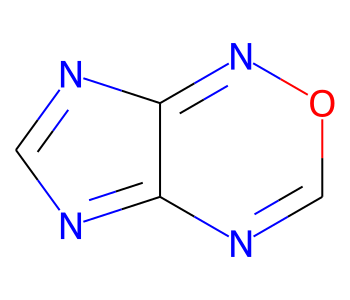

282 NC(=O)c1cc(N)[nH]n1


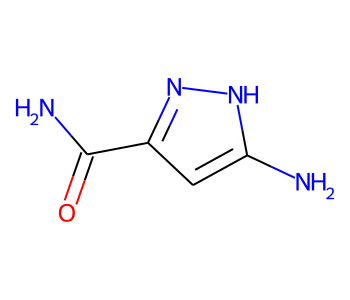

283 CNc1cc(O)c(C)o1


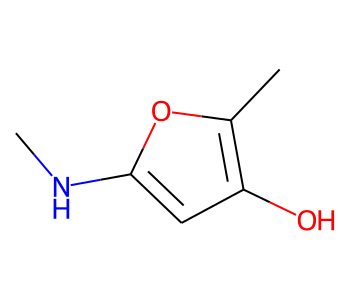

284 CC1(O)CCOC1=N


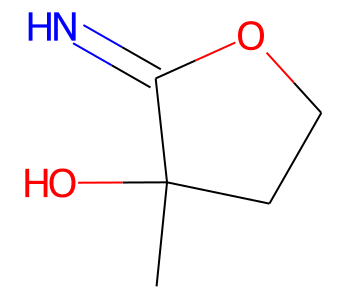

285 CC(C)CN=C(N)C#N


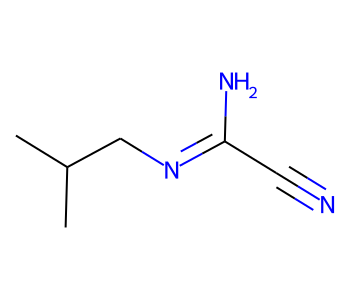

286 C#CCN(C=N)C(C)=O


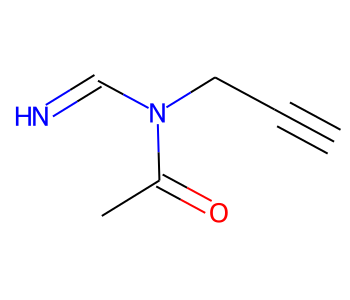

287 Cc1c[nH]cnc1=O


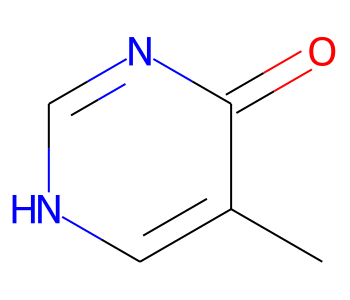

288 O=c1[nH]c2c(o1)OCO2


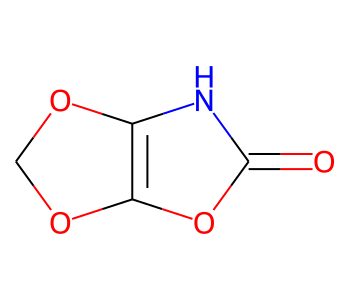

289 CC(O)CC(C)(O)C=O


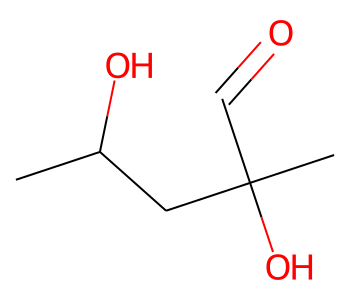

290 CC(C)C(C#N)CO


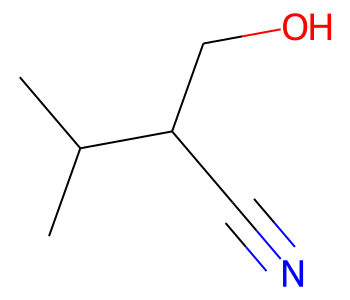

291 CC1(C#N)COC(=N)N1


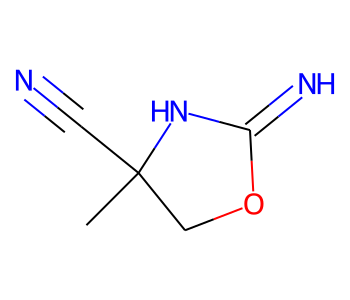

292 CCCc1nocc1C


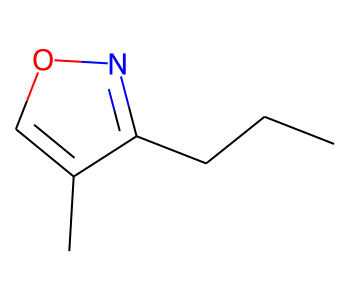

293 CC1=CCCCC(=O)C1


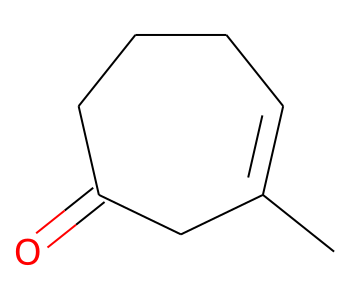

294 Cc1cnc(=N)oc1N


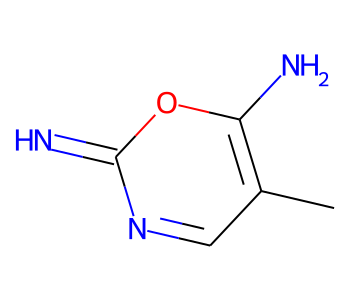

295 CC#CC1NCCC1=O


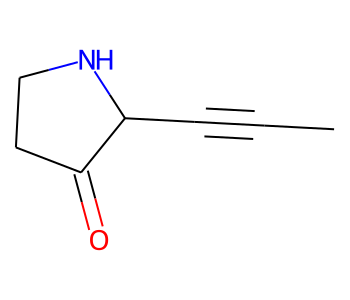

296 O=CC1C=CN(C=O)C1


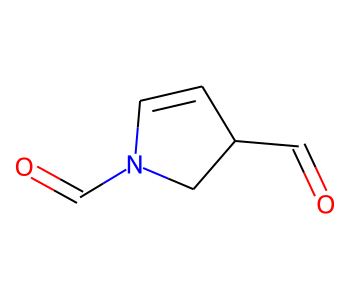

297 N#Cc1[nH]ccc1O


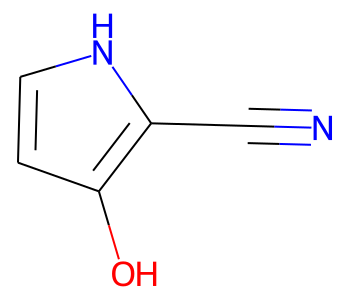

298 CC12C=CC(CC1=O)O2


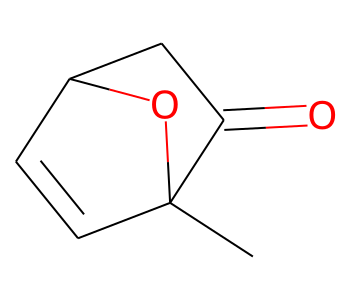

299 O=C1C2CCCC1OC2


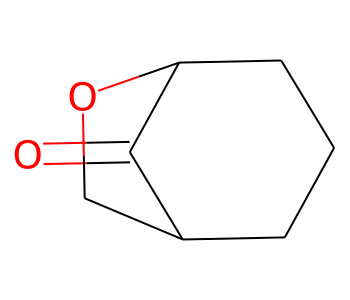

300 N=C1OC(=O)OC1CO


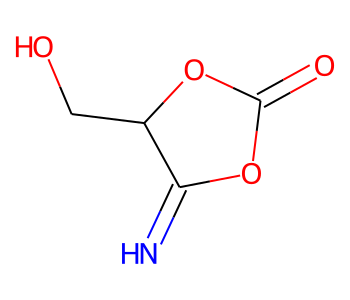

301 CC(C)C#CC(=O)CO


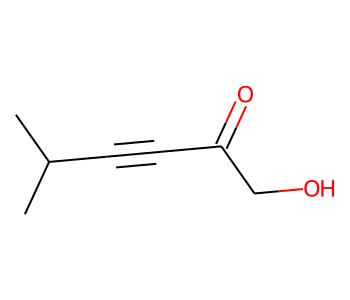

302 c1noc2c1CCCO2


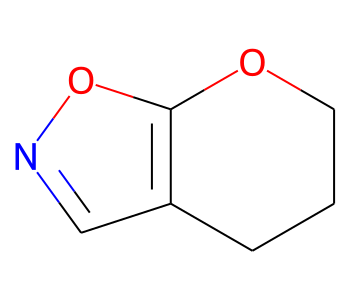

303 N#CCOC1C=CCO1


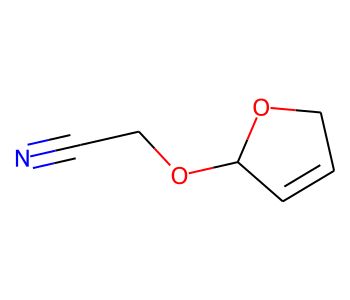

304 O=C1C=Cn2cncc21


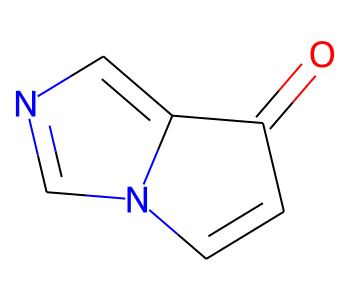

305 CC12COC(CO1)OC2


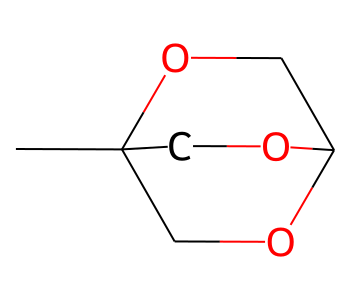

306 O=C1NC=CC1CCO


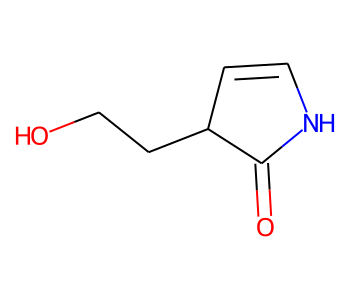

307 CCN=C(C#N)NC=N


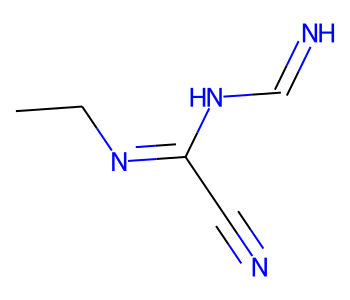

308 CC1CCCC1(O)CO


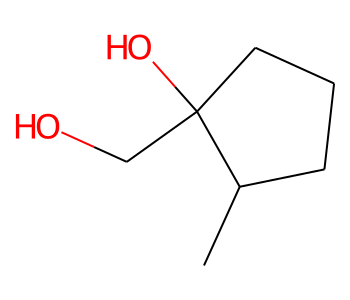

309 CC(C)CC(C)(O)C#N


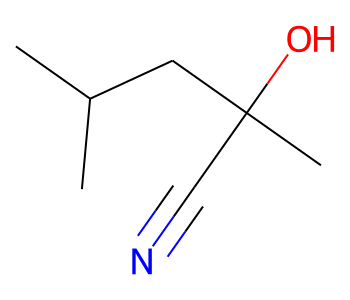

310 COC=NCCCO


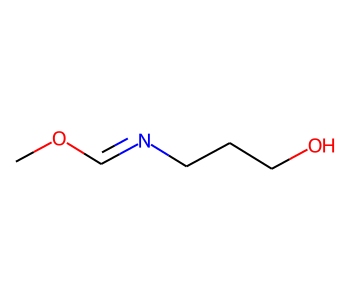

311 CC(O)CCC(O)C#N


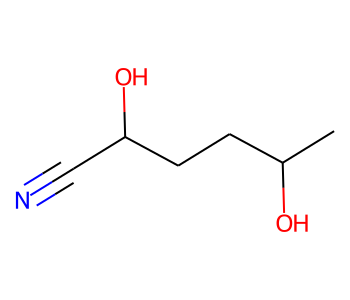

312 N#Cc1cnn(C=O)n1


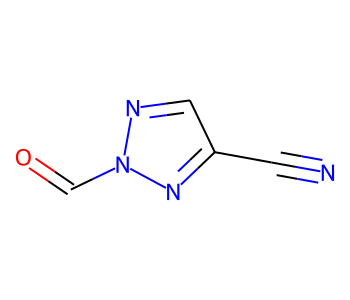

313 CC1CCCCCC1


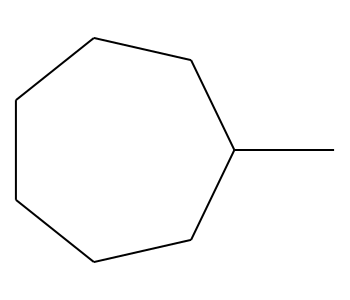

314 O=c1cnccnc1


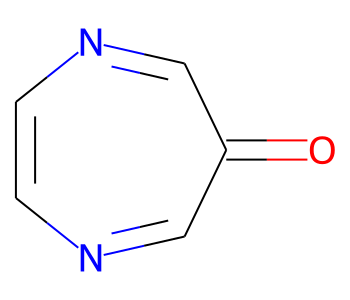

315 C#CC1CCCC1C=O


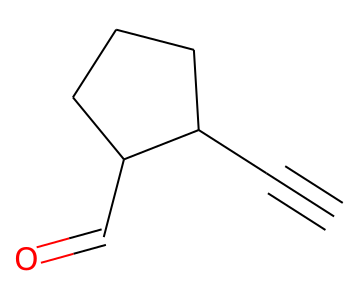

316 CCC(O)(C#N)C#N


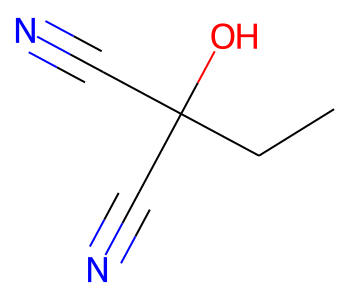

317 C#CC#CC#C


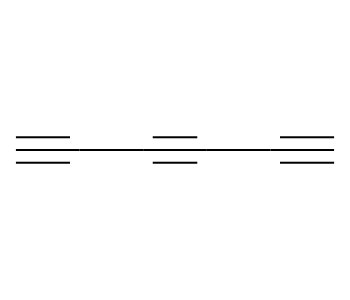

318 CCC1C=CCC1C


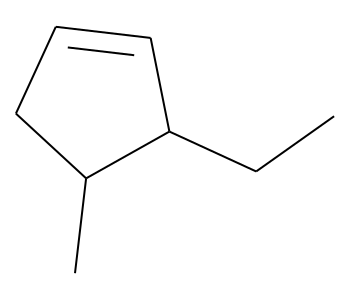

319 CCC1CCC(CC)O1


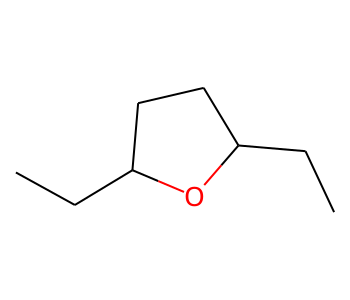

320 COc1cc(N)[nH]c1N


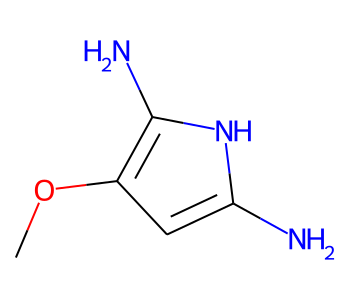

321 COC1OCCNC1=N


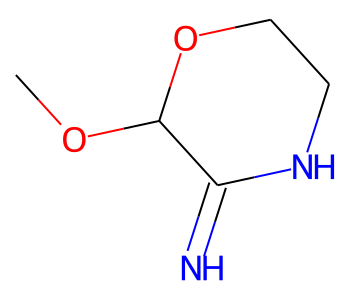

322 N=c1oc(O)cnc1O


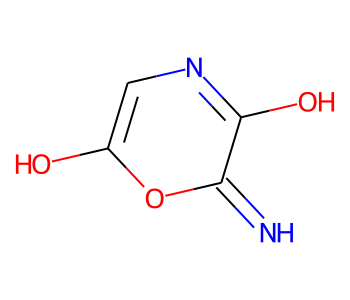

323 O=CNCC1=CCCC1


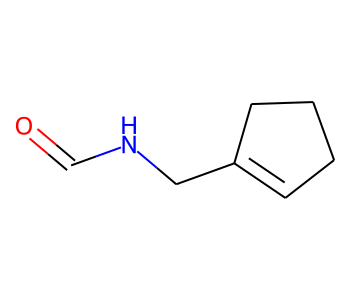

324 COC1OCCCC1=O


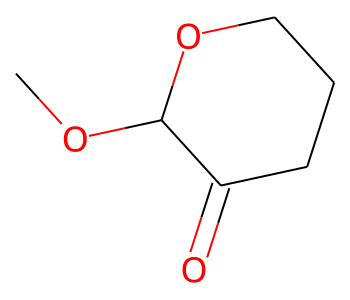

325 CC(C)CC(C)(O)C=O


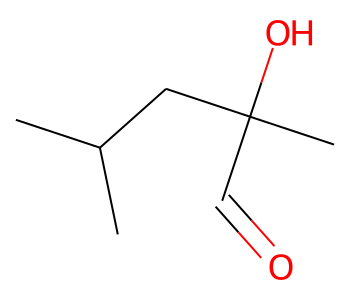

326 N#CC1NCC(=O)C1O


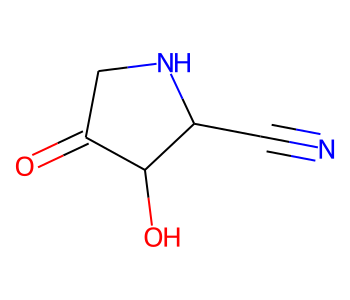

327 CC1CCC(=O)CC1=O


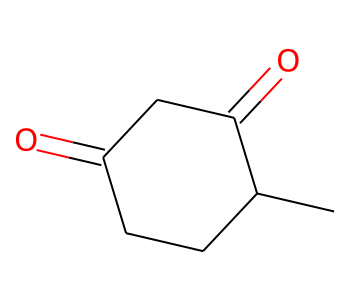

328 C#CC1=CC(C#C)CC1


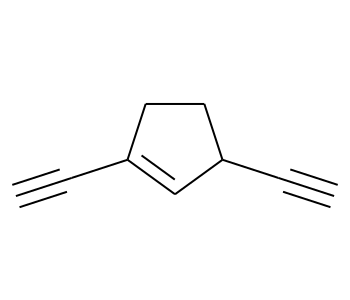

329 N=C1OCCC1CCO


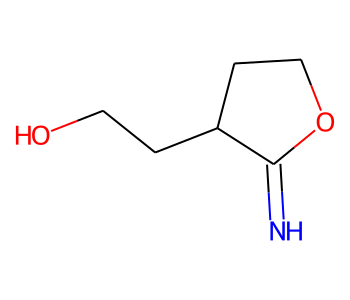

330 O=c1ncccnc1O


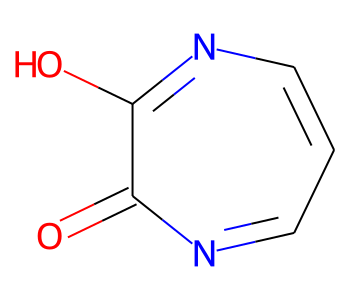

331 N#CC12C=CC(OC1)O2


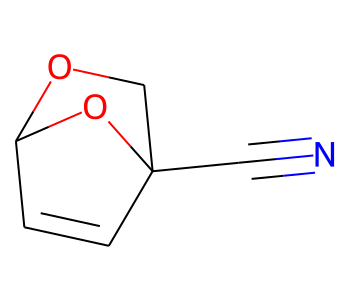

332 CC#Cc1ccn[nH]1


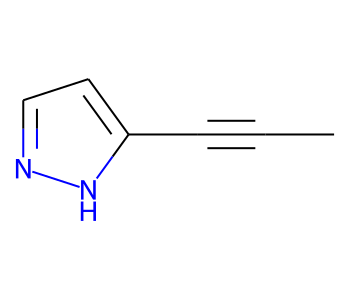

333 C#CC1COC(CC)C1


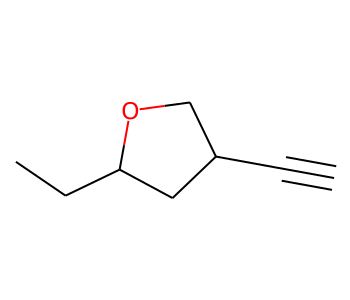

334 OCCOCC(O)CO


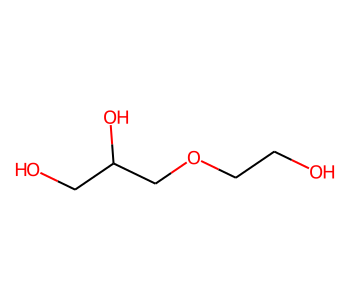

335 N=C1CN=COCO1


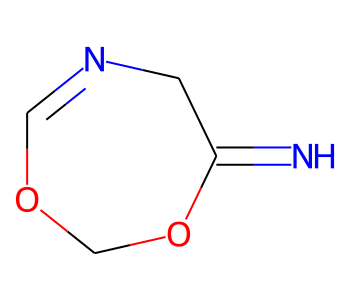

336 CCOC(=O)NCC#N


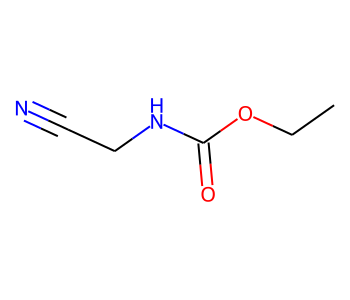

337 C#CC1(C#N)COCO1


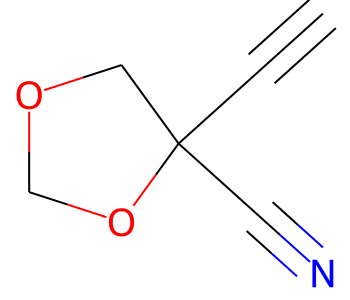

338 O=c1ccocc1O


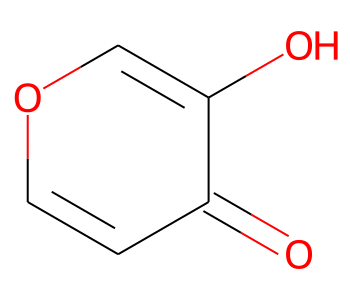

339 CCC1=C(CO)CCC1


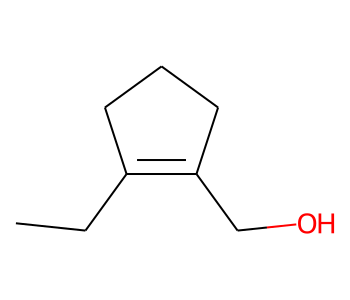

340 c1ncc2nc[nH]c2n1


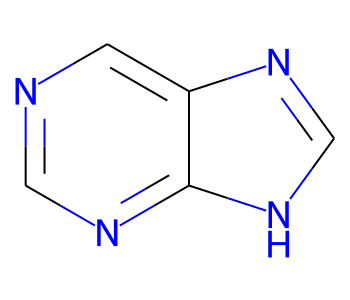

341 C#CC(N)(C#N)CN


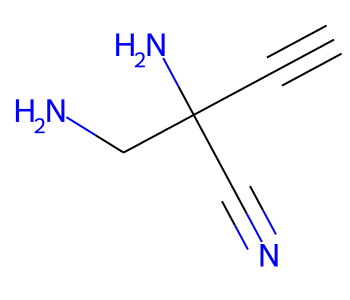

342 C#CC1CCCC1


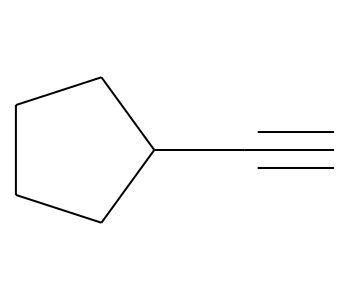

343 O=C(CO)c1ncc[nH]1


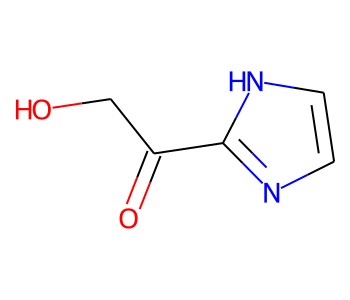

344 NC(=O)n1cnnc1


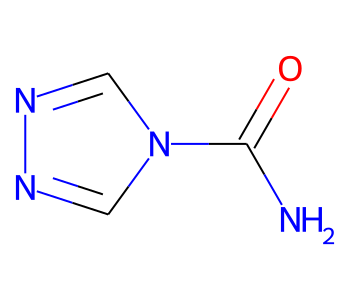

345 N=c1oncc(N)c1N


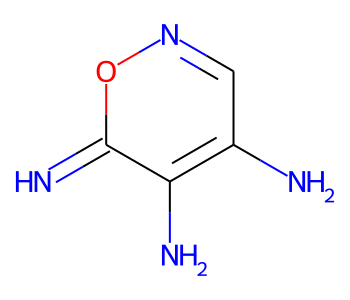

346 O=CC1=CCCNC1=O


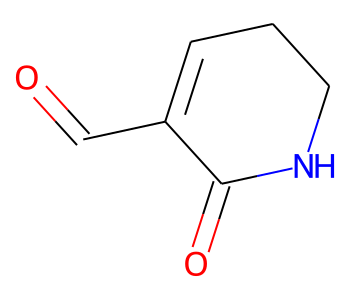

347 O=CCOc1nnon1


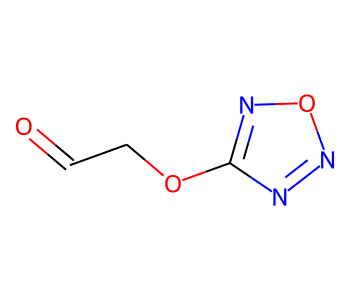

348 C1=CC2CCCC1CC2


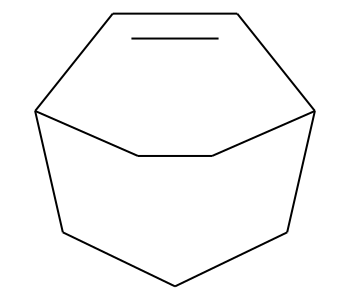

349 C#CCC(C=O)C(C)C


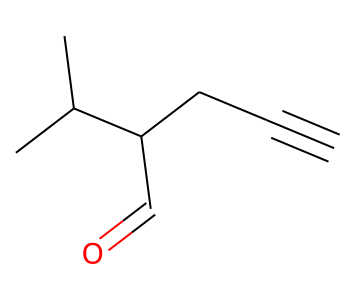

350 NC(=O)COCC(N)=O


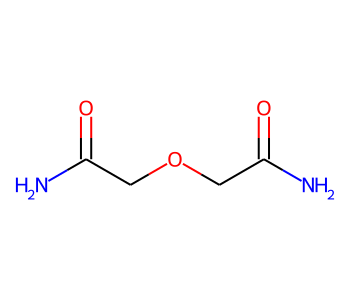

351 Cc1nn(C=O)nc1N


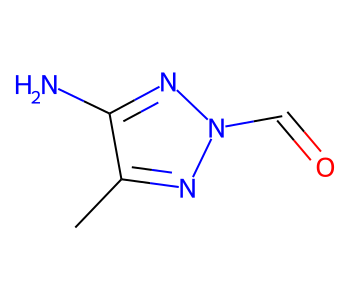

352 CC(C)OCC#CC#N


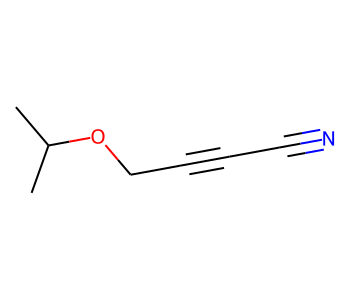

353 C#CC1COC(C)C1


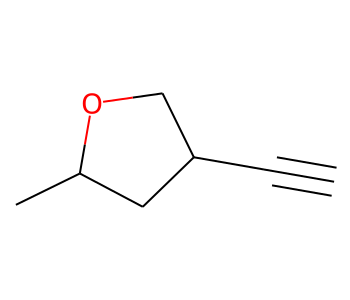

354 Nc1nc(N)oc(=O)n1


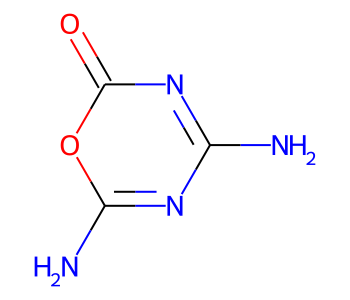

355 Nc1ccc(F)[nH]c1=O


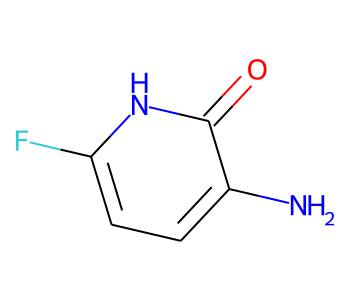

356 CC1CCC(C=O)CO1


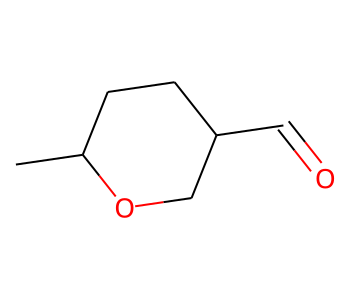

357 Cn1nc[nH]c(=N)c1=O


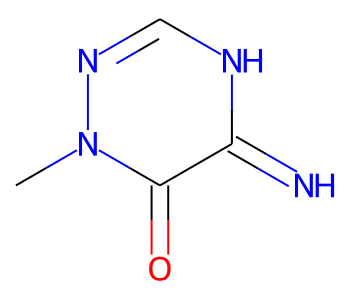

358 OCC1=CC=CCOC1


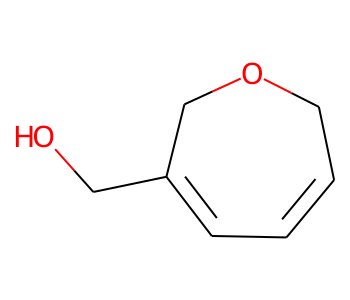

359 COc1c(N)nnn1C


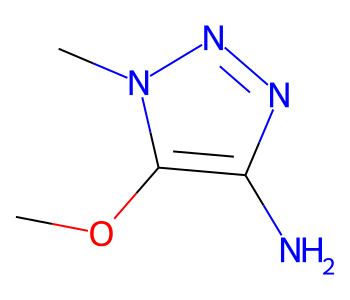

360 COC(C)(C#N)CO


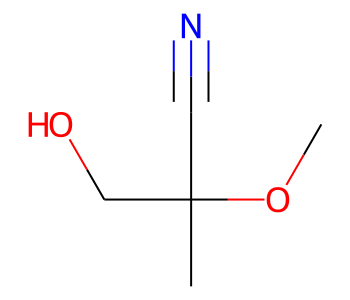

361 Cc1cncc(C)n1


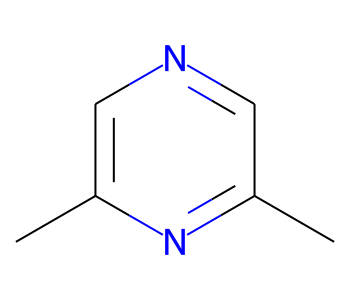

362 C#CC(CC)C(=O)C#N


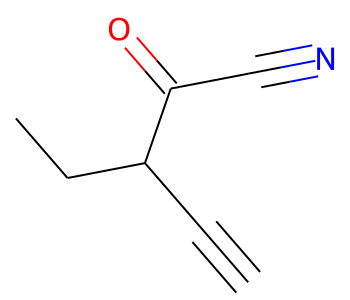

363 CC1=CCN(C=O)C1=N


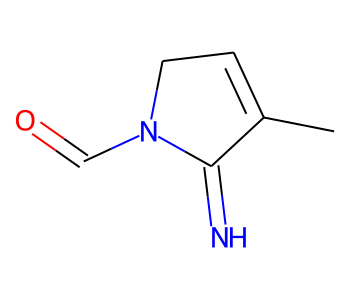

364 CCC(C)C(O)C=O


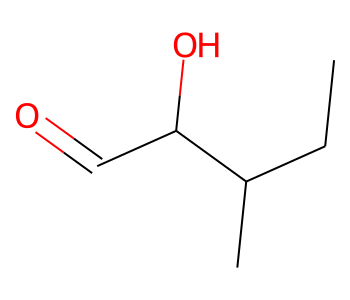

365 CNc1cn[nH]c1NC


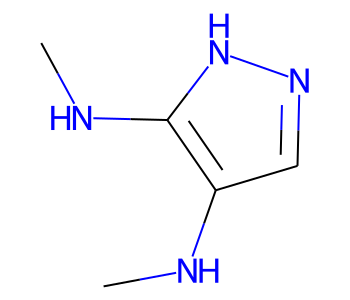

366 C1=NCc2c[nH]cc2N1


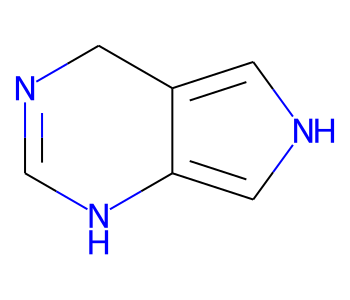

367 CC1CC=CC(C#N)C1


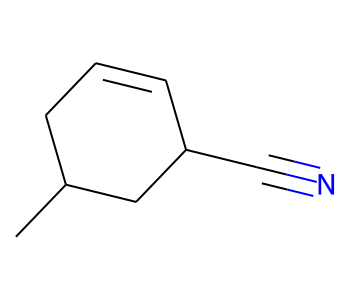

368 O=C1COC(=O)C1O


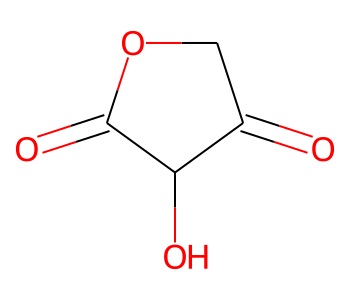

369 CNc1ccn(C=O)n1


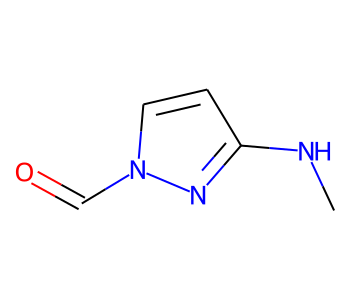

370 Cc1cccnc(=O)c1


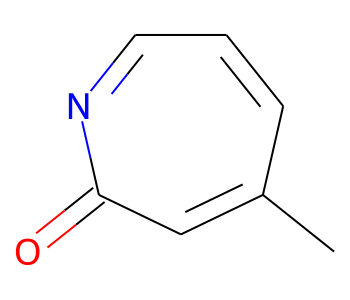

371 CC(C)c1cccnc1


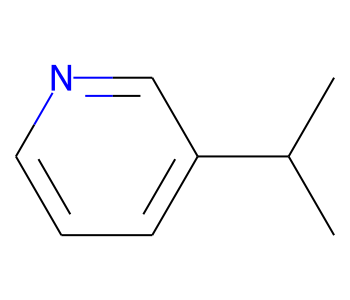

372 N=CNc1ncccn1


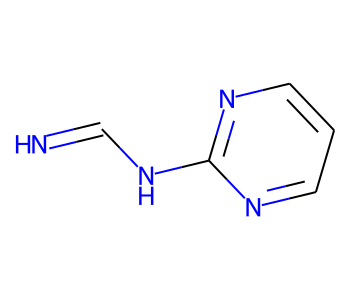

373 N=C1CC(=O)C=CCO1


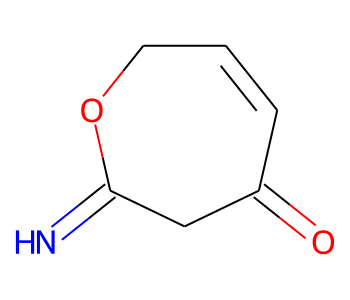

374 N=c1[nH]ncc(O)c1N


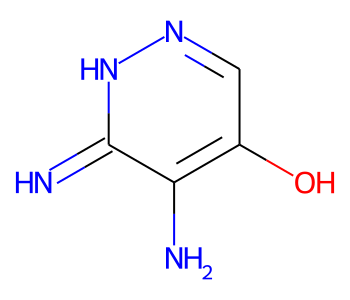

375 CC#CCc1c[nH]cn1


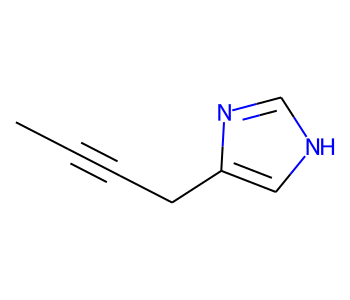

376 COCC(=O)C(C)CO


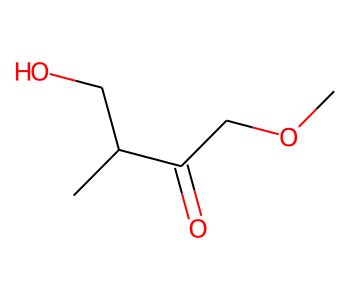

377 CC1=C(N)COC1=O


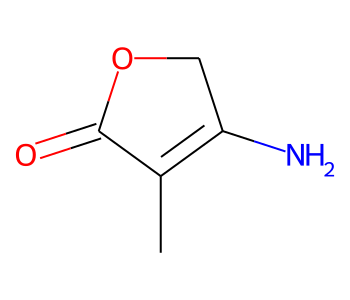

378 CN=CNC(=O)C(C)O


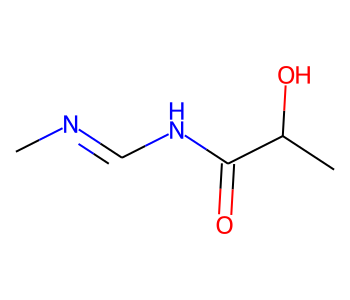

379 C#CC(O)(CC)CCO


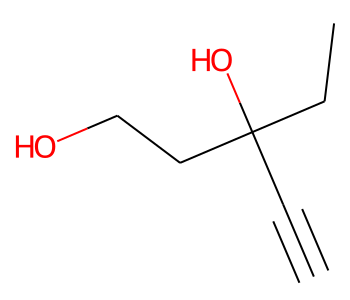

380 N#CCC(=O)OCCO


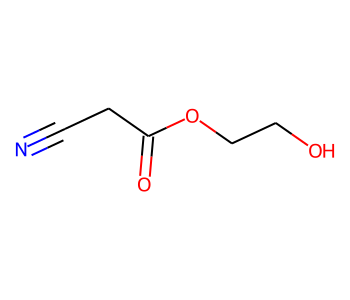

381 CCc1[nH]ncc1NC


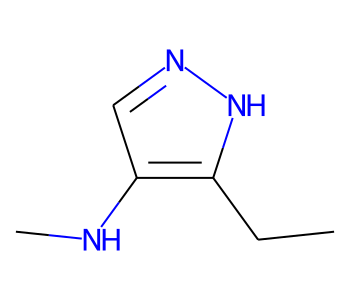

382 Oc1nc2c(o1)OCO2


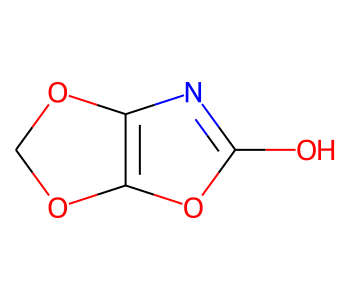

383 CC(C)C1OCC(=N)O1


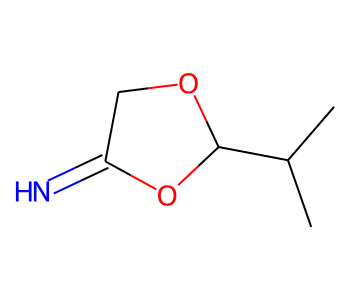

384 CN=C1OCC=C1C=O


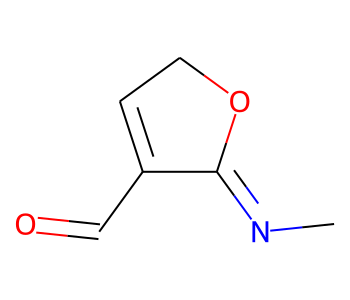

385 OCCc1cocn1


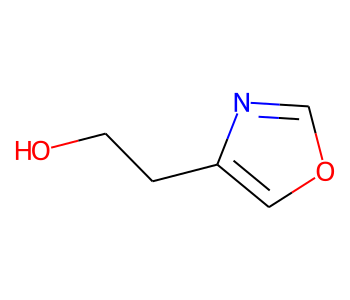

386 N=c1ccc(=O)cco1


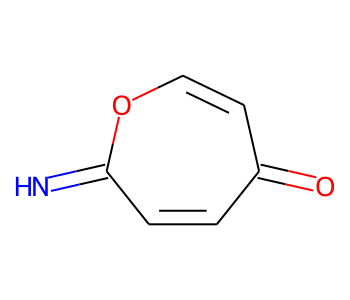

387 N#CC(N)(CO)CO


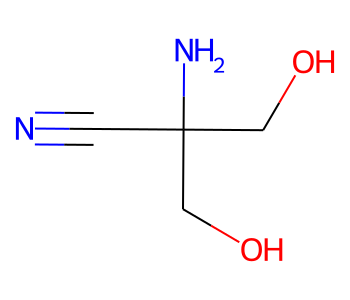

388 CCCC(=O)OCC#N


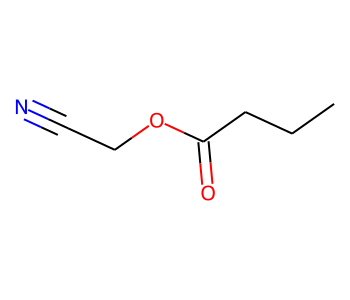

389 Nc1nc(=O)occ1F


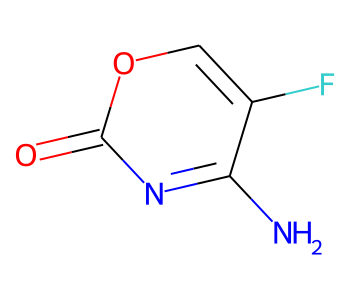

390 Nc1ccccnc1=O


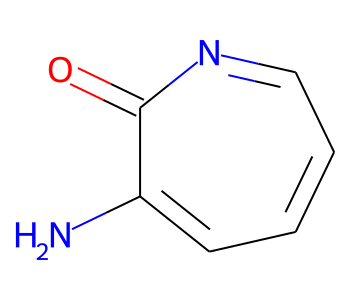

391 O=CN1C=CCOC1=O


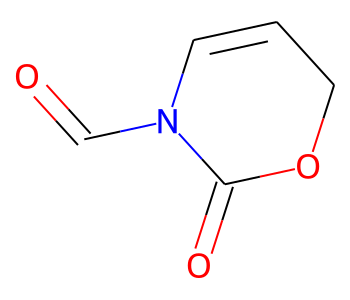

392 COCc1n[nH]nc1O


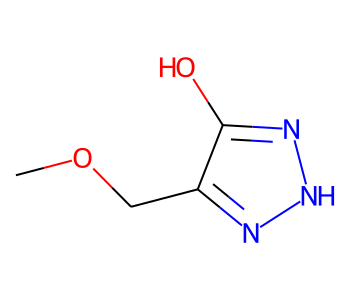

393 N=C1CC(=O)COCO1


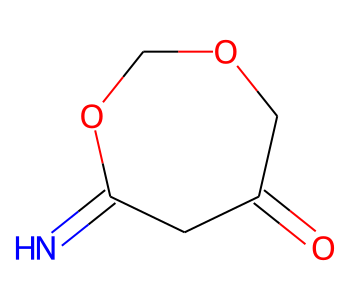

394 N#CC(O)C(CO)CO


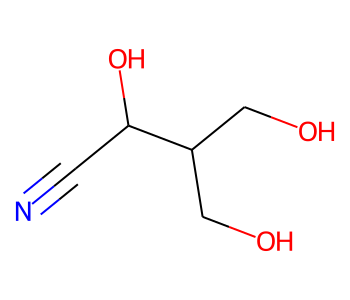

395 O=CCC1=CC(O)CC1


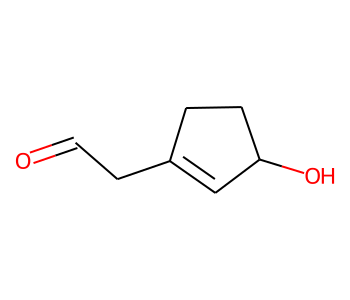

396 N#CCOc1ncc[nH]1


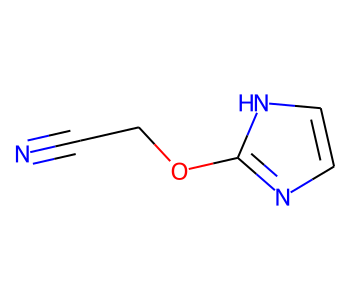

397 C#CC(O)CC(=O)C=O


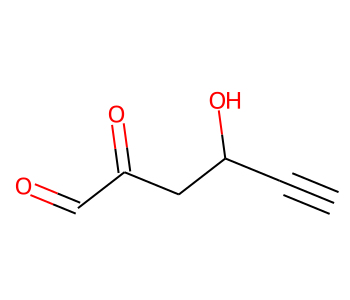

398 Cc1nc2[nH]ccc2[nH]1


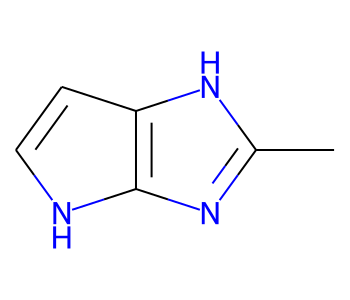

399 CCCC(C)CC


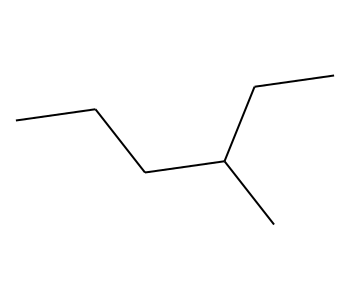

400 CC1OC2CCC1(O)C2


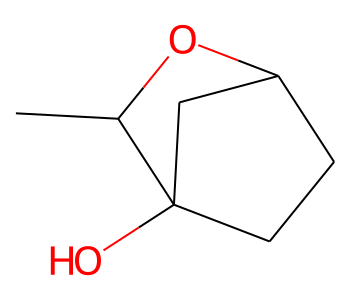

401 CCc1cncc(=O)[nH]1


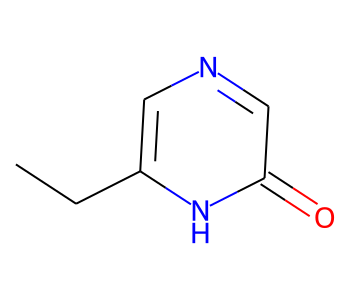

402 C#Cc1cc(=O)nco1


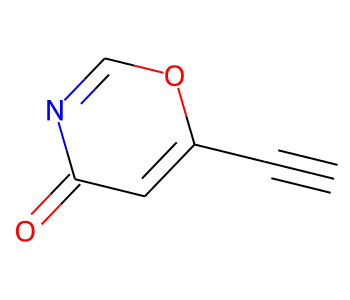

403 CC1CCCNC(=O)C1


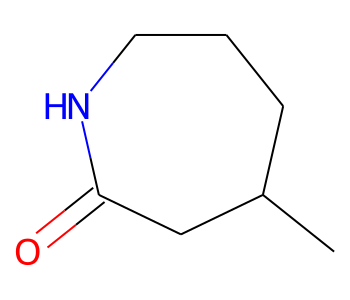

404 CN=CNC(=O)COC


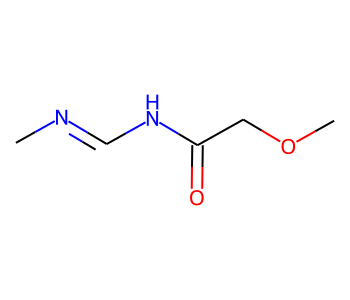

405 CC(N)(CC#N)C(N)=O


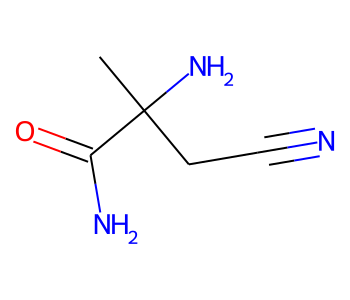

406 C#CC(C)C#CCO


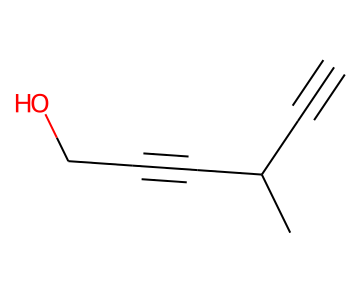

407 OC1C=CC=CCC1


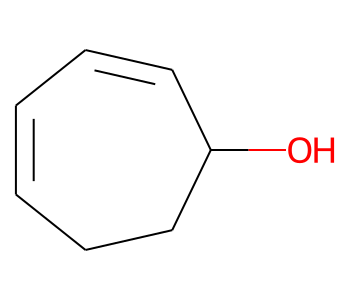

408 Cc1onc2ncoc12


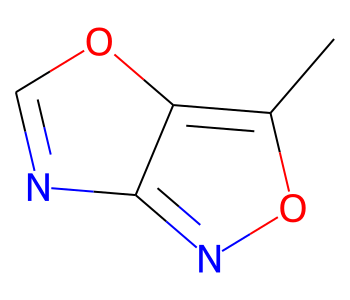

409 CC(C#CC=O)CO


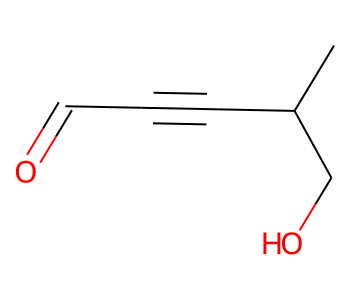

410 Cn1ncc(=O)[nH]c1=N


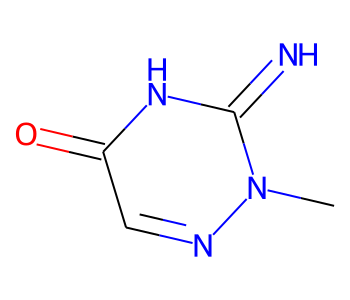

411 CCc1cnoc(=N)n1


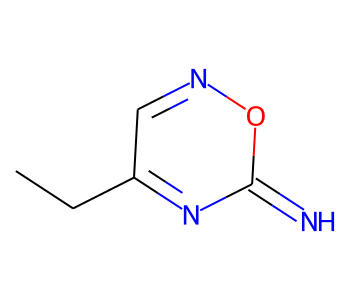

412 OCCc1ccoc1


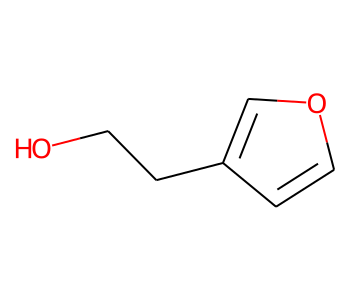

413 CC(=O)c1c[nH]c(N)c1


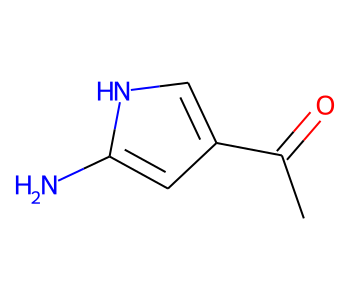

414 O=Cn1nc(O)nc1O


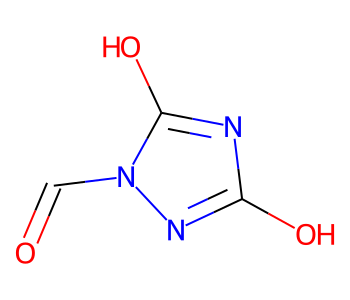

415 O=c1ccoc(=O)nc1


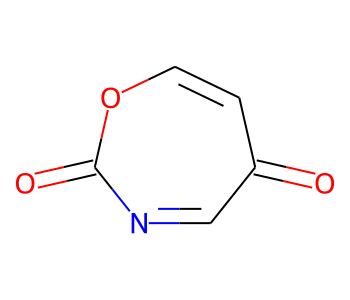

416 CC1=CC=CC=CC=C1


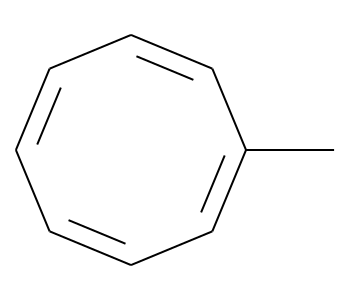

417 Cc1ccc(O)n1C=O


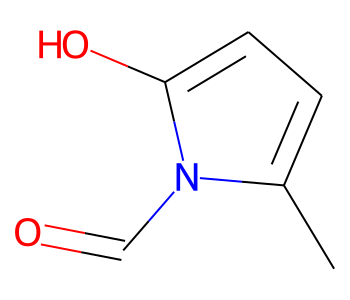

418 C#CC1C=CC(=NO)C1


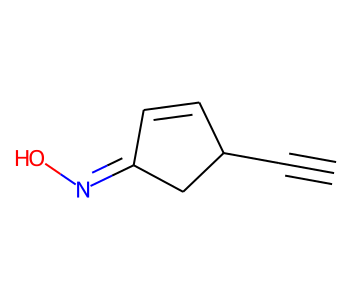

419 CN=c1oc(O)nn1C


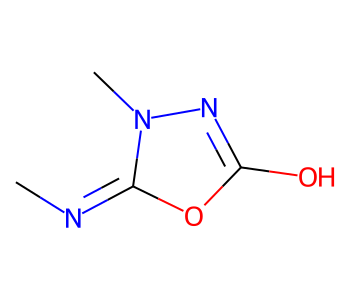

420 CCC(C#N)OCC#N


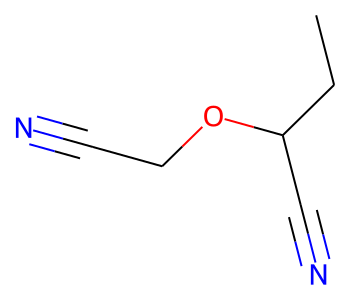

421 CCN(C)C(=O)C(C)O


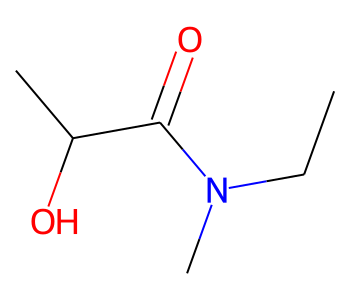

422 N=COCc1cnon1


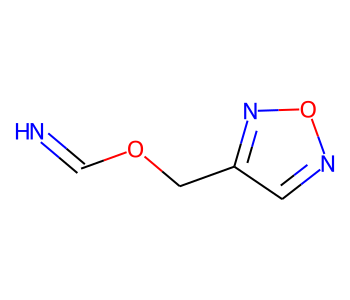

423 CNC(=O)C#CC(N)=O


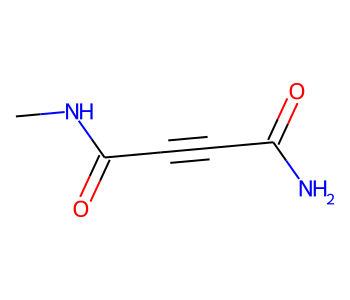

424 COCC(C#N)OC=O


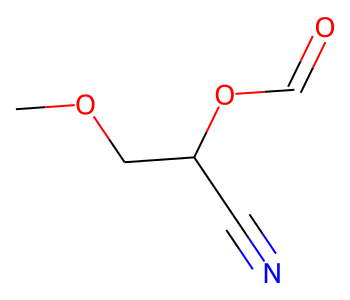

425 C#CC(C#C)(C=O)NC


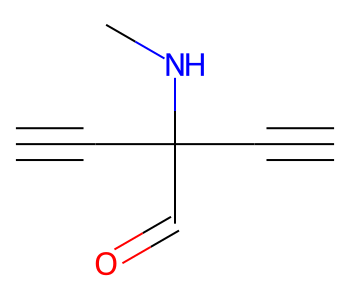

426 OCC1C2COC1CO2


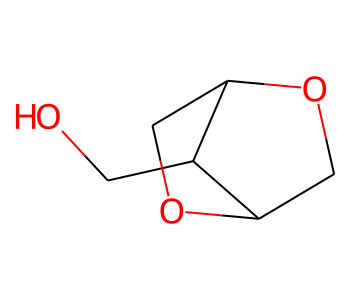

427 Nc1cc(F)ncc1O


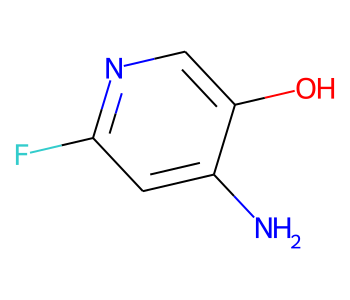

428 N=C(OC=O)C(N)=O


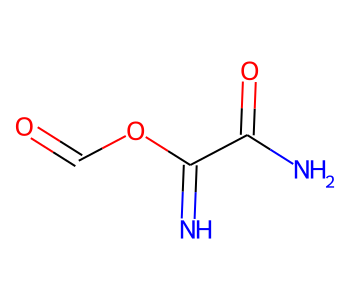

429 O=CNc1ccco1


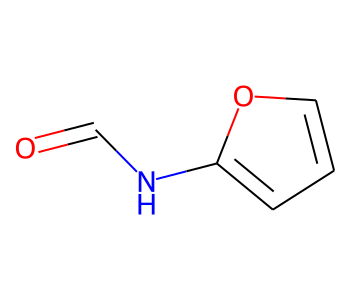

430 N#CC(=O)N(C=N)C=N


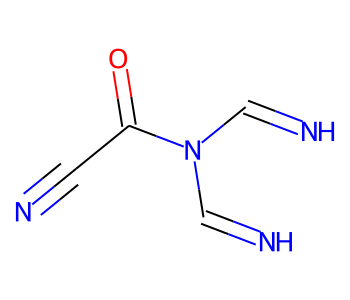

431 O=C1C(O)CCCC1O


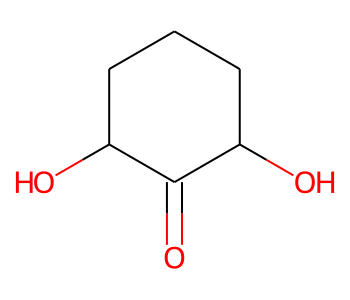

432 CCOC1COCOC1


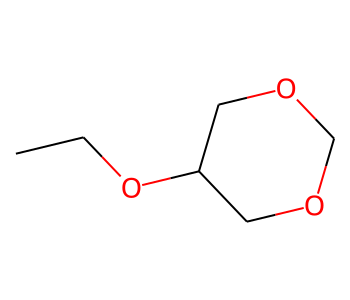

433 C#CCOCC(C)C#N


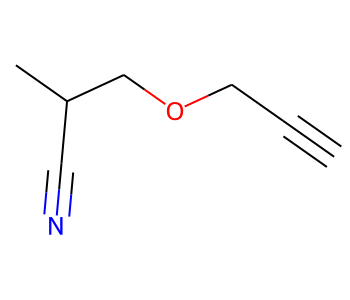

434 CC(C)n1nnc(N)n1


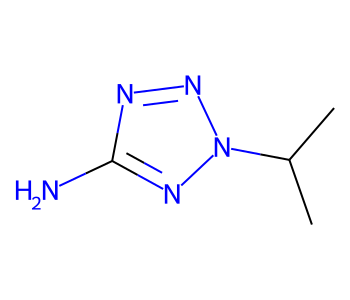

435 OCCOC1CN=CO1


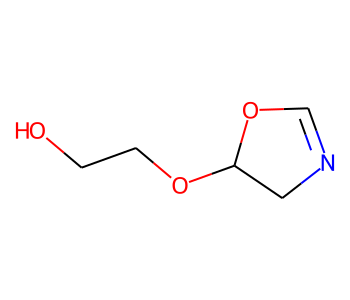

436 Nc1[nH]nc2c1CCN2


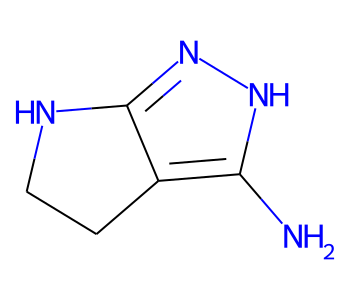

437 N#CCC1C=CCC1=O


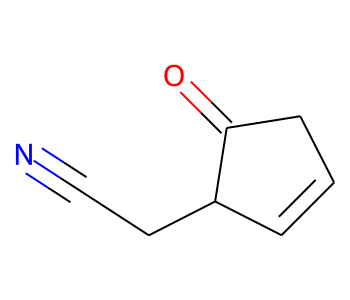

438 CC1COCC(C#N)C1


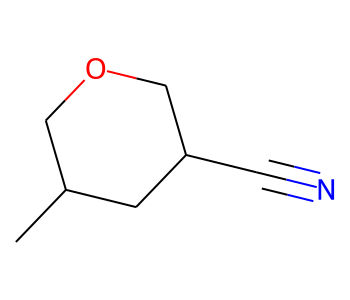

439 C#CC1CCC=CC1=O


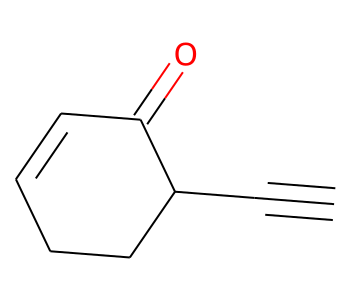

440 CC#CCN(C)CC=O


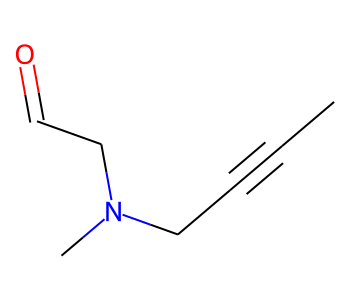

441 O=CC1COC(=O)CN1


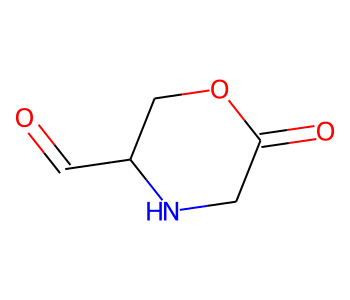

442 C#CCOC(C)C=O


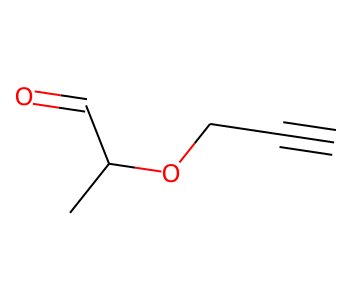

443 COCC(C#N)OC=N


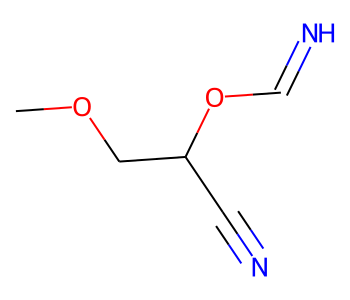

444 O=C1CC=CCCCC1


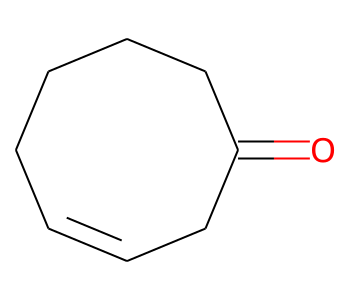

445 C#CCCc1ccc[nH]1


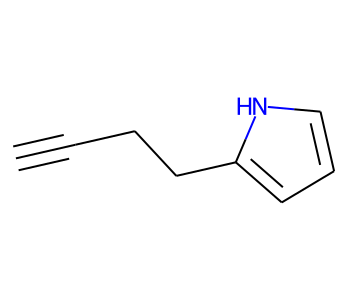

446 CN1C=NC(C)(C#N)C1


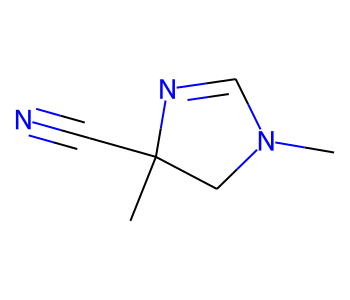

447 c1cncnc1


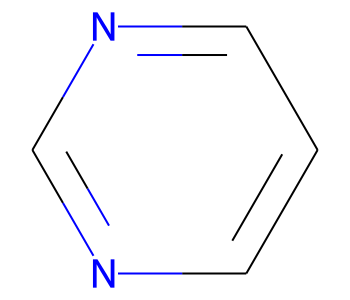

448 CNc1ccc(=O)oc1


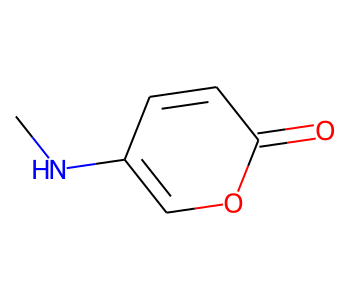

449 CCC(C)CC(C)C=O


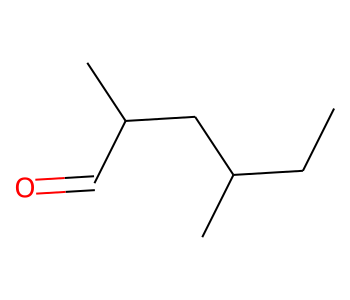

450 N=c1oncccc1=O


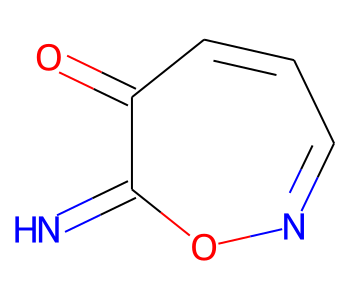

451 Cc1nc(C)n(C=O)n1


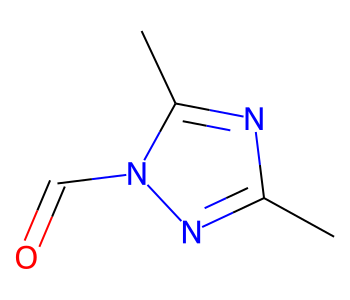

452 N#CC1CC=CC1C=O


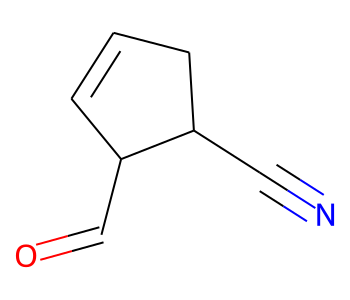

453 CC#CCC(C)CCO


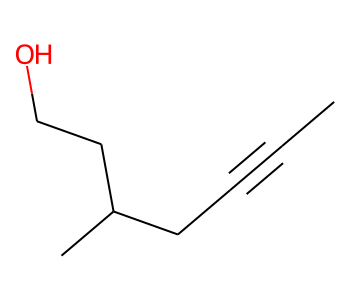

454 O=CNC1=CCCC1=O


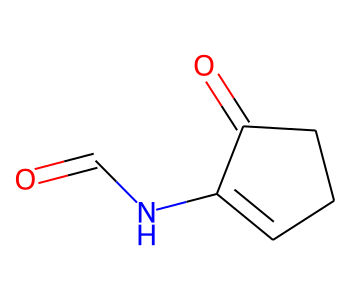

455 C#CCN=COC


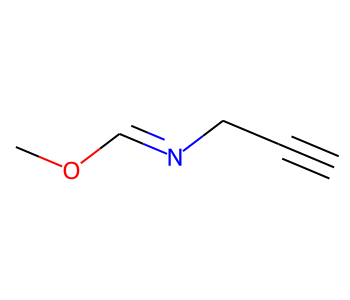

456 Cc1nnn(C=O)c1C


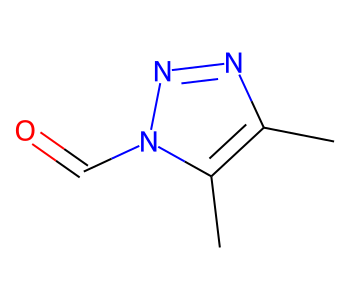

457 C#Cc1c[nH]c(CO)c1


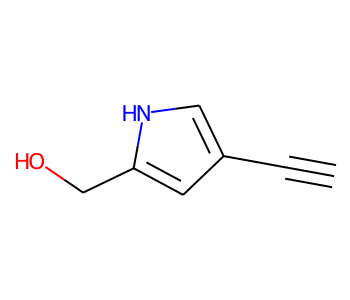

458 O=C1COCOC1=O


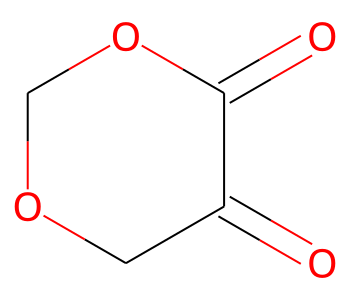

459 Nc1coc(NC=O)n1


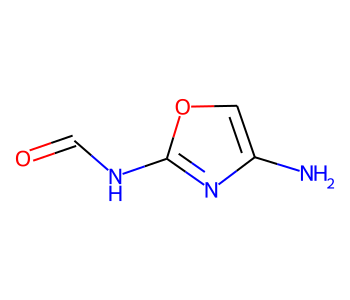

460 C#CC1CNCC(=N)O1


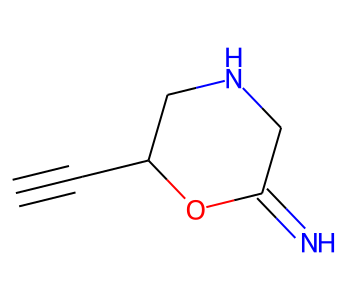

461 CC1CC(C#N)OC=N1


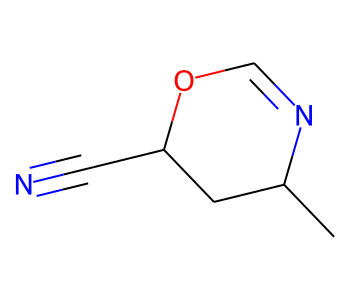

462 CC#CC1C=CNC1=O


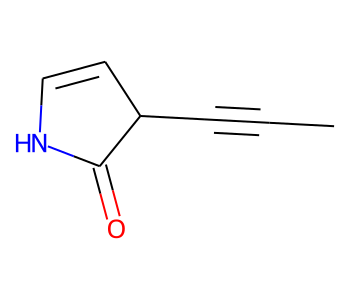

463 N=C1COC(=O)CO1


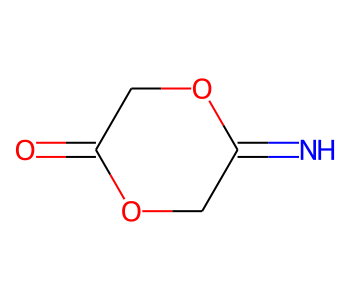

464 N=c1occ(N)nc1F


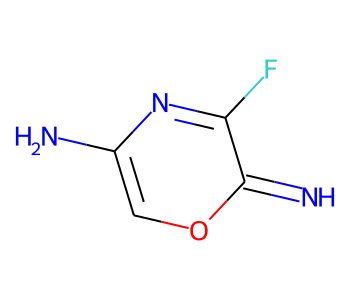

465 O=Cc1cnn[nH]c1=O


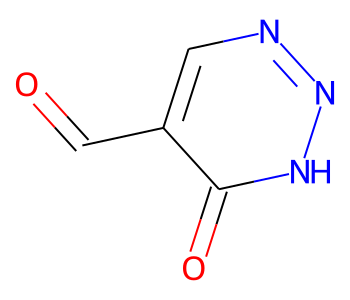

466 CC1=CC2OC(=N)C1O2


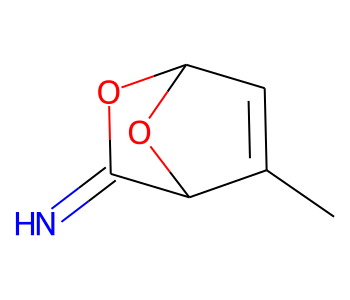

467 CCC1=CCCC1


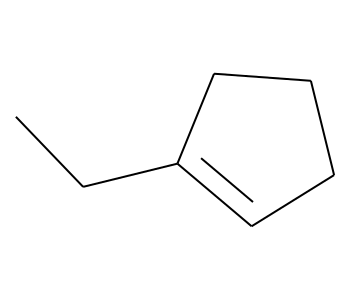

468 CCC1(O)C=CNC1=O


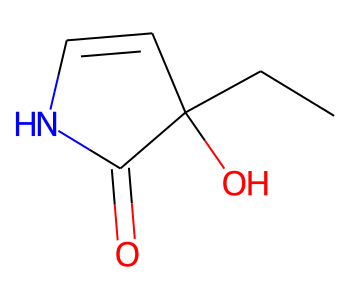

469 C#CC(C)(C)CNC=O


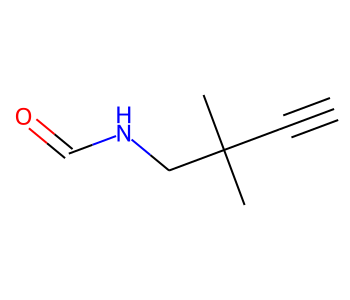

470 C#Cc1coc(C)c1N


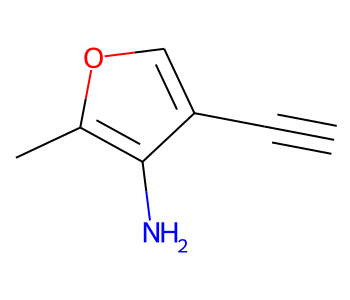

471 CC(=O)C(=N)N(C)C


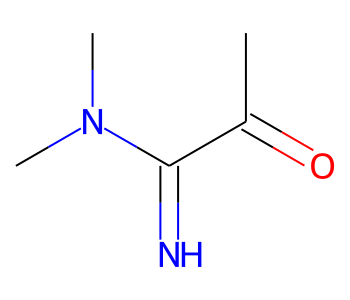

472 CC#CC(C)(CO)OC


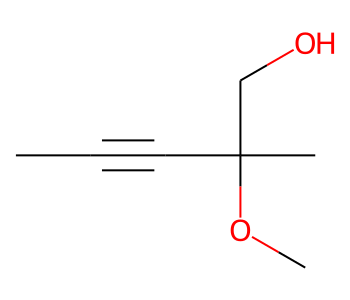

473 N=C1CC(O)C(C=O)O1


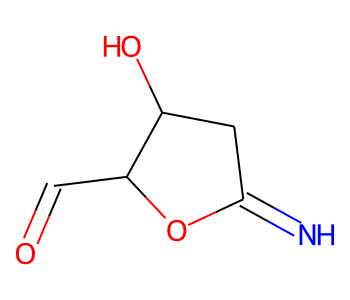

474 N=C(NCC=O)C(N)=O


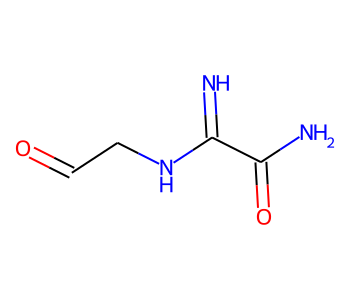

475 CCC1OC2CCC1O2


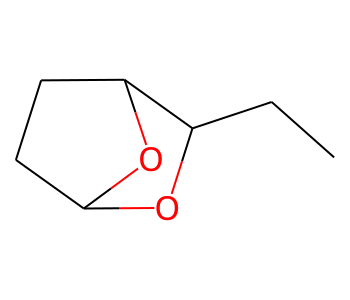

476 CC(O)C(CO)CC=O


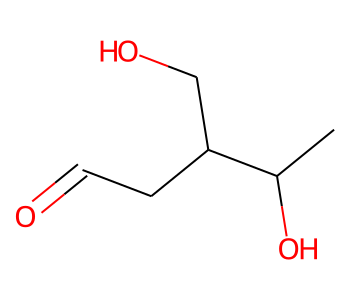

477 C#CCC1OCOC1C


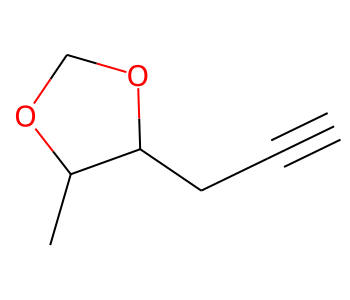

478 CCc1nc(O)n[nH]1


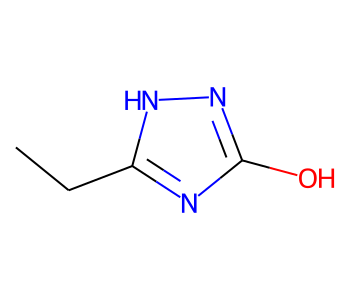

479 CN1C(=N)OCC1C#N


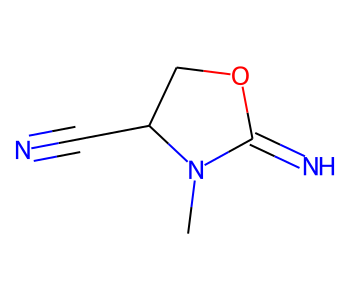

480 C#CCC(C)(C)CO


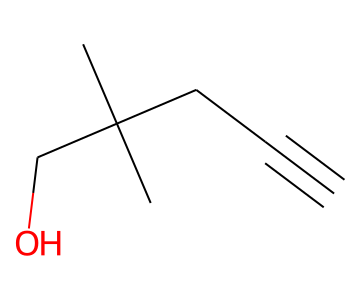

481 NC=Nc1ncc(N)o1


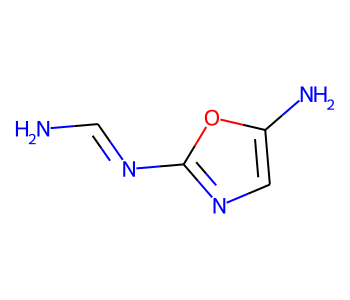

482 CC(=O)OCCOC=N


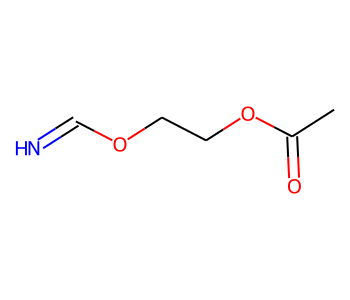

483 Cc1cnc(C)c(O)c1


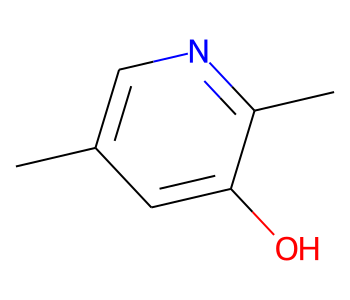

484 Nc1[nH]c(=O)oc1O


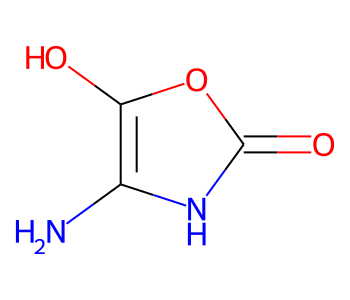

485 CC1OCC=CC(=O)O1


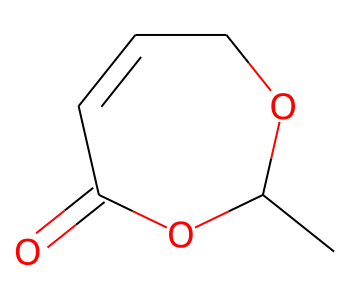

486 N=c1occ(N)oc1=N


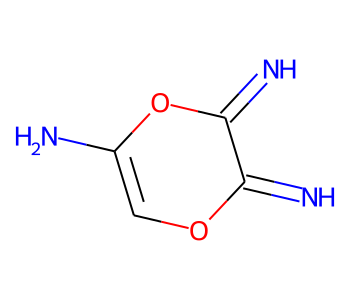

487 CN(C(N)=O)C(N)=O


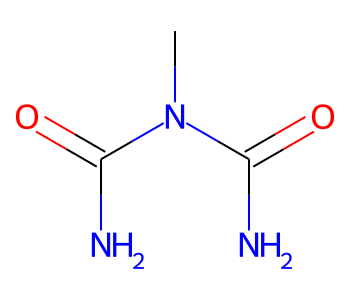

488 Nc1[nH]nc(O)c1C=O


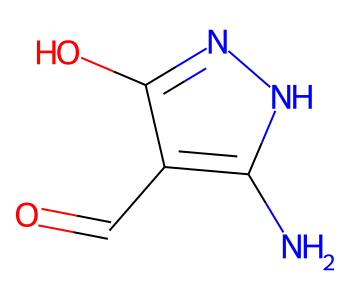

489 CCOC(=N)C(C)O


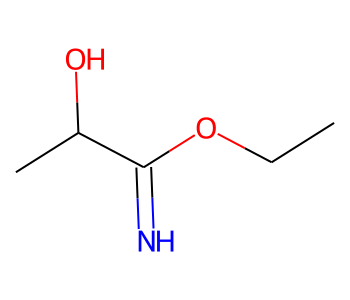

490 CC1Cc2cc[nH]c2C1


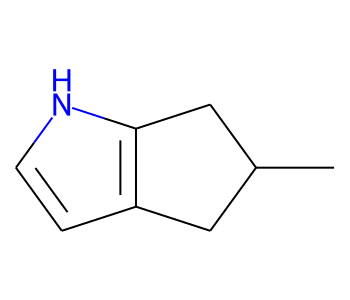

491 O=CNC1C=CCOC1


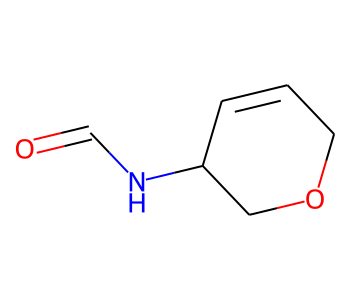

492 Nc1oc(O)nc1O


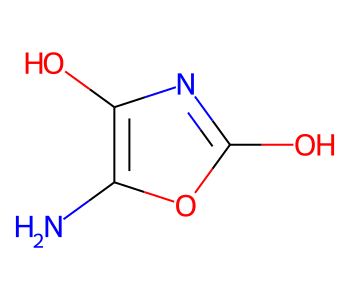

493 N#CC(C#N)(CN)CO


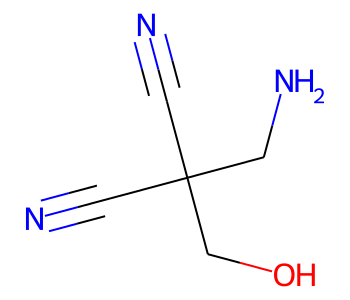

494 c1ncn2c1OCCC2


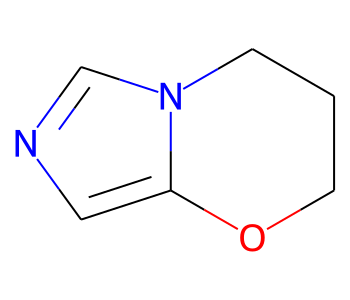

495 CC(C#N)CC(C)(C)O


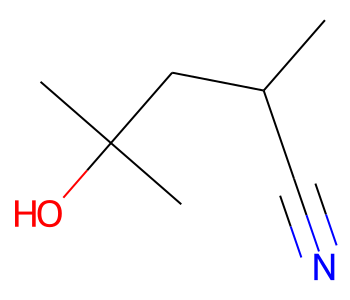

496 N=CN(C=N)C=N


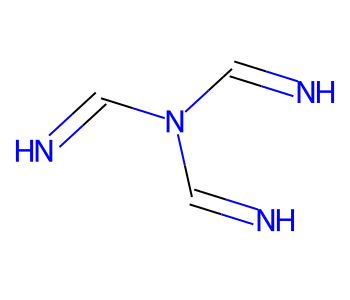

497 c1cc2nnoc2cn1


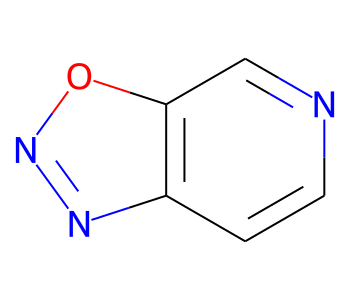

498 CNc1cc[nH]c(=O)n1


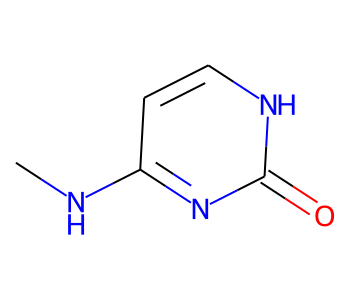

499 C#CC1(C)COC(=N)O1


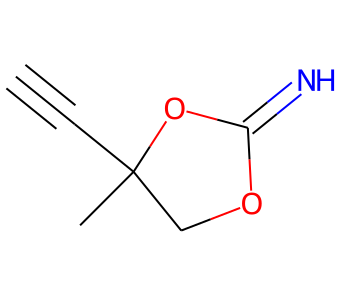

500 C1#CCC=CC=CC=C1


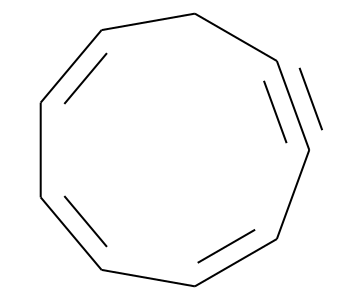

501 O=C1C=CC=CC=CC1


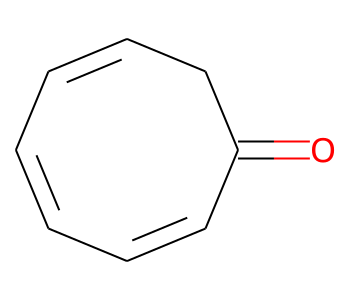

In [21]:
for idx, row in enumerate(all_dat):
    print(idx, row[0])
    
    mol = Chem.MolFromSmiles(row[0])
    d2d = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(350,300)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    svg = IPython.display.SVG(d2d.GetDrawingText())
    display(svg)
            
    if idx > 500:
        break



In [6]:
plt.plot(all_dat[615][2])
plt.show()

NameError: name 'plt' is not defined

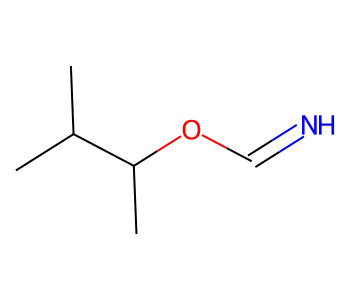

In [12]:
mol = Chem.MolFromSmiles("CC(C)C(C)OC=N")
d2d = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(350,300)
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
svg = IPython.display.SVG(d2d.GetDrawingText())
display(svg)

with open('4_main.svg', 'w') as f:
    f.write(d2d.GetDrawingText())

In [5]:
with open('temp.svg', 'r') as f:
    svg = f.readlines()
svg

["<?xml version='1.0' encoding='iso-8859-1'?>\n",
 "<svg version='1.1' baseProfile='full'\n",
 "              xmlns='http://www.w3.org/2000/svg'\n",
 "                      xmlns:rdkit='http://www.rdkit.org/xml'\n",
 "                      xmlns:xlink='http://www.w3.org/1999/xlink'\n",
 "                  xml:space='preserve'\n",
 "width='350px' height='300px' viewBox='0 0 350 300'>\n",
 '<!-- END OF HEADER -->\n',
 "<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='350' height='300' x='0' y='0'> </rect>\n",
 "<path class='bond-0 atom-0 atom-1' d='M 15.9091,119.383 L 121.97,58.1488' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n",
 "<path class='bond-1 atom-1 atom-2' d='M 121.97,58.1488 L 228.03,119.383' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n",
 "<path class='bond-2 atom-2 atom-3' d='M 228.03,119.38

<_io.TextIOWrapper name='/scratch/temp.svg' mode='r' encoding='UTF-8'>

In [13]:

ir_forward = Forward_IR("~/DeepSPInN/models/IR_Forward" , False)
nmr_forward = P.NMRPredictor("~/DeepSPInN/models/RPNMR/best_model.meta","~/DeepSPInN/models/RPNMR/best_model.00000000.state",False)


Loaded all checkpoint models
Loaded Cache of predictor with size,  999250


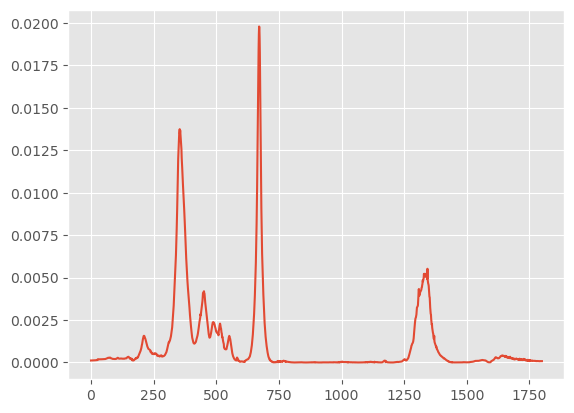

[13.752269744873047, 14.685239791870117, 14.685240745544434, 36.953033447265625, 81.10295867919922, 169.24163818359375]


In [19]:
import matplotlib.pyplot as plt

ir_preds = ir_forward.predict_smiles("CC(C)C(C)OC=N")
plt.plot(ir_preds)
plt.show()

nmr_preds = nmr_forward.predict("CC(C)C(C)OC=N")
print(sorted(nmr_preds))